In [9]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import folium
import os
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import pyreadr
import joypy
from plotnine import *
import scipy.stats as st
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.ticker as mticker
from matplotlib import cm
from scipy.stats import ttest_ind
from scipy.stats import kstest
import scipy.stats as st
from scipy import stats
import warnings
import statsmodels.nonparametric.api as smnp
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
from scipy.special import rel_entr
import torch
import math
from scipy.signal import savgol_filter
from matplotlib.gridspec import GridSpec
from PIL import Image
import statsmodels.api as sm
from statsmodels.formula.api import ols
from distinctipy import distinctipy
from PLSR_modeling import seasonal_data_extraction

## 1. Compiled dataset visualization

### 1.1 Sites distribution

['1234' '124' '134' '12' '34' '14' '4' '1']
['1234' '124' '134' '12' '34' '14' '4' '1']


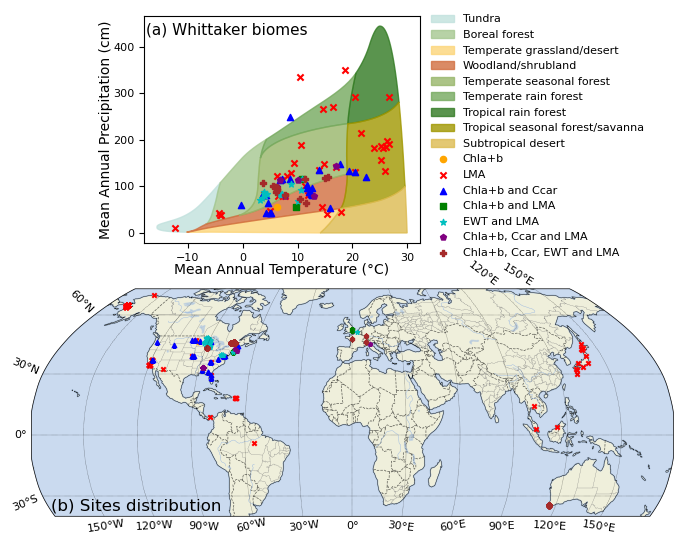

In [101]:
"""
Overall distribution
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
cli_var = "../1_datasets/WorldClim_variables.csv"
Whittaker_biomes = "../1_datasets/Whittaker_biomes.rda"

traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]
climate = pd.read_csv(cli_var)
climate = climate[["bio01", "bio12"]]
traits = pd.concat([traits,climate],axis = 1)

"""
Just Chl: '1', Just car: '2', Just ewt: '3',  Just lma: '4', Chl+car: '12', Chl+ewt: '13', Chl+lma: '14'
car+ewt: '23', car+lma: '24', ewt+lma: '34', Chl+car+ewt: '123', Chl+car+lma: '124', car+ewt+lma: '234',
Chl+car+ewt+lma: '1234'
"""
for i in traits['Site ID'].unique():
    s = traits[traits['Site ID'] == i]
    chl = s[s['Chla+b']>0]
    car = s[s['Ccar']>0]
    cw = s[s['EWT']>0]
    cm = s[s['LMA']>0]

    if len(chl) > 0:
        aa = '1'
    else:
        aa =''
    if len(car) > 0:
        bb = '2'
    else:
        bb =''
    if len(cw) > 0:
        cc = '3'
    else:
        cc =''
    if len(cm) > 0:
        dd = '4'
    else:
        dd =''
    types = aa+bb+cc+dd
    traits.loc[traits['Site ID'] == i, 'types']=types
print(traits['types'].unique())

######
fig = plt.figure(figsize=(9,6.5))  
gs = GridSpec(2, 10)

ax1 = plt.subplot(gs[0, 2:6])
ax2 = plt.subplot(gs[1,:],projection=ccrs.Robinson(central_longitude=0))

config = {"font.family":'Calibri'}
plt.rcParams.update(config)
plt.subplots_adjust(wspace =0.1)

only_chl = traits[traits['types'] == '1']
only_lma = traits[traits['types'] == '4']
chl_car =  traits[traits['types'] == '12']
chl_lma =  traits[traits['types'] == '14']
ewt_lma =  traits[traits['types'] == '34']
chl_car_lma = traits[traits['types'] == '124']
chl_car_ewt_lma = traits[traits['types'] == '1234']

only_chl = pd.DataFrame(only_chl[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
only_lma = pd.DataFrame(only_lma[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
chl_car = pd.DataFrame(chl_car[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
chl_lma = pd.DataFrame(chl_lma[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
ewt_lma = pd.DataFrame(ewt_lma[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
chl_car_lma = pd.DataFrame(chl_car_lma[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
chl_car_ewt_lma = pd.DataFrame(chl_car_ewt_lma[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])

only_chl['lon'] = only_chl['coordinates'].apply(lambda x: x[0])
only_chl['lat'] = only_chl['coordinates'].apply(lambda x: x[1])
only_lma['lon'] = only_lma['coordinates'].apply(lambda x: x[0])
only_lma['lat'] = only_lma['coordinates'].apply(lambda x: x[1])
chl_car['lon'] = chl_car['coordinates'].apply(lambda x: x[0])
chl_car['lat'] = chl_car['coordinates'].apply(lambda x: x[1])
chl_lma['lon'] = chl_lma['coordinates'].apply(lambda x: x[0])
chl_lma['lat'] = chl_lma['coordinates'].apply(lambda x: x[1])
ewt_lma['lon'] = ewt_lma['coordinates'].apply(lambda x: x[0])
ewt_lma['lat'] = ewt_lma['coordinates'].apply(lambda x: x[1])
chl_car_lma['lon'] = chl_car_lma['coordinates'].apply(lambda x: x[0])
chl_car_lma['lat'] = chl_car_lma['coordinates'].apply(lambda x: x[1])
chl_car_ewt_lma['lon'] = chl_car_ewt_lma['coordinates'].apply(lambda x: x[0])
chl_car_ewt_lma['lat'] = chl_car_ewt_lma['coordinates'].apply(lambda x: x[1])

states_provinces = cf.NaturalEarthFeature(category='cultural',
                                          name='admin_1_states_provinces_lines',
                                          scale='50m',facecolor='none')
# ax2 = plt.axes(projection=ccrs.Robinson(central_longitude=-10))
ax2.set_extent([-179, 179, -40, 75])

ax2.add_feature(cf.LAND)
ax2.add_feature(cf.BORDERS, linestyle='--',alpha=0.6,lw=0.5)
ax2.add_feature(cf.LAKES, alpha=0.4)
ax2.add_feature(cf.OCEAN,alpha=0.5)
ax2.add_feature(cf.COASTLINE,lw=0.3)
ax2.add_feature(cf.RIVERS,lw=0.3)
ax2.add_feature(states_provinces,lw=0.2,edgecolor='gray')

gl=ax2.gridlines(draw_labels=True,linestyle=":",linewidth=0.3,color='k')
gl.top_labels=False #关闭上部经纬标签                                  
gl.right_labels=False
gl.xformatter = LONGITUDE_FORMATTER  #使横坐标转化为经纬度格式            
gl.yformatter = LATITUDE_FORMATTER                                        
gl.xlocator=mticker.FixedLocator(np.arange(-150,180,30))      
gl.ylocator=mticker.FixedLocator(np.arange(-90,90,30)) 
gl.xlabel_style={'size':8}#修改经纬度字体大小                             
gl.ylabel_style={'size':8}
ax2.spines['geo'].set_linewidth(0.5)#调节边框粗细

ax2.scatter(only_chl['lon'],only_chl['lat'],s = 10,alpha = 1,marker ='o',color = 'orange',transform=ccrs.PlateCarree(),label = 'Chla+b')
ax2.scatter(only_lma['lon'],only_lma['lat'],s = 10,alpha = 1,marker ='x',color = 'r',transform=ccrs.PlateCarree(),label = 'LMA')
ax2.scatter(chl_car['lon'],chl_car['lat'],s = 10,alpha = 1,marker ='^' ,color = 'b',transform=ccrs.PlateCarree(),label = 'Chla+b and Ccar')
ax2.scatter(chl_lma['lon'],chl_lma['lat'],s = 10,alpha = 1,marker ='s',color = 'g',transform=ccrs.PlateCarree(),label = 'Chla+b and LMA')
ax2.scatter(ewt_lma['lon'],ewt_lma['lat'],s = 10,alpha = 1,marker ='*',color = 'c',transform=ccrs.PlateCarree(),label = 'EWT and LMA')
ax2.scatter(chl_car_lma['lon'],chl_car_lma['lat'],s = 10,alpha = 1,marker ='p' ,color = 'purple',transform=ccrs.PlateCarree(),label = 'Chla+b, Ccar and LMA')
ax2.scatter(chl_car_ewt_lma['lon'],chl_car_ewt_lma['lat'],s = 10,alpha = 1,marker ='P',color = 'brown',transform=ccrs.PlateCarree(),label = 'Chla+b, Ccar, EWT and LMA')
ax2.text(0.03,0.025, '(b) Sites distribution', transform=ax2.transAxes, fontsize = 12)


#########
for i in traits['Site ID'].unique():
    s = traits[traits['Site ID'] == i]
    chl = s[s['Chla+b']>0]
    car = s[s['Ccar']>0]
    cw = s[s['EWT']>0]
    cm = s[s['LMA']>0]

    if len(chl) > 0:
        aa = '1'
    else:
        aa =''
    if len(car) > 0:
        bb = '2'
    else:
        bb =''
    if len(cw) > 0:
        cc = '3'
    else:
        cc =''
    if len(cm) > 0:
        dd = '4'
    else:
        dd =''
    types = aa+bb+cc+dd
    traits.loc[traits['Site ID'] == i, 'types']=types
print(traits['types'].unique())

index = ['Site ID','types','bio01','bio12']
traits_ex = traits[index]
traits_ex.columns = ['Site ID','types','MAT','MAP']

climate_variables= pd.DataFrame(np.zeros(shape = (len(traits_ex['Site ID'].unique()),4)),columns = ['Site ID','types','MAT','MAP'])

k = 0
for i in traits_ex['Site ID'].unique():
    df = traits_ex[traits_ex['Site ID'] == i]
    types_ = df['types'].unique()[0]
    df1 = df.loc[:,'MAT':]
    mat = df1.mean()['MAT']
    ma_p = df1.mean()['MAP']
    climate_variables.iloc[k] = np.array([i,types_, mat,ma_p])
    k = k+1
climate_variables['MAT'] = climate_variables['MAT'].astype(float)
climate_variables['MAP'] = climate_variables['MAP'].astype(float)
climate_variables['MAP'] = climate_variables['MAP']/10

result = pyreadr.read_r(Whittaker_biomes)
ddf = result['Whittaker_biomes']
ddf['biome'].unique()
ddf.reset_index(drop = True, inplace  = True)
ddf.columns = ["Mean Annual Temperature (°C)",'Mean Annual Precipitation (cm)','biome_id','(a) Whittaker biomes']

only_chl = climate_variables[climate_variables['types'] == '1']
only_lma = climate_variables[climate_variables['types'] == '4']
chl_car =  climate_variables[climate_variables['types'] == '12']
chl_lma =  climate_variables[climate_variables['types'] == '14']
ewt_lma =  climate_variables[climate_variables['types'] == '34']
chl_car_lma = climate_variables[climate_variables['types'] == '124']
chl_car_ewt_lma = climate_variables[climate_variables['types'] == '1234']

s = ["#C1E1DD","#A5C790","#FCD57A","#D16E3F","#97B669","#75A95E","#317A22","#A09700","#DCBB50"]
k=0
for i in ddf['(a) Whittaker biomes'].unique():
    data = ddf[ddf['(a) Whittaker biomes'] == i]
    ax1.fill(data["Mean Annual Temperature (°C)"],data['Mean Annual Precipitation (cm)'],color = s[k],label =i, alpha = 0.8,zorder=1)
    k = k+1
    
ax1.scatter(only_chl['MAT'],only_chl['MAP'],s = 20,alpha = 1,marker ='o',color = 'orange',label = 'Chla+b',zorder=2)
ax1.scatter(only_lma['MAT'],only_lma['MAP'],s = 20,alpha = 1,marker ='x',color = 'r',label = 'LMA',zorder=2)
ax1.scatter(chl_car['MAT'],chl_car['MAP'],s = 20,alpha = 1,marker ='^' ,color = 'b',label = 'Chla+b and Ccar',zorder=2)
ax1.scatter(chl_lma['MAT'],chl_lma['MAP'],s = 20,alpha = 1,marker ='s',color = 'g',label = 'Chla+b and LMA',zorder=2)
ax1.scatter(ewt_lma['MAT'],ewt_lma['MAP'],s = 20,alpha = 1,marker ='*',color = 'c',label = 'EWT and LMA',zorder=2)
ax1.scatter(chl_car_lma['MAT'],chl_car_lma['MAP'],s = 20,alpha = 1,marker ='p' ,color = 'purple',label = 'Chla+b, Ccar and LMA',zorder=2)
ax1.scatter(chl_car_ewt_lma['MAT'],chl_car_ewt_lma['MAP'],s = 20,alpha = 1,marker ='P',color = 'brown',label = 'Chla+b, Ccar, EWT and LMA',zorder=2)

ax1.set_xlabel('Mean Annual Temperature (°C)', fontsize=10, labelpad = 0.2)
ax1.set_ylabel('Mean Annual Precipitation (cm)', fontsize=10, labelpad = 0.2)
ax1.text(0.007,0.92, '(a) Whittaker biomes', transform=ax1.transAxes, fontsize = 11)
ax1.legend(loc = 'upper right',fontsize=8, facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1.85, 1.05))
plt.savefig('../3_figures/Fig 1_sites distribution.png', dpi=250, bbox_inches='tight')

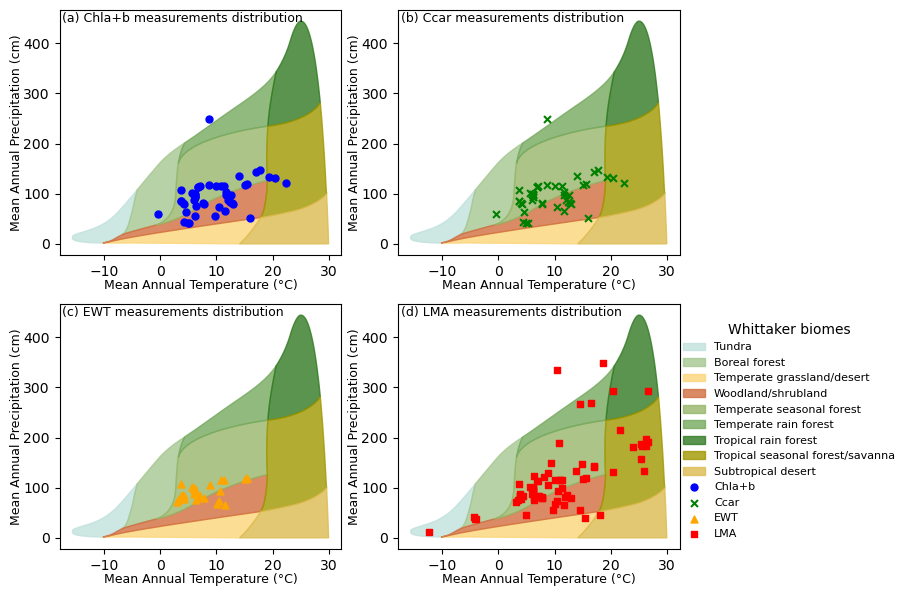

In [7]:
"""
Climate zones locations
"""

dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
cli_var = "../1_datasets/WorldClim_variables.csv"
Whittaker_biomes = "../1_datasets/Whittaker_biomes.rda"

traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]
climate = pd.read_csv(cli_var)
climate = climate[["bio01", "bio12"]]
traits = pd.concat([traits,climate],axis = 1)

index = ['Site ID','Chla+b','Ccar','EWT','LMA','bio01','bio12']
traits_ex = traits[index]
traits_ex.columns = ['Site ID','Chla+b','Ccar','EWT','LMA','MAT','MAP']

Cab_frame = traits_ex[traits_ex['Chla+b']>0]
Ccar_frame = traits_ex[traits_ex['Ccar']>0]
EWT_frame = traits_ex[traits_ex['EWT']>0]
LMA_frame = traits_ex[traits_ex['LMA']>0]

cv1= pd.DataFrame(np.zeros(shape = (len(Cab_frame['Site ID'].unique()),3)),columns = ['Site ID','MAT','MAP'])
cv2= pd.DataFrame(np.zeros(shape = (len(Ccar_frame['Site ID'].unique()),3)),columns = ['Site ID','MAT','MAP'])
cv3= pd.DataFrame(np.zeros(shape = (len(EWT_frame['Site ID'].unique()),3)),columns = ['Site ID','MAT','MAP'])
cv4= pd.DataFrame(np.zeros(shape = (len(LMA_frame['Site ID'].unique()),3)),columns = ['Site ID','MAT','MAP'])

k = 0
for i in Cab_frame['Site ID'].unique():
    df = Cab_frame[Cab_frame['Site ID'] == i]
    df1 = df.loc[:,'MAT':]
    mat = df1.mean()['MAT']
    ma_p = df1.mean()['MAP']
    cv1.iloc[k] = np.array([i, mat,ma_p])
    k = k+1

k = 0
for i in Ccar_frame['Site ID'].unique():
    df = Ccar_frame[Ccar_frame['Site ID'] == i]
    df1 = df.loc[:,'MAT':]
    mat = df1.mean()['MAT']
    ma_p = df1.mean()['MAP']
    cv2.iloc[k] = np.array([i, mat,ma_p])
    k = k+1
    
k = 0
for i in EWT_frame['Site ID'].unique():
    df = EWT_frame[EWT_frame['Site ID'] == i]
    df1 = df.loc[:,'MAT':]
    mat = df1.mean()['MAT']
    ma_p = df1.mean()['MAP']
    cv3.iloc[k] = np.array([i, mat,ma_p])
    k = k+1
    
k = 0
for i in LMA_frame['Site ID'].unique():
    df = LMA_frame[LMA_frame['Site ID'] == i]
    df1 = df.loc[:,'MAT':]
    mat = df1.mean()['MAT']
    ma_p = df1.mean()['MAP']
    cv4.iloc[k] = np.array([i, mat,ma_p])
    k = k+1

cv1['MAT'] = cv1['MAT'].astype(float)
cv1['MAP'] = cv1['MAP'].astype(float)
cv1['MAP'] = cv1['MAP']/10

cv2['MAT'] = cv2['MAT'].astype(float)
cv2['MAP'] = cv2['MAP'].astype(float)
cv2['MAP'] = cv2['MAP']/10

cv3['MAT'] = cv3['MAT'].astype(float)
cv3['MAP'] = cv3['MAP'].astype(float)
cv3['MAP'] = cv3['MAP']/10

cv4['MAT'] = cv4['MAT'].astype(float)
cv4['MAP'] = cv4['MAP'].astype(float)
cv4['MAP'] = cv4['MAP']/10

result = pyreadr.read_r(Whittaker_biomes)
ddf = result['Whittaker_biomes']
ddf['biome'].unique()
ddf.reset_index(drop = True, inplace  = True)
ddf.columns = ["Mean Annual Temperature (°C)",'Mean Annual Precipitation (cm)','biome_id','(a) Whittaker biomes']

fig,[(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2, figsize = (8,7))
s = ["#C1E1DD","#A5C790","#FCD57A","#D16E3F","#97B669","#75A95E","#317A22","#A09700","#DCBB50"]

k=0
for i in ddf['(a) Whittaker biomes'].unique():
    data = ddf[ddf['(a) Whittaker biomes'] == i]
    ax1.fill(data["Mean Annual Temperature (°C)"],data['Mean Annual Precipitation (cm)'],color = s[k],label=i, alpha = 0.8,zorder=1)
    ax2.fill(data["Mean Annual Temperature (°C)"],data['Mean Annual Precipitation (cm)'],color = s[k], alpha = 0.8,zorder=1)
    ax3.fill(data["Mean Annual Temperature (°C)"],data['Mean Annual Precipitation (cm)'],color = s[k], alpha = 0.8,zorder=1)
    ax4.fill(data["Mean Annual Temperature (°C)"],data['Mean Annual Precipitation (cm)'],color = s[k], alpha = 0.8,zorder=1)
    k = k+1

ax1.scatter(cv1['MAT'],cv1['MAP'],s = 25,alpha = 1,marker ='o',color = 'b',label = 'Chla+b',zorder=2)
ax2.scatter(cv2['MAT'],cv2['MAP'],s = 25,alpha = 1,marker ='x',color = 'g',label = 'Ccar',zorder=2)
ax3.scatter(cv3['MAT'],cv3['MAP'],s = 25,alpha = 1,marker ='^' ,color = 'orange',label = 'EWT',zorder=2)
ax4.scatter(cv4['MAT'],cv4['MAP'],s = 25,alpha = 1,marker ='s',color = 'r',label = 'LMA',zorder=2)

lines=[]
labels=[]

for ax in [ax1,ax2,ax3,ax4]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

plt.legend(lines, labels,loc='lower right',fontsize=8, facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1.8, 0), title = 'Whittaker biomes')

ax1.set_xlabel('Mean Annual Temperature (°C)', fontsize=9, labelpad = 0.2)
ax1.set_ylabel('Mean Annual Precipitation (cm)', fontsize=9, labelpad = 0.2)
ax2.set_xlabel('Mean Annual Temperature (°C)', fontsize=9, labelpad = 0.2)
ax2.set_ylabel('Mean Annual Precipitation (cm)', fontsize=9, labelpad = 0.2)
ax3.set_xlabel('Mean Annual Temperature (°C)', fontsize=9, labelpad = 0.2)
ax3.set_ylabel('Mean Annual Precipitation (cm)', fontsize=9, labelpad = 0.2)
ax4.set_xlabel('Mean Annual Temperature (°C)', fontsize=9, labelpad = 0.2)
ax4.set_ylabel('Mean Annual Precipitation (cm)', fontsize=9, labelpad = 0.2)

ax1.text(0.01,0.95, '(a) Chla+b measurements distribution', transform=ax1.transAxes, fontsize = 9)
ax2.text(0.01,0.95, '(b) Ccar measurements distribution', transform=ax2.transAxes, fontsize = 9)
ax3.text(0.01,0.95, '(c) EWT measurements distribution', transform=ax3.transAxes, fontsize = 9)
ax4.text(0.01,0.95, '(d) LMA measurements distribution', transform=ax4.transAxes, fontsize = 9)
plt.savefig('../3_figures/Fig S1_sites distribution.png', dpi=500, bbox_inches='tight')

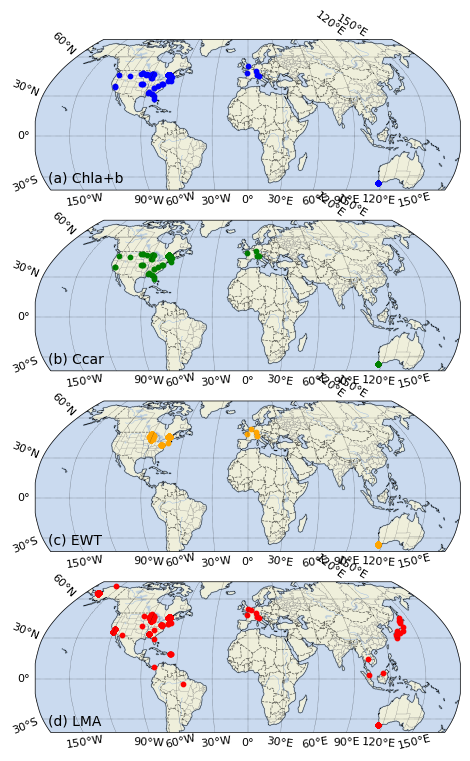

In [106]:
"""
geographic locations
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]

####
trait_name = ['Chla+b','Ccar','EWT','LMA']
colors = ['b','g','orange','r']
tag = ['(a) ','(b) ','(c) ','(d) ']
fig,ax = plt.subplots(4,1,figsize = (7,9),subplot_kw={'projection': ccrs.Robinson(central_longitude=0)})
config = {"font.family":'Calibri'}
plt.rcParams.update(config)
states_provinces = cf.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m',facecolor='none')

k = 0
for tr in trait_name:
    frame = traits[traits[tr]>0]
    frame_sites = pd.DataFrame(frame[['Longitude','Latitude']].apply(tuple,axis = 1).unique(), columns = ['coordinates'])
    frame_sites['lon'] = frame_sites['coordinates'].apply(lambda x: x[0])
    frame_sites['lat'] = frame_sites['coordinates'].apply(lambda x: x[1])
    
    ax[k].set_extent([-179, 179, -40, 75])
    ax[k].add_feature(cf.LAND)
    ax[k].add_feature(cf.BORDERS, linestyle='--',alpha=0.6,lw=0.5)
    ax[k].add_feature(cf.LAKES, alpha=0.4)
    ax[k].add_feature(cf.OCEAN,alpha=0.5)
    ax[k].add_feature(cf.COASTLINE,lw=0.3)
    ax[k].add_feature(cf.RIVERS,lw=0.3)
    ax[k].add_feature(states_provinces,lw=0.2,edgecolor='gray')

    gl=ax[k].gridlines(draw_labels=True,linestyle=":",linewidth=0.3,color='k')
    gl.top_labels=False                           
    gl.right_labels=False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER                                        
    gl.xlocator=mticker.FixedLocator(np.arange(-150,180,30))      
    gl.ylocator=mticker.FixedLocator(np.arange(-90,90,30)) 
    gl.xlabel_style={'size':8}                      
    gl.ylabel_style={'size':8}
    ax[k].spines['geo'].set_linewidth(0.5)
    ax[k].scatter(frame_sites['lon'],frame_sites['lat'],s = 10,alpha = 1,marker ='o' ,color = colors[k],transform=ccrs.PlateCarree())
    ax[k].text(0.03,0.05, tag[k]+tr, transform=ax[k].transAxes, fontsize = 10)
    k=k+1
plt.savefig('../3_figures/Fig S2_sites distribution.png', dpi=250, bbox_inches='tight')

### 1.2 trait variations

In [10]:
def s_filter(y):
    sites = []
    for i in y['Site ID'].unique():
        df = y[y['Site ID'] == i]
        if len(df) > 100:
            sites.append(i)
    sites = np.array(sites)
    return sites
def p_filter(y):
    PFTs = y['PFT'].unique().tolist()
    PFTs = np.array([i for i in PFTs if pd.isnull(i) == False and i != 'nan'])
    return PFTs
def takeFirst(elem):
    return elem[0]
def get_key (dic, value):
    return [k for k, v in dic.items() if v == value]
def kde_test(data):
    kde = smnp.KDEUnivariate(data)
    kde.fit("gau", "scott", "gau", gridsize=10000, cut=3)
    return kde.support, kde.density

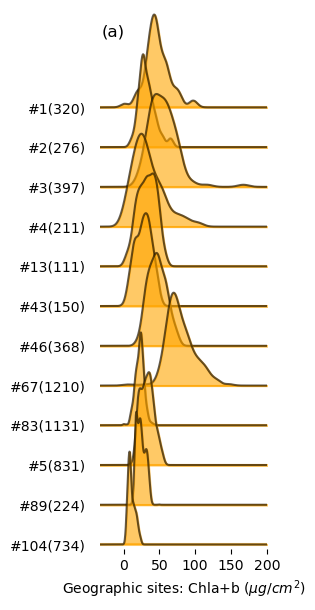

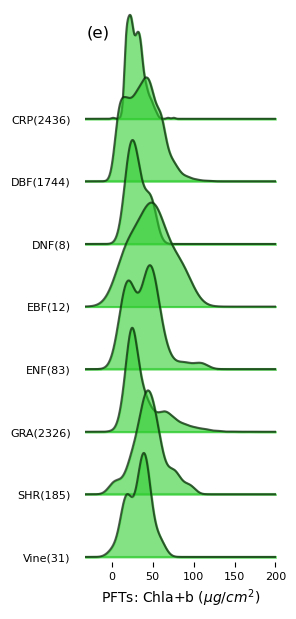

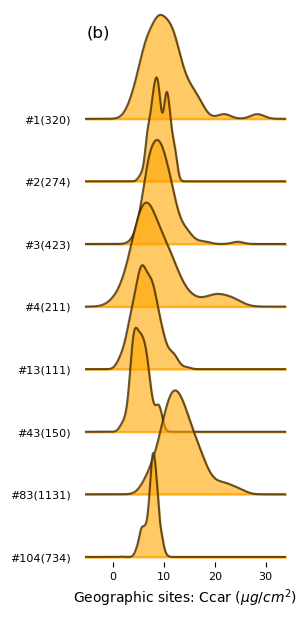

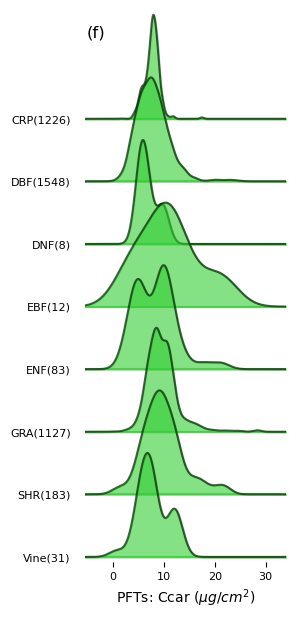

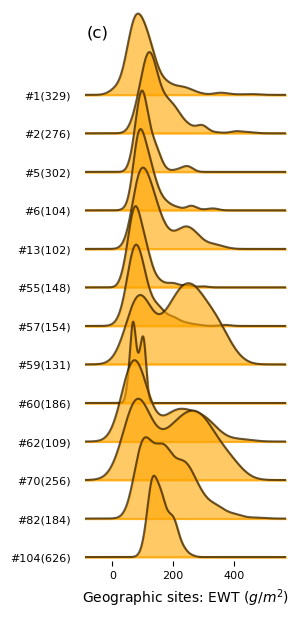

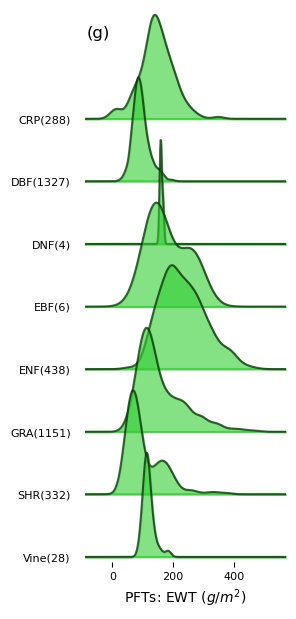

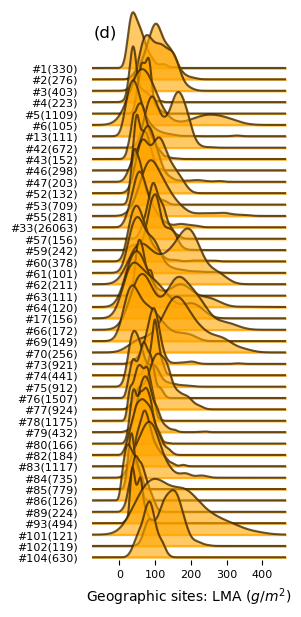

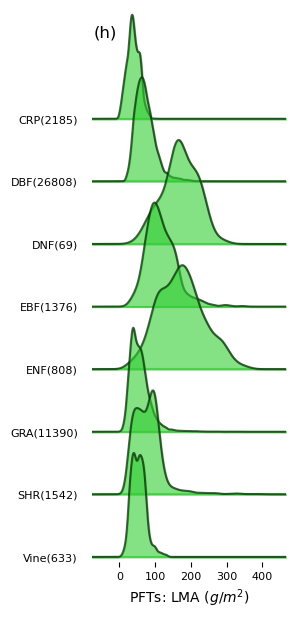

In [11]:
"""
trait density distributions
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]

trait_name = ['Chla+b','Ccar','EWT','LMA']
tag1 = ['(a)','(b)','(c)','(d)']
tag2 = ['(e)','(f)','(g)','(h)']
k=0
for tr in trait_name:
    frame = traits[traits[tr]>0]
    if tr=='Chla+b':
        unit = ' ($\mu g/cm^2$)'
    if tr =='Ccar':
        unit = ' ($\mu g/cm^2$)'
    if tr=='EWT':
        frame = frame[frame[tr]<500]
        unit = ' ($g/m^2$)'
    if tr=='LMA':
        unit = ' ($g/m^2$)'

    frame = frame[['Site ID','PFT',tr]]
    s = s_filter(frame)
    p = p_filter(frame)
    
    df1 = frame.loc[frame['Site ID'].isin(s)]
    df2 = frame.loc[frame['PFT'].isin(p)]
    
    labels = [x[4:] for x in s]
    sample_size = []
    for i in s:
        data=df1[df1['Site ID'] == i]
        size = '('+str(len(data))+')'
        sample_size.append(size)
    
    new_labs = []
    for i in range(len(labels)):
        a = labels[i]+sample_size[i]
        new_labs.append(a)
#     'royalblue','orange','limegreen'
    ###
    fig, axes = joypy.joyplot(df1, by='Site ID',column = tr,grid=None,ylim='own',labels = new_labs,linewidth=1.5,legend=False, alpha=.6,figsize=(3,6),bins = 1000,color = 'orange')
    ax = plt.gca()
    plt.rc("font", size=8)
    ax.set_xlabel('Geographic sites: '+tr+unit,fontsize = 10)
    ax.text(0.01,0.95, tag1[k], transform=ax.transAxes, fontsize = 12)
    plt.savefig('traits_variations_'+tr+'.png', dpi=1500, bbox_inches='tight')
    
    label = {'Croplands':'CRP','Deciduous broadleaf forests':'DBF','Deciduous needleleaf forests':'DNF',
             'Evergreen broadleaf forests':'EBF','Evergreen needleleaf forests':'ENF','Grasslands':'GRA',
             'Shrublands':'SHR','Vine':'Vine'}
    L = []
    for i in p:
        data=df2[df2['PFT'] == i]
        size = label[i]+'('+str(len(data))+')'
        L.append(size)
    L.sort(key=takeFirst)

    fig, axes = joypy.joyplot(df2, by='PFT',column = tr,grid=None,ylim='own',labels = L,linewidth=1.5,legend=False, alpha=.6,
                          figsize=(3,6),bins = 1000,color='limegreen')
    ax = plt.gca()
    plt.rc("font", size=8)
    ax.set_xlabel('PFTs: '+tr+unit,fontsize = 10)
    ax.text(0.01,0.95, tag2[k], transform=ax.transAxes, fontsize = 12)
    plt.savefig('traits_variations_PFT_'+tr+'.png', dpi=1500, bbox_inches='tight')
    k = k+1
####
im1 = Image.open('traits_variations_Chla+b.png')
im2 = Image.open('traits_variations_Ccar.png')
im3 = Image.open('traits_variations_EWT.png')
im4 = Image.open('traits_variations_LMA.png')

im_list = [im1,im2,im3,im4]
ims = []
for i in im_list:
    new_img = i.resize((im1.size[0], im1.size[1]), Image.BILINEAR)
    ims.append(new_img)
    
width, height = ims[0].size
result = Image.new(ims[0].mode, (width * len(ims), height))
for i, im in enumerate(ims):
    result.paste(im, box=(i*width,0))
result.save('traits_variations_Sites.png')
###
im1 = Image.open('traits_variations_PFT_Chla+b.png')
im2 = Image.open('traits_variations_PFT_Ccar.png')
im3 = Image.open('traits_variations_PFT_EWT.png')
im4 = Image.open('traits_variations_PFT_LMA.png')

im_list = [im1,im2,im3,im4]
ims = []
for i in im_list:
    new_img = i.resize((im1.size[0], im1.size[1]), Image.BILINEAR)
    ims.append(new_img)
    
width, height = ims[0].size
result = Image.new(ims[0].mode, (width * len(ims), height))
for i, im in enumerate(ims):
    result.paste(im, box=(i*width,0))
result.save('traits_variations_PFTs.png')

###
im1 = Image.open('traits_variations_Sites.png')
im2 = Image.open('traits_variations_PFTs.png')
im_list = [im1,im2]

ims = []
for i in im_list:
    new_img = i.resize((im1.size[0], im1.size[1]), Image.BILINEAR)
    ims.append(new_img)
    
width, height = ims[0].size
result = Image.new(ims[0].mode, (width , height* len(ims)))
for i, im in enumerate(ims):
    result.paste(im, box=(0,i*height))
result.save('../3_figures/Fig S3_traits_variations.png')

os.remove('traits_variations_Chla+b.png')
os.remove('traits_variations_Ccar.png')
os.remove('traits_variations_EWT.png')
os.remove('traits_variations_LMA.png')
os.remove('traits_variations_PFT_Chla+b.png')
os.remove('traits_variations_PFT_Ccar.png')
os.remove('traits_variations_PFT_EWT.png')
os.remove('traits_variations_PFT_LMA.png')
os.remove('traits_variations_Sites.png')
os.remove('traits_variations_PFTs.png')

In [12]:
"""
statistical analysis (min,max,mean,std)
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]

label = {'Croplands':'CRP','Deciduous broadleaf forests':'DBF','Deciduous needleleaf forests':'DNF',
         'Evergreen broadleaf forests':'EBF','Evergreen needleleaf forests':'ENF','Grasslands':'GRA',
         'Shrublands':'SHR','Vine':'Vine'}

sites = traits['Site ID'].unique().tolist()
pfts = traits['PFT'].unique().tolist()
pfts = np.array([i for i in pfts if pd.isnull(i) == False and i != 'nan'])
abbr_pfts = [label[i] for i in pfts]

idxs = ['overall']+abbr_pfts+sites
cols = ['Chla+b_ms','Chla+b_ran','Ccar_ms','Ccar_ran','EWT_ms','EWT_ran','LMA_ms','LMA_ran']
data_values = pd.DataFrame(np.zeros(shape = (len(idxs),len(cols))),index = idxs,columns = cols)

trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    frame = traits[traits[tr]>0]
    if (tr=='Chla+b')|(tr=='Ccar'):
        unit = ' ($\mu g/cm^2$)'
    if tr=='EWT':
        frame = frame[frame[tr]<500]
        unit = ' ($g/m^2$)'
    if tr=='LMA':
        unit = ' ($g/m^2$)'

    a1 = frame[tr].mean()
    a2 = frame[tr].std()
    a3 = frame[tr].min()
    a4 = frame[tr].max()
    
    ms_t = str(round(a1,2)) + ' ('+str(round(a2,2)) +')'
    ran = str(round(a3,2)) + '-'+ str(round(a4,2))
    data_values.loc['overall',tr+'_ms':tr+'_ran'] = [ms_t,ran]
    
    for i in pfts:
        temp = frame[frame['PFT']==i]
        a1 = temp[tr].mean()
        a2 = temp[tr].std()
        a3 = temp[tr].min()
        a4 = temp[tr].max()
        ms_t = str(round(a1,2)) + ' ('+str(round(a2,2)) +')'
        ran = str(round(a3,2)) + '-'+ str(round(a4,2))
        data_values.loc[label[i],tr+'_ms':tr+'_ran'] = [ms_t,ran]
    for i in sites:
        temp = frame[frame['Site ID']==i]
        if len(temp[tr])<1:
            data_values.loc[i,tr+'_ms':tr+'_ran'] = ['N/A','N/A']
        else:
            a1 = temp[tr].mean()
            a2 = temp[tr].std()
            a3 = temp[tr].min()
            a4 = temp[tr].max()
            ms_t = str(round(a1,2)) + ' ('+str(round(a2,2)) +')'
            ran = str(round(a3,2)) + '-'+ str(round(a4,2))
            data_values.loc[i,tr+'_ms':tr+'_ran'] = [ms_t,ran]
data_values.to_csv('../3_figures/Table S3_traits_values_analysis.csv')
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    data = data_values.loc[['overall']+abbr_pfts]
    temp = data[tr+'_ms'].tolist()
    temp = [float(i[:i.find(' ')]) for i in temp]
    data['temp'] = temp
    print(data.sort_values(by=['temp'], ascending=False)[tr+'_ms'])

EBF        48.22 (23.37)
SHR        45.65 (19.73)
ENF        39.07 (20.95)
GRA        38.38 (23.35)
DBF        37.77 (20.53)
overall    35.07 (19.15)
Vine       32.96 (13.86)
DNF        30.98 (11.09)
CRP         29.01 (9.75)
Name: Chla+b_ms, dtype: object
EBF        10.96 (5.75)
SHR         9.87 (4.08)
GRA         9.66 (3.17)
overall     8.35 (3.03)
ENF         8.34 (3.97)
Vine        7.81 (2.95)
DBF         7.79 (3.23)
CRP         7.64 (1.48)
DNF         6.86 (1.87)
Name: Ccar_ms, dtype: object
ENF        233.19 (73.84)
EBF        182.33 (62.99)
DNF         160.55 (4.38)
GRA        158.93 (78.31)
CRP        145.77 (55.51)
overall    137.37 (75.11)
Vine       118.32 (18.86)
SHR        105.24 (62.02)
DBF         93.39 (27.84)
Name: EWT_ms, dtype: object
ENF        173.18 (63.78)
DNF         169.7 (47.71)
EBF        116.63 (42.96)
SHR         79.85 (41.64)
DBF         71.97 (28.13)
overall     69.85 (35.87)
GRA         57.12 (29.85)
Vine        53.39 (19.95)
CRP         38.77 (16.82)
Nam

In [13]:
"""
Two way ANOVA test
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]

traits['Chl'] = traits['Chla+b']
traits['Site_num'] = traits['Site ID']
pfts = traits['PFT'].unique().tolist()
pfts = np.array([i for i in pfts if pd.isnull(i) == False and i != 'nan'])
label = {'Croplands':'CRP','Deciduous broadleaf forests':'DBF','Deciduous needleleaf forests':'DNF',
         'Evergreen broadleaf forests':'EBF','Evergreen needleleaf forests':'ENF','Grasslands':'GRA',
         'Shrublands':'SHR','Vine':'Vine'}

trait_name = ['Chl','Ccar','EWT','LMA']
for tr in trait_name:
    frame = traits[traits[tr]>0]
    model = ols(tr+' ~ C(Site_num)', data=frame).fit()
    print(tr,'across sites_F-value',sm.stats.anova_lm(model, typ=2)['F'][0])
    print(tr,'across sites_P-value',sm.stats.anova_lm(model, typ=2)['PR(>F)'][0])
    print(tr,'across sites_degree of freedom (Num, Denom)',sm.stats.anova_lm(model, typ=2)['df'][0],sm.stats.anova_lm(model, typ=2)['df'][1])
    
    model = ols(tr+' ~ C(PFT)', data=frame).fit()
    print(tr,'across PFTs_F-value',sm.stats.anova_lm(model, typ=2)['F'][0])
    print(tr,'across PFTs_P-value',sm.stats.anova_lm(model, typ=2)['PR(>F)'][0])
    print(tr,'across PFTs_degree of freedom (Num, Denom)',sm.stats.anova_lm(model, typ=2)['df'][0],sm.stats.anova_lm(model, typ=2)['df'][1])
    
    for i in pfts:
        df = frame[frame['PFT'] == i]
        if len(df['Site_num'].unique())>1:
            model = ols(tr+' ~ C(Site_num)', data=df).fit()
            print(tr,'-F-value',label[i],sm.stats.anova_lm(model, typ=2)['F'][0])
            print(tr,'-P-value',label[i],sm.stats.anova_lm(model, typ=2)['PR(>F)'][0])
            print(tr,'-degree of freedom (Num, Denom)',sm.stats.anova_lm(model, typ=2)['df'][0],sm.stats.anova_lm(model, typ=2)['df'][1])
    print('----------------')

Chl across sites_F-value 210.80983128115236
Chl across sites_P-value 0.0
Chl across sites_degree of freedom (Num, Denom) 48.0 6791.0
Chl across PFTs_F-value 62.84599022255971
Chl across PFTs_P-value 5.0107239903470045e-88
Chl across PFTs_degree of freedom (Num, Denom) 7.0 6817.0
Chl -F-value GRA 196.30681498166865
Chl -P-value GRA 0.0
Chl -degree of freedom (Num, Denom) 29.0 2296.0
Chl -F-value Vine 6.014945660034172
Chl -P-value Vine 0.001450506253945074
Chl -degree of freedom (Num, Denom) 4.0 26.0
Chl -F-value DBF 66.53334135719072
Chl -P-value DBF 7.19352557247678e-284
Chl -degree of freedom (Num, Denom) 34.0 1709.0
Chl -F-value CRP 358.77983744929725
Chl -P-value CRP 2.839398009495965e-137
Chl -degree of freedom (Num, Denom) 2.0 2433.0
Chl -F-value SHR 3.9920369295477323
Chl -P-value SHR 8.11031072287381e-07
Chl -degree of freedom (Num, Denom) 18.0 166.0
Chl -F-value EBF 3.931784888477422
Chl -P-value EBF 0.05549011413900546
Chl -degree of freedom (Num, Denom) 4.0 7.0
Chl -F-value 

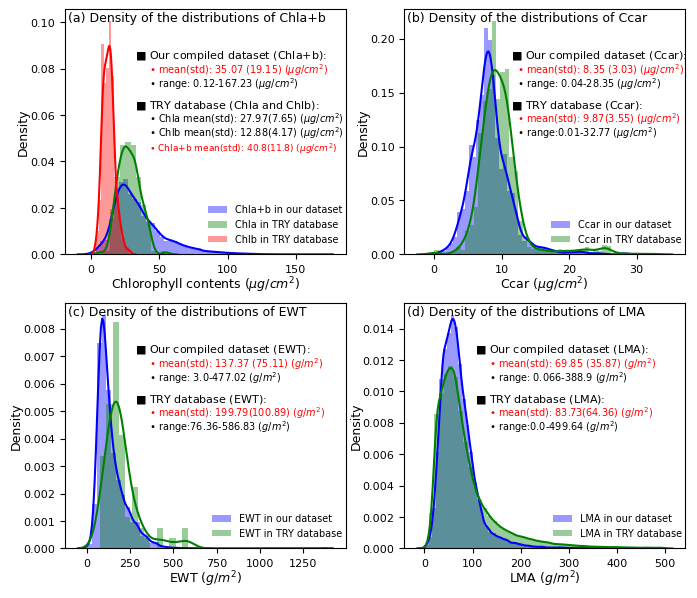

In [24]:
"""
Compare with Try database
"""
try_data = pd.read_table('../1_datasets/Try_database.txt',encoding = "ISO-8859-1")
try_data.columns
col = ['SpeciesName','TraitID', 'TraitName','DataName', 'OriglName','OrigValueStr', 'OrigUnitStr']
try_data = try_data[col]
try_data.dropna(subset=['TraitID'],inplace=True)
try_data.reset_index(drop = True, inplace = True)
try_data['TraitID'] = try_data['TraitID'].astype(int).astype(str)

#####
Chla_try = try_data[try_data['TraitID']=='3476']
Chlb_try = try_data[try_data['TraitID']=='3477']
Ccar_try = try_data[try_data['TraitID']=='491']
EWT_try = try_data[try_data['TraitID']=='3767']

SLA_try1 = try_data[try_data['TraitID']=='4083']
SLA_try2 = try_data[try_data['TraitID']=='3086']
SLA_try3 = try_data[try_data['TraitID']=='3115']
SLA_try4 = try_data[try_data['TraitID']=='3116']
SLA_try5 = try_data[try_data['TraitID']=='3117']

Chla_try['OrigValueStr'] = Chla_try['OrigValueStr'].astype(float)
Chlb_try['OrigValueStr'] = Chlb_try['OrigValueStr'].astype(float)
Ccar_try['OrigValueStr'] = Ccar_try['OrigValueStr'].astype(float)
EWT_try['OrigValueStr'] = EWT_try['OrigValueStr'].astype(float)
SLA_try1['OrigValueStr'] = SLA_try1['OrigValueStr'].astype(float)
SLA_try2['OrigValueStr'] = SLA_try2['OrigValueStr'].astype(float)

SLA_try3 = SLA_try3.drop(SLA_try3[SLA_try3['OrigValueStr']=='na'].index)
SLA_try4 = SLA_try4.drop(SLA_try4[SLA_try4['OrigValueStr']=='na'].index)
SLA_try5 = SLA_try5.drop(SLA_try5[(SLA_try5['OrigValueStr']=='/')|(SLA_try5['OrigValueStr']=='na')|
                                  (SLA_try5['OrigValueStr']=='.')|(SLA_try5['OrigValueStr']=='-')].index)

SLA_try3['OrigValueStr'] = SLA_try3['OrigValueStr'].astype(float)
SLA_try4['OrigValueStr'] = SLA_try4['OrigValueStr'].astype(float)
SLA_try5['OrigValueStr'] = SLA_try5['OrigValueStr'].astype(float)

#######
Chla_try.loc[Chla_try['OrigUnitStr']=='mmol / m²','Chla'] = 89.351*Chla_try['OrigValueStr']
Chla_try.loc[Chla_try['OrigUnitStr']=='mg m-2','Chla'] = 0.1*Chla_try['OrigValueStr']
Chlb_try.loc[Chlb_try['OrigUnitStr']=='mmol / m²','Chlb'] = 90.747*Chlb_try['OrigValueStr']
Chlb_try

Ccar_try.loc[Ccar_try['OrigUnitStr']=='mg m-2','Ccar'] = 0.1*Ccar_try['OrigValueStr']
Ccar_try.loc[Ccar_try['OrigUnitStr']=='ug cm-2','Ccar'] = Ccar_try['OrigValueStr']
Ccar_try.loc[Ccar_try['OrigUnitStr']=='micro g / cm2','Ccar'] = Ccar_try['OrigValueStr']
Ccar_try.loc[Ccar_try['OrigUnitStr']=='micro g/cm²','Ccar'] = Ccar_try['OrigValueStr']
Ccar_try.loc[Ccar_try['OrigUnitStr']=='µg/cm²','Ccar'] = Ccar_try['OrigValueStr']
Ccar_try.loc[Ccar_try['OrigUnitStr']=='mg/dm2','Ccar'] = 10*Ccar_try['OrigValueStr']
Ccar_try.loc[Ccar_try['OrigUnitStr']=='umol/m2','Ccar'] = 0.053687*Ccar_try['OrigValueStr']

EWT_try['EWT'] = 10000*EWT_try['OrigValueStr']
SLA_try1['LMA'] = SLA_try1['OrigValueStr']
SLA_try2.loc[SLA_try2['OrigUnitStr']=='g/m2','LMA'] = SLA_try2['OrigValueStr']
SLA_try2.loc[SLA_try2['OrigUnitStr']=='cm2/g','LMA'] = 10000*(1/SLA_try2['OrigValueStr'])
SLA_try2.loc[SLA_try2['OrigUnitStr']=='m2 kg-1','LMA'] = 1000*(1/SLA_try2['OrigValueStr'])
SLA_try2.loc[SLA_try2['OrigUnitStr']=='mm2 mg-1','LMA'] = 1000*(1/SLA_try2['OrigValueStr'])
SLA_try2.loc[SLA_try2['OrigUnitStr']=='cm²/g','LMA'] = 10000*(1/SLA_try2['OrigValueStr'])

SLA_try3.loc[SLA_try3['OrigUnitStr']=='mm2/mg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mg/dm2','LMA'] = 0.1*SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='g/m2','LMA'] = SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm2/g','LMA'] = 10000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m2/kg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='g m-2','LMA'] = SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mm2 / mg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mm2 mg-1','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m² Kg-1','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mg/cm2','LMA'] = 10*SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm2 / g','LMA'] = 10000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m2 kg-1','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m2kg-1','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='(m² kg-1)','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='g cm-2','LMA'] = 10000*SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm2 g-1','LMA'] = 10000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mm^2/mg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm2/mg','LMA'] = 10*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='g.m2','LMA'] = SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm2mg-1','LMA'] = 10*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mm2·mg-1','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm2·g-1','LMA'] = 10000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m2/g','LMA'] = 1/SLA_try3['OrigValueStr']
SLA_try3.loc[SLA_try3['OrigUnitStr']=='cm²/g','LMA'] = 10000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']==' cm2 g-1','LMA'] = 10000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m² kg-1','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='without petiole, mm²/mg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='m^2/kg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])
SLA_try3.loc[SLA_try3['OrigUnitStr']=='mm²/mg','LMA'] = 1000*(1/SLA_try3['OrigValueStr'])

SLA_try4.loc[SLA_try4['OrigUnitStr']=='cm2/g','LMA'] = 10000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2/mg','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2 / mg','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='m2/kg','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='m² Kg-1','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='m²/kg','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='m2 kg-1','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='m2/kg leaf DM','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2/g','LMA'] = 10**6*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2 mg-1','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2 g-1','LMA'] = 10**6*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='g/m2','LMA'] = SLA_try4['OrigValueStr']
SLA_try4.loc[SLA_try4['OrigUnitStr']=='g m-2','LMA'] = SLA_try4['OrigValueStr']
SLA_try4.loc[SLA_try4['OrigUnitStr']=='(m² kg-1)','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='g/cm2','LMA'] = 10000*SLA_try4['OrigValueStr']
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2*mg-1','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm²/mg','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='cm2/g (n.r.)','LMA'] = 10000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm^2/mg','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='cm2 g-1','LMA'] = 10000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='gDM m-2','LMA'] = SLA_try4['OrigValueStr']
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2mg-1','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='cm2 / g','LMA'] = 10000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='m2/g','LMA'] = 1/SLA_try4['OrigValueStr']
SLA_try4.loc[SLA_try4['OrigUnitStr']=='(cm2/g)','LMA'] = 10000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='(mm2 mg-1)/10','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='mm2  mg-1','LMA'] = 1000*(1/SLA_try4['OrigValueStr'])
SLA_try4.loc[SLA_try4['OrigUnitStr']=='cm²g-1','LMA'] = 10000*(1/SLA_try4['OrigValueStr'])

SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2/mg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='g/m2','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m2/g','LMA'] = 1/SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mg/cm2','LMA'] = 10*SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m2 kg-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2/g','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='(m² kg-1)','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2/mg','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m2/kg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='g/cm2','LMA'] = 10000*SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m2 g-1','LMA'] = 1/SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2mg-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2 g-1','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2.g-1','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m^2*kg^-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='g m2','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2 / mg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m2 / kg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2/g','LMA'] = 10**6*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2 mg-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='g/m^2','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='gm-2','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='g m-2','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']==' g/m2','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='(g m-2)','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2*g-1','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m2/Kg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='m²/kg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='SLA cm2/g','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2*mg-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mg/mm2','LMA'] =1000*SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm² mg-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm²/mg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm^2 g^-1','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2 mg-1','LMA'] = 10*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2/ g','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mg mm-2','LMA'] = 1000*SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm^2/g','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']==' g m-2 ','LMA'] = SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2/gDW','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='(g/cm2)','LMA'] = 10000*SLA_try5['OrigValueStr']
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm^2/mg','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='mm2/mg-1','LMA'] = 1000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='(cm2 g-1)','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])
SLA_try5.loc[SLA_try5['OrigUnitStr']=='cm2·g-1','LMA'] = 10000*(1/SLA_try5['OrigValueStr'])

Chla_try.dropna(subset=['Chla'],inplace=True)
Chlb_try.dropna(subset=['Chlb'],inplace=True)
Ccar_try.dropna(subset=['Ccar'],inplace=True)
EWT_try.dropna(subset=['EWT'],inplace=True)

SLA_try1.dropna(subset=['LMA'],inplace=True)
SLA_try2.dropna(subset=['LMA'],inplace=True)
SLA_try3.dropna(subset=['LMA'],inplace=True)
SLA_try4.dropna(subset=['LMA'],inplace=True)
SLA_try5.dropna(subset=['LMA'],inplace=True)

SLA_try1 = SLA_try1[SLA_try1['LMA']<500]
SLA_try2 = SLA_try2[SLA_try2['LMA']<500]
SLA_try3 = SLA_try3[SLA_try3['LMA']<500]
SLA_try4 = SLA_try4[SLA_try4['LMA']<500]
SLA_try5 = SLA_try5[SLA_try5['LMA']<500]
all_LMA_try = pd.concat([SLA_try1,SLA_try2,SLA_try3,SLA_try4,SLA_try5])

dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]
Cab_frame = traits[traits['Chla+b']>0]
Ccar_frame = traits[traits['Ccar']>0]
EWT_frame = traits[traits['EWT']>0]
LMA_frame = traits[traits['LMA']>0]

#######
units1 = ' ($\mu g/cm^2$)'
units2 = ' ($g/m^2$)'
tr1 = 'Chla+b'
tr2 = 'Ccar'
tr3 = 'EWT'
tr4 = 'LMA'

fig,[(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2, figsize = (8,7))
plt.subplots_adjust(wspace =0.21)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)
###
sns.distplot(Cab_frame['Chla+b'],color='b',ax=ax1,label="Chla+b in our dataset")
sns.distplot(Chla_try['Chla'],color='g',ax=ax1,label="Chla in TRY database")
sns.distplot(Chlb_try['Chlb'],color='r',ax=ax1,label="Chlb in TRY database")
###
sns.distplot(Ccar_frame['Ccar'],color='b',ax=ax2,label="Ccar in our dataset")
sns.distplot(Ccar_try['Ccar'],color='g',ax=ax2,label="Ccar in TRY database")
###
sns.distplot(EWT_frame['EWT'],color='b',ax=ax3,label="EWT in our dataset")
sns.distplot(EWT_try['EWT'],color='g',ax=ax3,label="EWT in TRY database")
###
sns.distplot(LMA_frame['LMA'],color='b',ax=ax4,label="LMA in our dataset")
sns.distplot(all_LMA_try['LMA'],color='g',ax=ax4,label="LMA in TRY database")

ax1.set_xlabel('Chlorophyll contents'+units1, fontsize=9, labelpad = 0.2)
ax1.set_ylabel('Density', fontsize=9, labelpad = 0.2)
ax2.set_xlabel('Ccar'+units1, fontsize=9, labelpad = 0.2)
ax2.set_ylabel('Density', fontsize=9, labelpad = 0.2)
ax3.set_xlabel('EWT'+units2, fontsize=9, labelpad = 0.2)
ax3.set_ylabel('Density', fontsize=9, labelpad = 0.2)
ax4.set_xlabel('LMA'+units2, fontsize=9, labelpad = 0.2)
ax4.set_ylabel('Density', fontsize=9, labelpad = 0.2)

ax1.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)
ax3.tick_params(labelsize=8)
ax4.tick_params(labelsize=8)
ax1.legend(loc = 'lower right',fontsize = 7,facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1.02, 0.005))
ax2.legend(loc = 'lower right',fontsize = 7,facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1.02, 0.005))
ax3.legend(loc = 'lower right',fontsize = 7,facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1.02, 0.005))
ax4.legend(loc = 'lower right',fontsize = 7,facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1.02, 0.005))
ax1.text(0.01,0.95, '(a) Density of the distributions of Chla+b', transform=ax1.transAxes, fontsize = 9)
ax2.text(0.01,0.95, '(b) Density of the distributions of Ccar', transform=ax2.transAxes, fontsize = 9)
ax3.text(0.01,0.95, '(c) Density of the distributions of EWT', transform=ax3.transAxes, fontsize = 9)
ax4.text(0.01,0.95, '(d) Density of the distributions of LMA', transform=ax4.transAxes, fontsize = 9)
###
a = Chla_try['Chla'].mean()
b = Chlb_try['Chlb'].mean()
c = Chla_try['Chla'].std()
d = Chlb_try['Chlb'].std()
ax1.text(0.25,0.8, r'$\blacksquare$ Our compiled dataset (Chla+b):', transform=ax1.transAxes, fontsize = 8)
ax1.text(0.3,0.74, r'$\bullet$ mean(std): 35.07 (19.15)'+units1, transform=ax1.transAxes, fontsize = 7,color = 'r')
ax1.text(0.3,0.68, r'$\bullet$ range: 0.12-167.23'+units1 , transform=ax1.transAxes, fontsize = 7)
ax1.text(0.25,0.6, r'$\blacksquare$ TRY database (Chla and Chlb):', transform=ax1.transAxes, fontsize = 8)
ax1.text(0.3,0.54, r'$\bullet$ Chla mean(std): '+str(round(a,2))+'('+str(round(c,2))+')'+units1, transform=ax1.transAxes, fontsize = 7)
ax1.text(0.3,0.48, r'$\bullet$ Chlb mean(std): '+str(round(b,2))+'('+str(round(d,2))+')'+units1 , transform=ax1.transAxes, fontsize = 7)
ax1.text(0.3,0.42, r'$\bullet$ Chla+b mean(std): '+str(round(a+b,1))+'('+str(round(c+d,1))+')'+units1, transform=ax1.transAxes, fontsize = 6.5,color = 'r')

a = Ccar_try['Ccar'].mean()
b = Ccar_try['Ccar'].std()
c = Ccar_try['Ccar'].min()
d = Ccar_try['Ccar'].max()
ax2.text(0.38,0.8, r'$\blacksquare$ Our compiled dataset (Ccar):', transform=ax2.transAxes, fontsize = 8)
ax2.text(0.4,0.74, r'$\bullet$ mean(std): 8.35 (3.03)'+units1, transform=ax2.transAxes, fontsize = 7,color = 'r')
ax2.text(0.4,0.68, r'$\bullet$ range: 0.04-28.35'+units1, transform=ax2.transAxes, fontsize = 7)

ax2.text(0.38,0.6, r'$\blacksquare$ TRY database (Ccar):', transform=ax2.transAxes, fontsize = 8)
ax2.text(0.4,0.54, r'$\bullet$ mean(std): '+str(round(a,2))+'('+str(round(b,2))+')'+units1, transform=ax2.transAxes, fontsize = 7,color = 'r')
ax2.text(0.4,0.48, r'$\bullet$ range:'+str(round(c,2))+'-'+str(round(d,2))+units1, transform=ax2.transAxes, fontsize = 7)

a = EWT_try['EWT'].mean()
b = EWT_try['EWT'].std()
c = EWT_try['EWT'].min()
d = EWT_try['EWT'].max()
ax3.text(0.25,0.8, r'$\blacksquare$ Our compiled dataset (EWT):', transform=ax3.transAxes, fontsize = 8)
ax3.text(0.3,0.74, r'$\bullet$ mean(std): 137.37 (75.11)'+units2, transform=ax3.transAxes, fontsize = 7,color = 'r')
ax3.text(0.3,0.68, r'$\bullet$ range: 3.0-477.02'+units2, transform=ax3.transAxes, fontsize = 7)
ax3.text(0.25,0.6, r'$\blacksquare$ TRY database (EWT):', transform=ax3.transAxes, fontsize = 8)
ax3.text(0.3,0.54, r'$\bullet$ mean(std): '+str(round(a,2))+'('+str(round(b,2))+')'+units2, transform=ax3.transAxes, fontsize = 7,color = 'r')
ax3.text(0.3,0.48, r'$\bullet$ range:'+str(round(c,2))+'-'+str(round(d,2))+units2, transform=ax3.transAxes, fontsize = 7)

a = all_LMA_try['LMA'].mean()
b = all_LMA_try['LMA'].std()
c = all_LMA_try['LMA'].min()
d = all_LMA_try['LMA'].max()
ax4.text(0.25,0.8, r'$\blacksquare$ Our compiled dataset (LMA):', transform=ax4.transAxes, fontsize = 8)
ax4.text(0.3,0.74, r'$\bullet$ mean(std): 69.85 (35.87)'+units2, transform=ax4.transAxes, fontsize = 7,color = 'r')
ax4.text(0.3,0.68, r'$\bullet$ range: 0.066-388.9'+units2, transform=ax4.transAxes, fontsize = 7)
ax4.text(0.25,0.6, r'$\blacksquare$ TRY database (LMA):', transform=ax4.transAxes, fontsize = 8)
ax4.text(0.3,0.54, r'$\bullet$ mean(std): '+str(round(a,2))+'('+str(round(b,2))+')'+units2, transform=ax4.transAxes, fontsize = 7,color = 'r')
ax4.text(0.3,0.48, r'$\bullet$ range:'+str(round(c,2))+'-'+str(round(d,2))+units2, transform=ax4.transAxes, fontsize = 7)
plt.savefig('../3_figures/Fig S6_traits_variations_S1_compared with TRY.png', dpi=500, bbox_inches='tight')

### 1.3 leaf spectra variations

In [15]:
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
dataset = pd.read_csv(dataset)
all_refl = dataset.loc[:,"450":"2400"]
traits = dataset.loc[:, "Dataset ID":]

def mean_refl(ax,data,color,title):
    wl_min = '450'
    wl_max = '2400'
    d_all = data.loc[:,wl_min:].values
    m_all = np.mean(d_all,0)
    std_all = np.std(d_all,0)
    
    lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
    wl = np.arange(int(wl_min),int(wl_max)+1,10)
    
    ax.fill_between(wl, lc_all,hc_all, alpha=0.3,color = color,label = '95% CI')
    ax.plot(wl,m_all,linewidth=2,c = color,label = 'mean reflectance')
    
    ax.legend(loc = 'upper right',fontsize = 8)
    ax.set_xlabel('Wavelength (nm)',fontsize = 10,labelpad = 0.1)
    ax.set_ylabel('Reflectance',fontsize = 10)
    ax.text(0.015,0.93, f'{title} Reflectance of {tr}', transform=ax.transAxes, fontsize = 9,fontweight = 'bold')
    return

def refl_vis_sites(ax,data,types,tr,legend_ncol,legend_fontsize,title):
    wl_min = '450'
    wl_max = '2400'
    d_all = data.loc[:,wl_min:].values
    m_all = np.mean(d_all,0)
    std_all = np.std(d_all,0)
    
    lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
    wl = np.arange(int(wl_min),int(wl_max)+1,10)
    
    ax.plot(wl,m_all,linewidth=2,c = 'b')
    ax.fill_between(wl, lc_all,hc_all, alpha=0.3,color = 'b',label = 'mean reflectance')
    
    colors = distinctipy.get_colors(len(types)) 
    j = 0
    for i in types:
        temp = data[data['Site ID']==i]
        d = temp.loc[:,wl_min:].values
        m = np.mean(d,0)
        std = np.std(d,0)
        lc,hc = m-1.96*std,m+1.96*std
        ax.plot(wl,m,linewidth=1)
        ax.fill_between(wl, lc,hc, alpha=0.2,label = i[4:],color = colors[j])
        j = j+1
    
    ax.legend(loc = 'lower right',fontsize = legend_fontsize,ncol = legend_ncol,columnspacing = 0.4)
    ax.set_xlabel('Wavelength (nm)',fontsize = 10,labelpad = 0.1)
    ax.set_ylabel('Reflectance',fontsize = 10)
    ax.text(0.015,0.93, f'{title} Reflectance of {tr}', transform=ax.transAxes, fontsize = 10,fontweight = 'bold')
    return

def refl_vis_PFTs(ax,data,types,tr,title):
    labels = {'Croplands':'CRP','Deciduous broadleaf forests':'DBF','Deciduous needleleaf forests':'DNF',
              'Evergreen broadleaf forests':'EBF','Evergreen needleleaf forests':'ENF','Grasslands':'GRA',
              'Shrublands':'SHR','Vine':'Vine'}
    
    wl_min = '450'
    wl_max = '2400'
    d_all = data.loc[:,wl_min:].values
    m_all = np.mean(d_all,0)
    std_all = np.std(d_all,0)
    
    lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
    wl = np.arange(int(wl_min),int(wl_max)+1,10)
    
    ax.plot(wl,m_all,linewidth=2,c = 'b')
    ax.fill_between(wl, lc_all,hc_all, alpha=0.3,color = 'b',label = 'mean reflectance')
    
    colors = distinctipy.get_colors(len(types)) 
    j = 0
    for i in types:
        temp = data[data['PFT']==i]
        d = temp.loc[:,wl_min:].values
        m = np.mean(d,0)
        std = np.std(d,0)
        lc,hc = m-1.96*std,m+1.96*std
        ax.plot(wl,m,linewidth=1)
        ax.fill_between(wl, lc,hc, alpha=0.2,label = labels[i],color = colors[j])
        j = j+1
    
    ax.legend(loc = 'lower right',fontsize = 6.5,ncol = 9,columnspacing = 0.4)
    ax.set_xlabel('Wavelength (nm)',fontsize = 10,labelpad = 0.1)
    ax.set_ylabel('Reflectance',fontsize = 10)
    ax.text(0.015,0.93, f'{title} Reflectance of {tr}', transform=ax.transAxes, fontsize = 10,fontweight = 'bold')
    return

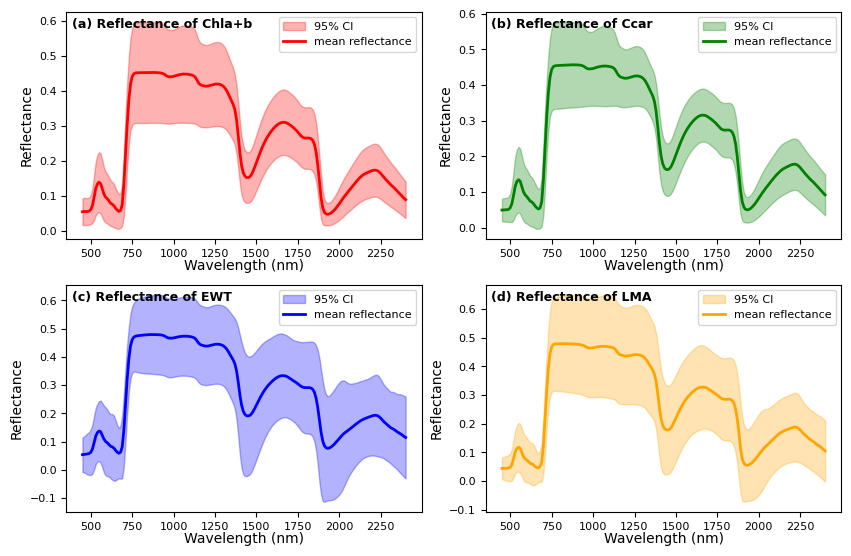

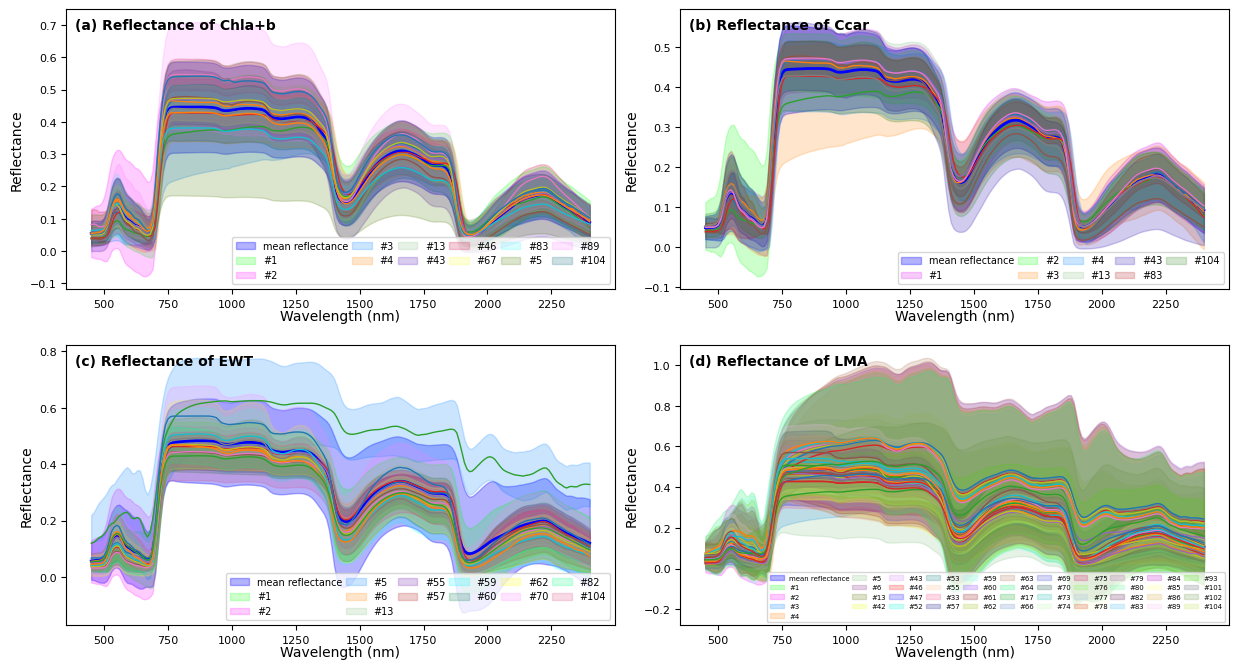

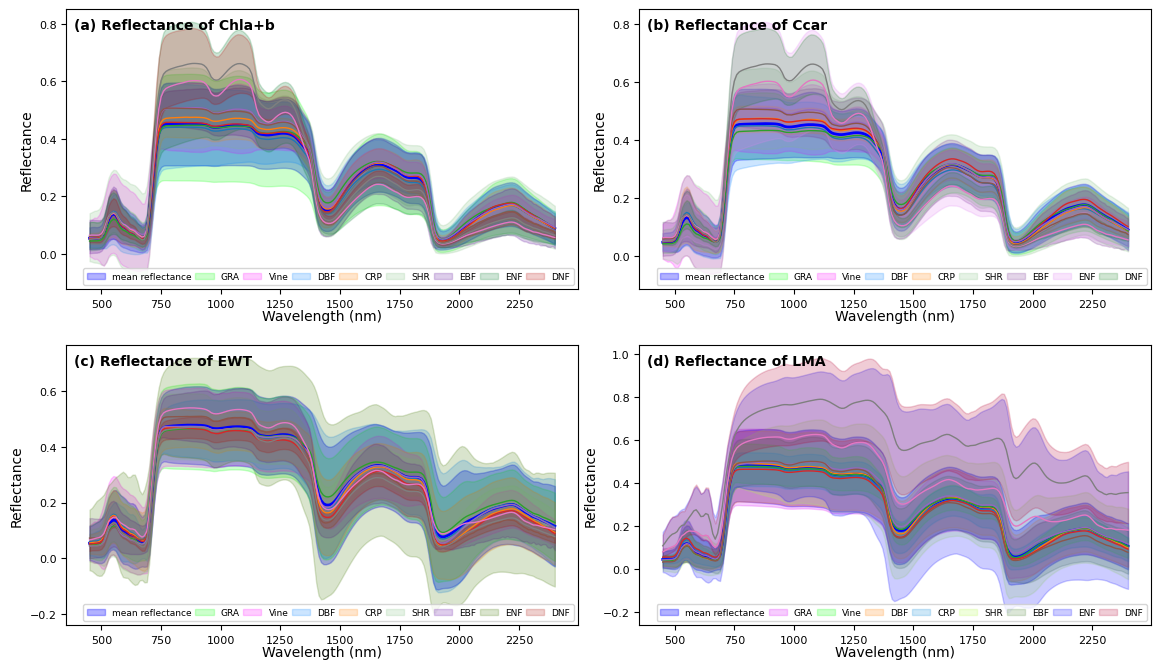

In [23]:
"""
Leaf spectra variations mean
"""
fig,ax = plt.subplots(2,2,figsize = (10,6.5))
plt.subplots_adjust(wspace =0.18,hspace =0.2)
trait_name = ['Chla+b','Ccar','EWT','LMA']

for tr in trait_name:
    if tr=='Chla+b':
        k,j,title,color = 0,0,'(a)','r'
    if tr=='Ccar':
        k,j,title,color= 0,1,'(b)','g'
    if tr=='EWT':
        k,j,title,color= 1,0,'(c)','b'
    if tr=='LMA':
        k,j,title,color= 1,1,'(d)','orange'
    
    frame = traits[traits[tr]>0][['Site ID','PFT']]
    refl = all_refl.iloc[frame.index].loc[:,'450':'2400']
    refl = pd.concat([frame,refl],axis = 1)
    refl.reset_index(drop = True,inplace = True)
    
    mean_refl(ax[k][j],refl,color,title)
plt.savefig('../3_figures/Fig S7_leaf spectra variation_mean.png', dpi=500, bbox_inches='tight')

"""
Leaf spectra variations across sites
"""

fig,ax = plt.subplots(2,2,figsize = (15,8))
plt.subplots_adjust(wspace =0.12)
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    if tr=='Chla+b':
        k,j,legend_ncol,legend_fontsize,title = 0,0,6,7,'(a)'
    if tr=='Ccar':
        k,j,legend_ncol,legend_fontsize,title= 0,1,5,7,'(b)'
    if tr=='EWT':
        k,j,legend_ncol,legend_fontsize,title= 1,0,6,7,'(c)'
    if tr=='LMA':
        k,j,legend_ncol,legend_fontsize ,title= 1,1,11,5,'(d)'
    frame = traits[traits[tr]>0][['Site ID','PFT']]
    refl = all_refl.iloc[frame.index].loc[:,'450':'2400']
    refl = pd.concat([frame,refl],axis = 1)
    refl.reset_index(drop = True,inplace = True)
    s = s_filter(refl)
    specra = refl.loc[refl['Site ID'].isin(s)]
    refl_vis_sites(ax[k][j],specra,s,tr,legend_ncol,legend_fontsize,title)
plt.savefig('../3_figures/Fig S8_leaf spectra variation_sites.png', dpi=500, bbox_inches='tight')


"""
Leaf spectra variations across PFTs
"""
fig,ax = plt.subplots(2,2,figsize = (14,8))
plt.subplots_adjust(wspace =0.12)
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    if tr=='Chla+b':
        k,j,title = 0,0,'(a)'
    if tr=='Ccar':
        k,j,title= 0,1,'(b)'
    if tr=='EWT':
        k,j,title= 1,0,'(c)'
    if tr=='LMA':
        k,j,title= 1,1,'(d)'
    frame = traits[traits[tr]>0][['Site ID','PFT']]
    refl = all_refl.iloc[frame.index].loc[:,'450':'2400']
    refl = pd.concat([frame,refl],axis = 1)
    refl.reset_index(drop = True,inplace = True)
    p = p_filter(refl)
    specra = refl.loc[refl['PFT'].isin(p)]
    refl_vis_PFTs(ax[k][j],specra,p,tr,title)
plt.savefig('../3_figures/Fig S9_leaf spectra variation_PFTs.png', dpi=500, bbox_inches='tight')

In [17]:
def Shannon_index(df):
    df_mean = df.mean()
    pi = df_mean/df_mean.sum()
    ln_pi = np.log(pi)
    H = -sum(pi*ln_pi)
    return H
def CV_curve(df):
    CV = df.std()/df.mean()
    return CV
def CV(df):
    CV = (df.std()/df.mean()).sum()/df.shape[1]
    return CV
def alpha_metrics(df,sites,wl_min,prop):
    alpha_diversity = pd.DataFrame(np.zeros(shape = (0,2)),columns = ['H','CV'])
    alpha_CV_curve = pd.DataFrame(np.zeros(shape = (0,df.loc[:,wl_min:].shape[1])),columns = df.loc[:,wl_min:].columns)
    for i in sites:
        temp = df[df[prop]==i]
        data = temp.loc[:,wl_min:]
        H = Shannon_index(data)
        cv_cur = CV_curve(data)
        cv = CV(data)
        
        res = pd.DataFrame(np.array([H,cv])).T
        res.columns = ['H','CV']
        res.index = [i]
        
        curve = pd.DataFrame(cv_cur).T
        curve.index = [i]
        
        alpha_diversity = pd.concat([alpha_diversity,res])
        alpha_CV_curve = pd.concat([alpha_CV_curve,curve])
    return [alpha_diversity,alpha_CV_curve]

Index(['ENF', 'SHR', 'EBF', 'DBF', 'GRA', 'Vine', 'CRP', 'DNF'], dtype='object')
Index(['ENF', 'SHR', 'GRA', 'EBF', 'DNF', 'DBF', 'CRP', 'Vine'], dtype='object')
Index(['ENF', 'SHR', 'EBF', 'DBF', 'GRA', 'DNF', 'CRP', 'Vine'], dtype='object')


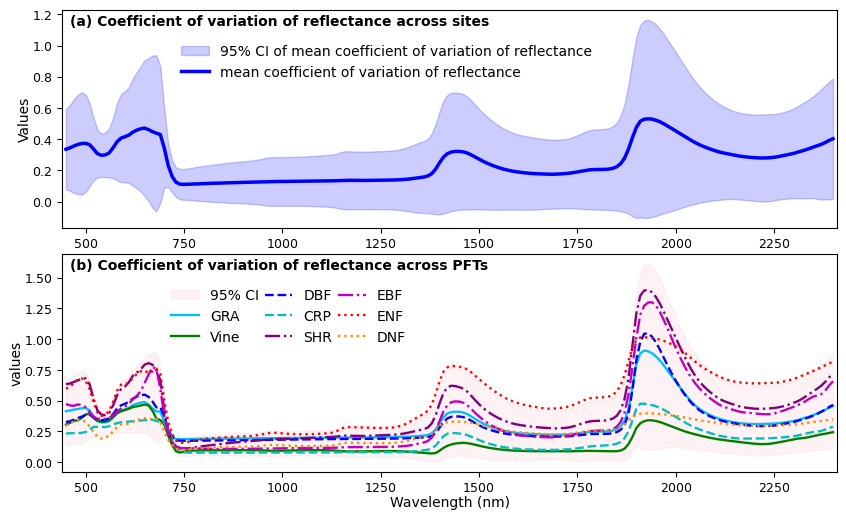

In [18]:
"""
coefficient of variations of leaf spectra
"""

Site_PFTs = traits[['Site ID','PFT']]
leaf_spectra = all_refl.iloc[Site_PFTs.index]
leaf_spectra = leaf_spectra.loc[:,'450':'2400']

df = pd.concat([Site_PFTs,leaf_spectra],axis = 1)
df.reset_index(drop = True,inplace = True)

s = s_filter(df)
p = p_filter(df)

df_sites = df.loc[df['Site ID'].isin(s)]
df_pfts = df.loc[df['PFT'].isin(p)]

# Alpha spectral diversity
aSD_site = alpha_metrics(df_sites,s,'450','Site ID')[1]
aSD_PFT = alpha_metrics(df_pfts,p,'450','PFT')[1]

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (10,6))
plt.subplots_adjust(hspace = 0.12)

d_all = aSD_site.values
dp_all = aSD_site.shape[1]
m_all = np.mean(d_all,0)
std_all = np.std(d_all,0)

lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
wl = np.arange(450,2401,10)

ax1.fill_between(wl, lc_all,hc_all, alpha=0.2,color = 'b',label = '95% CI of mean coefficient of variation of reflectance')
ax1.plot(wl,m_all,linewidth=2.5,c = 'b',label = 'mean coefficient of variation of reflectance')

#####
label = {'Croplands':'CRP','Deciduous broadleaf forests':'DBF','Deciduous needleleaf forests':'DNF',
         'Evergreen broadleaf forests':'EBF','Evergreen needleleaf forests':'ENF','Grasslands':'GRA',
         'Shrublands':'SHR','Vine':'Vine'}
color = ['deepskyblue','g','b','c','purple','m','r','darkorange']
linestyles = ['-','-','--','--','-.','-.',':',':']

d_all = aSD_PFT.values
dp_all = aSD_PFT.shape[1]
m_all = np.mean(d_all,0)
std_all = np.std(d_all,0)
lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
ax2.fill_between(wl, lc_all,hc_all, alpha=0.2,color = 'pink',label = '95% CI')

k = 0
for i in aSD_PFT.index:
    x = range(450,2401,10)
    y = aSD_PFT.loc[i]['450':'2400']
    ax2.plot(x,y,lw = 1.7,c = color[k],ls = linestyles[k], label = label[i])
    k = k+1

ax1.set_xlim(440,2410)  
ax2.set_xlim(440,2410)
ax1.legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize=10,bbox_to_anchor=(0.7, 0.9))
ax2.legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize=10,ncol = 3,columnspacing = 0.4,bbox_to_anchor=(0.46, 0.9))

ax1.text(0.01,0.93, '(a) Coefficient of variation of reflectance across sites', transform=ax1.transAxes, fontsize = 10,fontweight='bold')
ax2.text(0.01,0.93, '(b) Coefficient of variation of reflectance across PFTs', transform=ax2.transAxes, fontsize = 10,fontweight='bold')

ax1.set_ylabel('Values', fontsize=10, labelpad = 0.2)
ax2.set_ylabel('values', fontsize=10, labelpad = 0.2)
ax2.set_xlabel('Wavelength (nm)', fontsize=10, labelpad = 0.2)

ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
plt.savefig('../3_figures/Fig 3_CV of reflectance.png', dpi=500, bbox_inches='tight')

"""
CV of leaf spectra statistics
"""
t1 = aSD_PFT.loc[:,'450':'750'].mean(axis = 1)
t2 = aSD_PFT.loc[:,'1300':'1800'].mean(axis = 1)
t3 = aSD_PFT.loc[:,'1800':'2400'].mean(axis = 1)

t1 = pd.DataFrame(t1,columns = ['VIS (450-750 nm)'])
t2 = pd.DataFrame(t2,columns = ['SWIR1 (1300-1800 nm)'])
t3 = pd.DataFrame(t3,columns = ['SWIR2 (1800-2400 nm)'])
temp = pd.concat([t1,t2,t3],axis = 1)
temp.index = ['GRA','Vine','DBF','CRP','SHR','EBF','ENF','DNF']

temp.to_csv('../3_figures/Table S5_leaf spectra_CV.csv')
print(temp.sort_values(by = ['VIS (450-750 nm)'],ascending=False).index)
print(temp.sort_values(by = ['SWIR1 (1300-1800 nm)'],ascending=False).index)
print(temp.sort_values(by = ['SWIR2 (1800-2400 nm)'],ascending=False).index)

### 1.4 Spectral diversity

In [25]:
## alpha diversity: Shannon index H′
def Shannon_index(df):
    df_mean = df.mean()
    pi = df_mean/df_mean.sum()
    ln_pi = np.log(pi)
    H = -sum(pi*ln_pi)
    return H

## Beta diversity: Bray-Curtis index
def BC_index(df1,df2):
    df1_mean = df1.mean()
    df2_mean = df2.mean()

    xi = df1_mean/df1_mean.sum()
    xj = df2_mean/df2_mean.sum()
    BC = abs(xi-xj).sum()/(xi+xj).sum()
    return BC
def CV_curve(df):
    CV = df.std()/df.mean()
    return CV
def CV(df):
    CV = (df.std()/df.mean()).sum()/df.shape[1]
    return CV
def alpha_metrics(df,sites,wl_min,prop):
    alpha_diversity = pd.DataFrame(np.zeros(shape = (0,2)),columns = ['H','CV'])
    alpha_CV_curve = pd.DataFrame(np.zeros(shape = (0,df.loc[:,wl_min:].shape[1])),columns = df.loc[:,wl_min:].columns)
    for i in sites:
        temp = df[df[prop]==i]
        data = temp.loc[:,wl_min:]
        H = Shannon_index(data)
        cv_cur = CV_curve(data)
        cv = CV(data)
        
        res = pd.DataFrame(np.array([H,cv])).T
        res.columns = ['H','CV']
        res.index = [i]
        
        curve = pd.DataFrame(cv_cur).T
        curve.index = [i]
        
        alpha_diversity = pd.concat([alpha_diversity,res])
        alpha_CV_curve = pd.concat([alpha_CV_curve,curve])
    return [alpha_diversity,alpha_CV_curve]

def Beta_metric(df1,df2,wl_min,prop):
    site_combi = df1.iloc[:,0:2].apply(tuple,axis = 1)
    BC = []
    for i in site_combi:
        x = i[0]
        y = i[1]
        
        a = df2.loc[df2[prop] == x]
        b = df2.loc[df2[prop] == y]
        a = a.loc[:,wl_min:]
        b = b.loc[:,wl_min:]
        
        BC_metric = BC_index(a,b)
        BC.append(BC_metric)
    
    accuracy = df1.copy()
    accuracy['BC_index'] = BC
    return accuracy
def d(x,y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    return z
def eculidDisSim(x,y):
    return math.sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

def spectral_diversity_similarity(df1,df2,wl_min,wl_max):
    site_combi = df1.iloc[:,0:2].apply(tuple,axis = 1)
    df2 = df2.loc[:,wl_min:wl_max]
    
    similarity = []
    for i in site_combi:
        x = i[0]
        y = i[1]
        a = df2.loc[x]
        b = df2.loc[y]
        
        simi = eculidDisSim(a,b)
        similarity.append(simi)
    accuracy = df1.copy()
    accuracy['similarity'] = similarity
    return accuracy

def SD_process(df,variable):
    df = df[(df['NRMSE']<1)&(df['NRMSE']>0)]
    p_25 = np.percentile(df[variable], 25)
    p_50 = np.percentile(df[variable], 50)
    p_75 = np.percentile(df[variable], 75)
    
    df.loc[(df[variable]<p_25)|(df[variable] == p_25),'category'] = 'low'
    df.loc[(df[variable]>p_75)|(df[variable] == p_75),'category'] = 'high'
    df.loc[(df[variable]>p_25)&(df[variable]<p_50)|(df[variable] == p_50),'category'] = 'relative low'
    df.loc[(df[variable]>p_50)&(df[variable]<p_75),'category'] = 'relative high'
    
    df.loc[df['category'] == 'low','sort'] = 1
    df.loc[df['category'] == 'relative low','sort'] = 2
    df.loc[df['category'] == 'relative high','sort'] = 3
    df.loc[df['category'] == 'high','sort'] = 4
    df.sort_values(by='sort',inplace = True)
    df['NRMSE'] = df['NRMSE']*100
    return df

dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
dataset = pd.read_csv(dataset)
all_refl = dataset.loc[:,"450":"2400"]
traits = dataset.loc[:, "Dataset ID":]

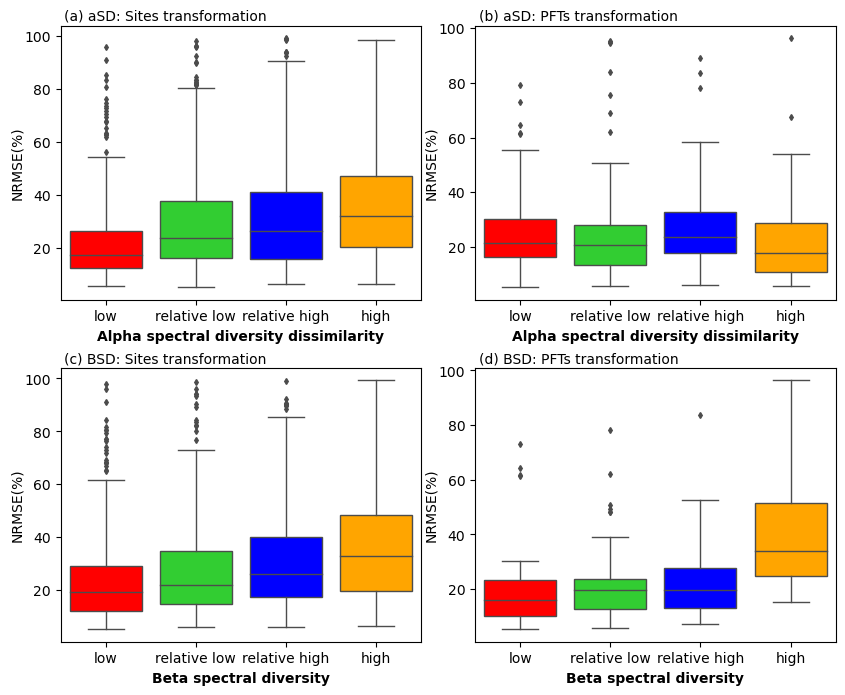

In [27]:
"""
The relationship between spectral diversity and PLSR transferability.
"""

trait_name = ['Chla+b','Ccar','EWT','LMA']
start_var = True
for tr in trait_name:
    frame = traits[traits[tr]>0][['Site ID','PFT']]
    refl = all_refl.iloc[frame.index].loc[:,'450':'2400']
    refl = pd.concat([frame,refl],axis = 1)
    refl.reset_index(drop = True,inplace = True)
    s,p = s_filter(refl), p_filter(refl)
    
    specra1 = refl.loc[refl['Site ID'].isin(s)]
    specra2 = refl.loc[refl['PFT'].isin(p)]
    d1 = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_site_accuracy.csv')
    d2 = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_PFT_accuracy.csv')
    
    Beta_SD_site = Beta_metric(d1,specra1,'450','Site ID')
    Beta_SD_PFT = Beta_metric(d2,specra2,'450','PFT')
    
    alpha_SD_site = alpha_metrics(specra1,s,'450','Site ID')[1]
    alpha_SD_PFT = alpha_metrics(specra2,p,'450','PFT')[1]
    
    aSD_simi_site = spectral_diversity_similarity(d1,alpha_SD_site,'450','2400')
    aSD_simi_PFT = spectral_diversity_similarity(d2,alpha_SD_PFT,'450','2400')
    
    if start_var:
        BSD_site = Beta_SD_site
        BSD_PFT = Beta_SD_PFT
        
        aSD_simi_sites = aSD_simi_site
        aSD_simi_PFTs = aSD_simi_PFT
        start_var = False
    else:
        BSD_site = pd.concat([BSD_site,Beta_SD_site])
        BSD_PFT = pd.concat([BSD_PFT,Beta_SD_PFT])
        aSD_simi_sites = pd.concat([aSD_simi_sites,aSD_simi_site])
        aSD_simi_PFTs = pd.concat([aSD_simi_PFTs,aSD_simi_PFT])

a = SD_process(aSD_simi_sites,'similarity')
b = SD_process(aSD_simi_PFTs,'similarity')
c = SD_process(BSD_site,'BC_index')
d = SD_process(BSD_PFT,'BC_index')

fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize = (10,8))
config = {"font.family":'Calibri'}
plt.rcParams.update(config)
plt.subplots_adjust(wspace =0.15,hspace =0.25)

sns.boxplot(x='category', y= 'NRMSE',data=a, palette=['r','limegreen','b','orange'], ax = ax1,fliersize=3,saturation = 1,linewidth = 1, whis =2)
sns.boxplot(x='category', y= 'NRMSE',data=b, palette=['r','limegreen','b','orange'], ax = ax2,fliersize=3,saturation = 1,linewidth = 1, whis =2)
sns.boxplot(x='category', y= 'NRMSE',data=c, palette=['r','limegreen','b','orange'], ax = ax3,fliersize=3,saturation = 1,linewidth = 1, whis =2)
sns.boxplot(x='category', y= 'NRMSE',data=d, palette=['r','limegreen','b','orange'], ax = ax4,fliersize=3,saturation = 1,linewidth = 1, whis =2)

ax1.set_ylabel('NRMSE(%)', fontsize=10, labelpad = 0.2)
ax2.set_ylabel('NRMSE(%)', fontsize=10, labelpad = 0.2)
ax3.set_ylabel('NRMSE(%)', fontsize=10, labelpad = 0.2)
ax4.set_ylabel('NRMSE(%)', fontsize=10, labelpad = 0.2)


ax1.set_xlabel('Alpha spectral diversity dissimilarity', fontsize=10,fontweight="bold")
ax2.set_xlabel('Alpha spectral diversity dissimilarity', fontsize=10,fontweight="bold")
ax3.set_xlabel('Beta spectral diversity', fontsize=10,fontweight="bold")
ax4.set_xlabel('Beta spectral diversity', fontsize=10,fontweight="bold")

ax1.text(0.01,1.02, '(a) aSD: Sites transformation', transform=ax1.transAxes, fontsize = 10)
ax2.text(0.01,1.02, '(b) aSD: PFTs transformation', transform=ax2.transAxes, fontsize = 10)
ax3.text(0.01,1.02, '(c) BSD: Sites transformation', transform=ax3.transAxes, fontsize = 10)
ax4.text(0.01,1.02, '(d) BSD: PFTs transformation', transform=ax4.transAxes, fontsize = 10)

ax1.tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
ax3.tick_params(labelsize=10)
ax4.tick_params(labelsize=10)

plt.savefig('../3_figures/Fig 14_spectral diversity vs PLSR transformation.png', dpi=500, bbox_inches='tight')

### 1.5 seasonal trait and leaf spectra variations

In [19]:
"""
Seasonal trait variations
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
leaf_spectra, leaf_traits = seasonal_data_extraction(dataset)

leaf_traits['Month'] = [i[4:6] for i in leaf_traits['Sample date']]
leaf_traits.loc[leaf_traits['Dataset ID'] == 'Dataset#3','Datasets'] = 'Dataset ID 3'
leaf_traits.loc[leaf_traits['Dataset ID'] == 'Dataset#4','Datasets'] = 'Dataset ID 4'
leaf_traits.loc[leaf_traits['Dataset ID'] == 'Dataset#8','Datasets'] = 'Dataset ID 8'

leaf_spectra['Month'] = leaf_traits['Month']
leaf_spectra['season'] = leaf_traits['season']
leaf_spectra['Datasets ID'] = leaf_traits['Datasets']

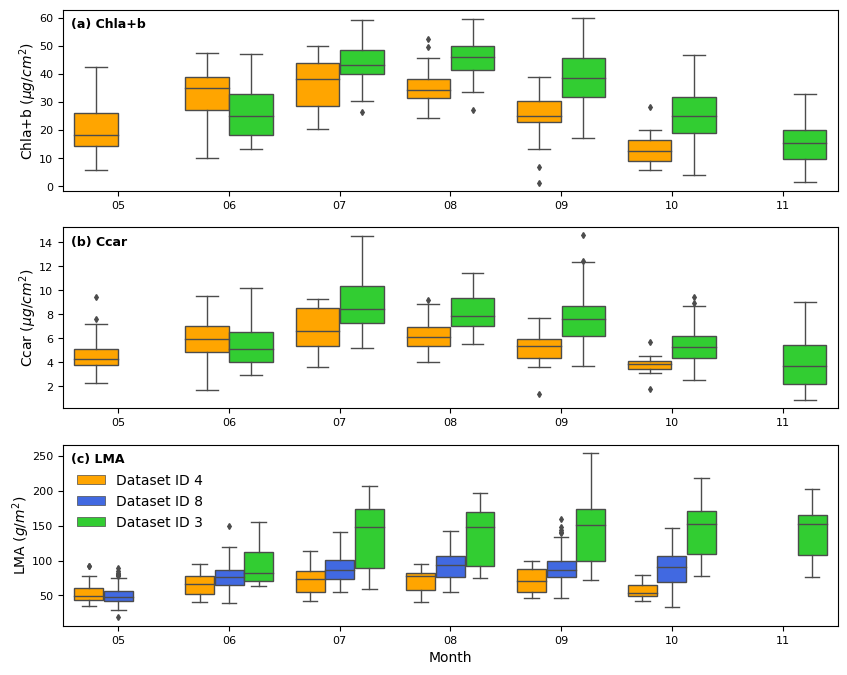

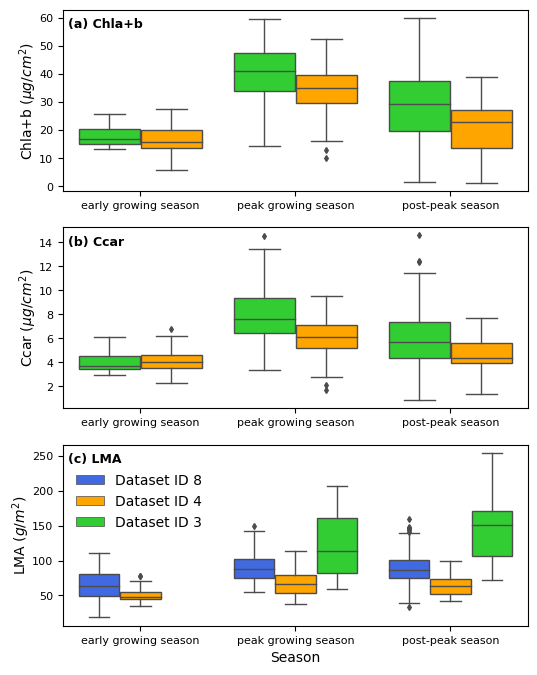

In [20]:
"""
trait variations divided by months
"""
trait_name = ['Chla+b','Ccar','LMA']
units = {'Chla+b':' ($\mu g/cm^2$)','Ccar':' ($\mu g/cm^2$)','EWT':' ($g/m^2$)','LMA':' ($g/m^2$)'}
colors = {'Chla+b':['orange','limegreen'],'Ccar':['orange','limegreen'],'LMA':['orange','royalblue','limegreen']}
title = {'Chla+b':'(a)','Ccar':'(b)','LMA':'(c)'}
fig,ax = plt.subplots(3,1,figsize = (10,8))
k = 0
for tr in trait_name:
    dataset = leaf_traits[leaf_traits[tr]>0]
    dataset.sort_values('Month',inplace=True)
    sns.boxplot(x= 'Month', y= tr,data=dataset, palette=colors[tr],hue = 'Datasets',ax = ax[k], fliersize=3,saturation = 1,linewidth = 1)
    ax[k].set_ylabel(tr+ units[tr], fontsize=10, labelpad = 0.2)
    ax[k].set_xlabel('',fontsize = 10)
    ax[k].legend('',fontsize = 10,facecolor= 'none',edgecolor = 'none')
    ax[k].text(0.01,0.9,f'{title[tr]} {tr}',transform=ax[k].transAxes, fontsize = 9,fontweight="bold")
    k = k+1

ax[2].set_xlabel('Month',fontsize = 10)
ax[2].legend(loc = 'upper left',facecolor= 'none',edgecolor = 'none',fontsize=10,bbox_to_anchor=(0.002, 0.91))
plt.savefig('../3_figures/Fig S4_seasonal trait variations_Month.png', dpi=500, bbox_inches='tight') 

"""
trait variations divided by seasons
"""
colors = {'Chla+b':['limegreen','orange'],'Ccar':['limegreen','orange'],'LMA':['royalblue','orange','limegreen']}
fig,ax = plt.subplots(3,1,figsize = (6,8))
k = 0
for tr in trait_name:
    dataset = leaf_traits[leaf_traits[tr]>0]
    dataset.sort_values('season',inplace=True)
    sns.boxplot(x= 'season', y= tr,data=dataset, palette=colors[tr],hue = 'Datasets',ax = ax[k], fliersize=3,saturation = 1,linewidth = 1)
    ax[k].set_ylabel(tr+ units[tr], fontsize=10, labelpad = 0.2)
    ax[k].set_xlabel('',fontsize = 10)
    ax[k].legend('',fontsize = 10,facecolor= 'none',edgecolor = 'none')
    ax[k].text(0.01,0.9,f'{title[tr]} {tr}',transform=ax[k].transAxes, fontsize = 9,fontweight="bold")
    k = k+1

ax[2].set_xlabel('Season',fontsize = 10)
ax[2].legend(loc = 'upper left',facecolor= 'none',edgecolor = 'none',fontsize=10,bbox_to_anchor=(0.002, 0.91))
plt.savefig('../3_figures/Fig S5_seasonal trait variations_season.png', dpi=500, bbox_inches='tight') 

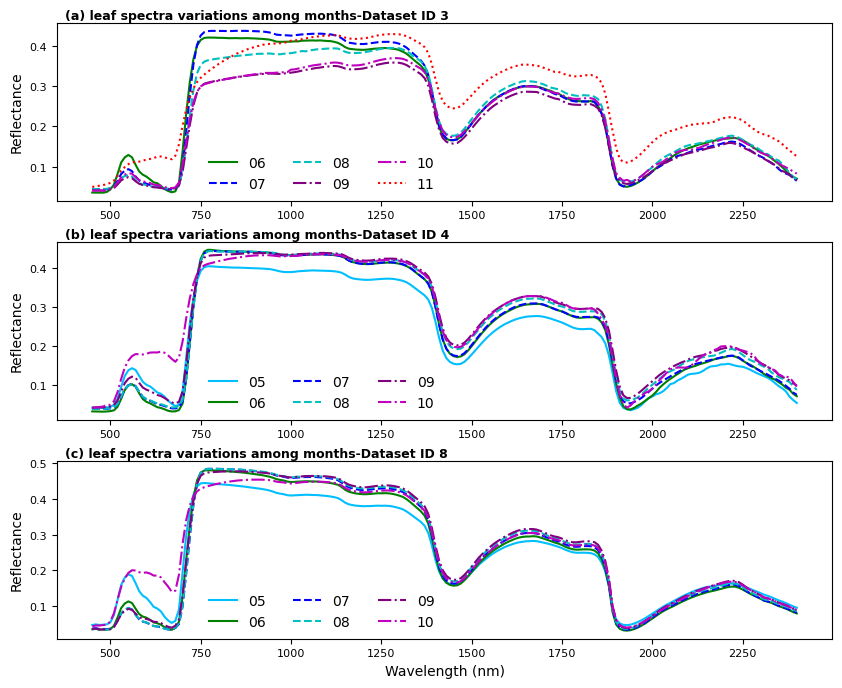

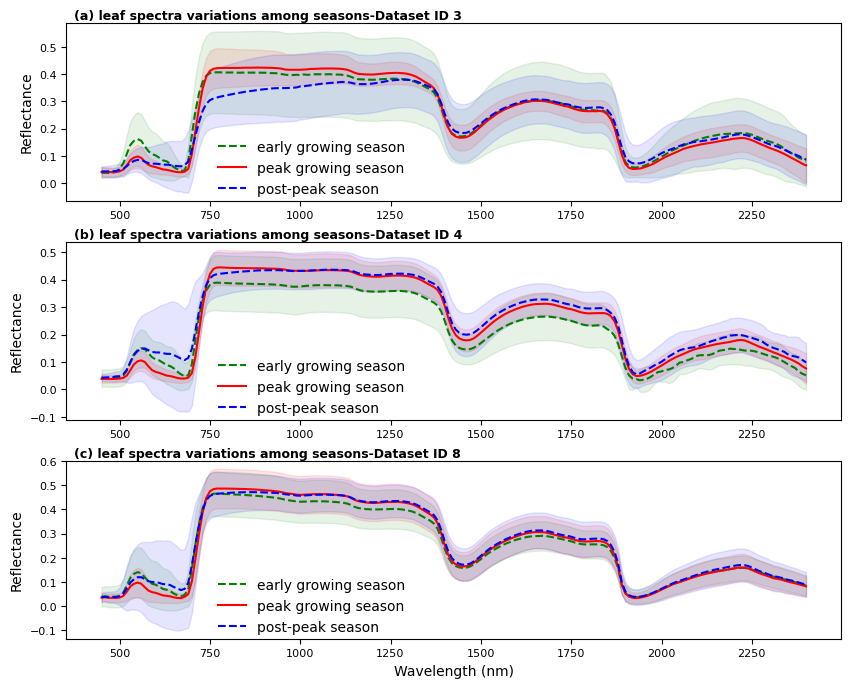

In [21]:
"""
leaf spectra variations divided by months
"""

colors = {'Dataset ID 3':['g','b','c','purple','m','r'],
          'Dataset ID 4':['deepskyblue','g','b','c','purple','m'],
          'Dataset ID 8':['deepskyblue','g','b','c','purple','m']}

linestyles = {'Dataset ID 3':['-','--','--','-.','-.',':'],
              'Dataset ID 4':['-','-','--','--','-.','-.'],
              'Dataset ID 8':['-','-','--','--','-.','-.']}
title = {'Dataset ID 3':'(a)','Dataset ID 4':'(b)','Dataset ID 8':'(c)'}

fig,ax = plt.subplots(3,1,figsize = (10,8))
plt.subplots_adjust(hspace =0.23)
k= 0
for ID in leaf_spectra['Datasets ID'].unique():
    df = leaf_spectra[leaf_spectra['Datasets ID']==ID]
    df.dropna(axis=0,how='any',inplace = True)
    df.sort_values('Month',inplace=True)
    wl_min = '450'
    wl_max = '2400'
    j = 0
    for month in df['Month'].unique():
        data = df[df['Month']==month]
        d_all = data.loc[:,wl_min:wl_max].values
        m_all = np.mean(d_all,0)
        std_all = np.std(d_all,0)
        lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
        wl = np.arange(int(wl_min),int(wl_max)+1,10)
        ax[k].plot(wl,m_all,linewidth=1.5,label = month,color = colors[ID][j],linestyle = linestyles[ID][j])
        ax[k].set_ylabel('Reflectance',fontsize = 10)
        ax[k].legend(loc = 'upper left',facecolor= 'none',edgecolor = 'none',ncol = 3,fontsize=10,bbox_to_anchor=(0.18, 0.32))
        j= j+1
    
    ax[k].text(0.01,1.02,f'{title[ID]} leaf spectra variations among months-{ID}',transform=ax[k].transAxes, fontsize = 9,fontweight="bold")   
    k = k+1
ax[2].set_xlabel('Wavelength (nm)',fontsize = 10)
plt.savefig('../3_figures/Fig S10_seasonal reflectance variations_month.png', dpi=1000, bbox_inches='tight') 


"""
leaf spectra variations divided by seasons
"""
colors = ['g','r','b']
linestyles = ['--','-','--']

fig,ax = plt.subplots(3,1,figsize = (10,8))
plt.subplots_adjust(hspace =0.23)
k= 0
for ID in leaf_spectra['Datasets ID'].unique():
    df = leaf_spectra[leaf_spectra['Datasets ID']==ID]
    df.dropna(axis=0,how='any',inplace = True)
    df.sort_values('season',inplace=True)
    wl_min = '450'
    wl_max = '2400'
    j = 0
    for season in df['season'].unique():
        data = df[df['season']==season]
        d_all = data.loc[:,wl_min:wl_max].values
        m_all = np.mean(d_all,0)
        std_all = np.std(d_all,0)
        lc_all,hc_all = m_all-1.96*std_all,m_all+1.96*std_all
        wl = np.arange(int(wl_min),int(wl_max)+1,10)
        ax[k].plot(wl,m_all,linewidth=1.5,label = season,color = colors[j],linestyle = linestyles[j])
        ax[k].fill_between(wl, lc_all,hc_all, alpha=0.1,color = colors[j])
        ax[k].set_ylabel('Reflectance',fontsize = 10)
        ax[k].legend(loc = 'upper left',facecolor= 'none',edgecolor = 'none',fontsize=10,bbox_to_anchor=(0.18, 0.41))
        j= j+1
    
    ax[k].text(0.01,1.02,f'{title[ID]} leaf spectra variations among seasons-{ID}',transform=ax[k].transAxes, fontsize = 9,fontweight="bold")   
    k = k+1
ax[2].set_xlabel('Wavelength (nm)',fontsize = 10)
plt.savefig('../3_figures/Fig S11_seasonal reflectance variations_season.png', dpi=1000, bbox_inches='tight') 

In [22]:
"""
Seasonal variations statistics
"""
trait_name = ['Chla+b','Ccar','LMA']
for tr in trait_name:
    print('-------------------')
    print(tr)
    dataset = leaf_traits[leaf_traits[tr]>0]
    dataset.sort_values('Month',inplace=True)
    for month in dataset['Month'].unique():
        df = dataset[dataset['Month']==month]
        print('Month:',month,'---',round(df[tr].mean(),2),'±',round(df[tr].std(),2))
        
    dataset.sort_values('season',inplace=True)
    for season in dataset['season'].unique():
        df = dataset[dataset['season']==season]
        print('season:',season,'---',round(df[tr].mean(),2),'±',round(df[tr].std(),2))

-------------------
Chla+b
Month: 05 --- 20.43 ± 9.11
Month: 06 --- 29.02 ± 9.87
Month: 07 --- 42.0 ± 8.02
Month: 08 --- 39.86 ± 8.24
Month: 09 --- 35.12 ± 11.01
Month: 10 --- 23.35 ± 10.07
Month: 11 --- 15.04 ± 7.9
season: early growing season --- 16.94 ± 4.9
season: peak growing season --- 37.65 ± 9.41
season: post-peak season --- 27.44 ± 12.41
-------------------
Ccar
Month: 05 --- 4.62 ± 1.36
Month: 06 --- 5.63 ± 1.79
Month: 07 --- 8.35 ± 2.23
Month: 08 --- 7.17 ± 1.66
Month: 09 --- 7.01 ± 2.12
Month: 10 --- 5.21 ± 1.58
Month: 11 --- 3.87 ± 2.01
season: early growing season --- 4.08 ± 0.89
season: peak growing season --- 7.21 ± 2.16
season: post-peak season --- 5.65 ± 2.21
-------------------
LMA
Month: 05 --- 52.04 ± 14.33
Month: 06 --- 79.24 ± 22.25
Month: 07 --- 103.69 ± 40.53
Month: 08 --- 97.43 ± 34.2
Month: 09 --- 106.77 ± 41.75
Month: 10 --- 116.18 ± 47.46
Month: 11 --- 140.27 ± 32.59
season: early growing season --- 61.01 ± 18.27
season: peak growing season --- 95.56 ± 36.5

## 2. Spatial analysis

In [28]:
def d(x,y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    return z
def rsquared(x, y): 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 
    a = r_value**2
    return a
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    return c * r * 1000

### 2.1 Random CV v.s. spatial CV

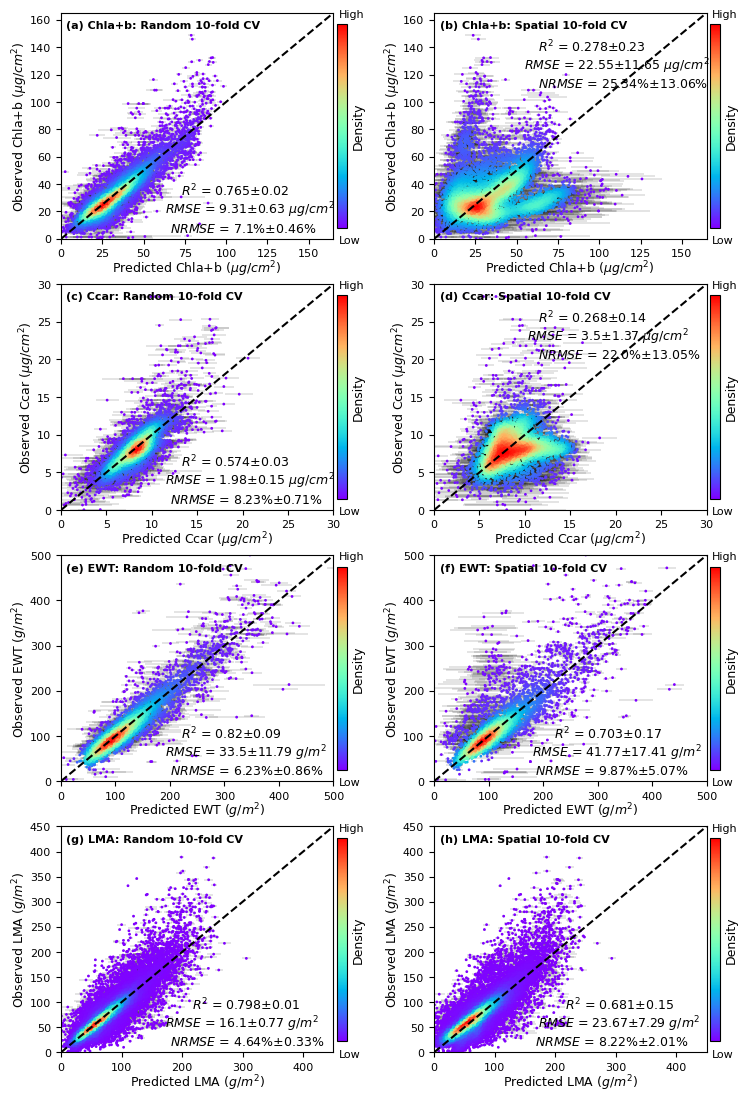

In [32]:
def random_spatial(ax,df,lim,tr,unit,title1,title2,text_loc):
    dff = df[(df['final_model_result']>0)&(df[tr]>0)]
    x,y = dff['final_model_result'], dff[tr]

    iteration_df = dff.loc[:,'iteration_1':'iteration_100']
    mean_all,std_all = np.mean(iteration_df,1), np.std(iteration_df,1)
    lc_all,hc_all = mean_all-1.96*std_all,mean_all+1.96*std_all
    x_right, x_left = hc_all - x, x - lc_all

    scatter = ax.scatter(x, y,  c= d(x,y), s=1,cmap='rainbow',zorder = 2)
    ax.errorbar(x,y, xerr=(x_left, x_right),fmt='.',color = 'none',ecolor='k',elinewidth=0.15,zorder = 1)
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', lw = 1.5,label = '1:1 line')
    
    cbar = plt.colorbar(scatter, ax=ax,pad=0.01, shrink=0.9)
    ax.text(1.02,0.98,'High',transform=ax.transAxes,fontsize = 8)
    ax.text(1.02,-0.02,'Low',transform=ax.transAxes,fontsize = 8)
    cbar.set_ticks([])
    cbar.set_label('Density', fontsize=9,labelpad=0.1)

    ax.set_xlim(0,lim)
    ax.set_ylim(0,lim)
    ax.set_xlabel('Predicted '+ tr+unit, fontsize=9, labelpad = 0.2)
    ax.set_ylabel('Observed '+ tr+unit, fontsize=9, labelpad = 0.2)

    R2, RMSE, NRMSE = [],[],[]
    for i in df['fold'].unique():
        temp = df[df['fold']==i]
        a, b = temp['final_model_result'], temp[tr]
        r2, rmse, nrmse= rsquared(a, b), np.sqrt(mean_squared_error(a,b)), np.sqrt(mean_squared_error(a,b))/(b.max()-b.min())
        R2.append(r2),RMSE.append(rmse),NRMSE.append(nrmse)

    R2_ = f'$R^2$ = {round(np.mean(R2),3)}\u00B1{round(np.std(R2),2)}'
    RMSE_ = f'$RMSE$ = {round(np.mean(RMSE),2)}\u00B1{round(np.std(RMSE),2)} {unit[2:-1]}'
    NRMSE_ = f'$NRMSE$ = {round(np.mean(NRMSE)*100,2)}%\u00B1{round(np.std(NRMSE)*100,2)}%'

    ax.text(text_loc[0],text_loc[3],R2_, fontsize=9,transform=ax.transAxes)
    ax.text(text_loc[1],text_loc[4],RMSE_, fontsize=9,transform=ax.transAxes)
    ax.text(text_loc[2],text_loc[5],NRMSE_, fontsize=9,transform=ax.transAxes)
    
    ax.text(0.02,0.93, f'{title1} {tr}: {title2} 10-fold CV', transform=ax.transAxes, fontsize = 8,fontweight='bold')
    return

"""
Random CV & spatial CV comparison
"""
lim = {'Chla+b':165,'Ccar':30,'EWT':500,'LMA':450}
units = {'Chla+b':' ($\mu g/cm^2$)','Ccar':' ($\mu g/cm^2$)','EWT':' ($g/m^2$)','LMA':' ($g/m^2$)'}
title1 = {'Chla+b':['(a)','(b)'],'Ccar':['(c)','(d)'],'EWT':['(e)','(f)'],'LMA':['(g)','(h)']}
title2 = {'Chla+b':['Random','Spatial'],'Ccar':['Random','Spatial'],'EWT':['Random','Spatial'],'LMA':['Random','Spatial']}
text_loc = {'Chla+b':[[0.44,0.38,0.4,0.19,0.11,0.03],[0.38,0.33,0.38,0.83,0.75,0.67]],
            'Ccar':[[0.44,0.38,0.4,0.19,0.11,0.03],[0.38,0.34,0.38,0.83,0.75,0.67]],
            'EWT':[[0.44,0.38,0.4,0.19,0.11,0.03],[0.44,0.36,0.37,0.19,0.11,0.03]],
            'LMA':[[0.48,0.38,0.4,0.19,0.11,0.03],[0.48,0.38,0.37,0.19,0.11,0.03]]}

fig,ax = plt.subplots(4,2,figsize = (9,13.5))
plt.subplots_adjust(wspace =0.15)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)
k = 0
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    df1 = pd.read_csv(f'../2_results/{tr}/{tr}_10fold random CV_df.csv')
    df2 = pd.read_csv(f'../2_results/{tr}/{tr}_10fold spatial CV_df.csv')
    random_spatial(ax[k][0],df1,lim[tr],tr,units[tr],title1[tr][0],title2[tr][0],text_loc[tr][0])
    random_spatial(ax[k][1],df2,lim[tr],tr,units[tr],title1[tr][1],title2[tr][1],text_loc[tr][1])
    k = k+1

plt.savefig('../3_figures/Fig 4_Random vs spatial CV-scatter plot.png', dpi=500, bbox_inches='tight')             

### 2.2 LOO-sites

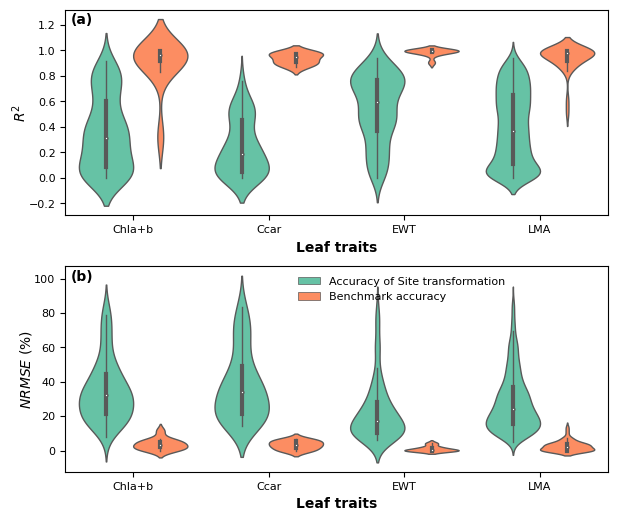

In [30]:
"""
LOO-sites
"""
trait_name = ['Chla+b','Ccar','EWT','LMA']
start_var=True
for tr in trait_name:
    df1 = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_site_accuracy.csv')
    df2 = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_site_benchmark_accuracy.csv')
    df1['tr'] = tr
    df2['tr'] = tr
    if start_var:
        site_trans = df1
        benchmark = df2
        start_var=False
    else:
        site_trans=pd.concat([site_trans,df1],axis = 0)
        benchmark=pd.concat([benchmark,df2],axis = 0)
site_trans['description'] = 'Accuracy of Site transformation'
benchmark['description'] = 'Benchmark accuracy'

df = pd.concat([site_trans,benchmark])
df1 = df[(df['R2']>0)&(df['R2']<1)]
df2 = df[df['NRMSE']<np.percentile(df['NRMSE'], 95)]
df2['NRMSE'] = df2['NRMSE']*100

fig,(ax1,ax2) = plt.subplots(2,1,figsize = (7,6))
plt.subplots_adjust(hspace =0.25)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

sns.violinplot(x='tr', y= 'R2',hue = 'description',ax = ax1,data=df1,palette='Set2',
               scale = 'width',inner='box', fliersize=3,saturation = 1,linewidth = 1)
sns.violinplot(x='tr', y= 'NRMSE',hue = 'description',ax = ax2,data=df2,palette='Set2',
               scale = 'width',inner='box', fliersize=3,saturation = 1,linewidth = 1)

ax1.set_xlabel('Leaf traits',fontsize = 10, fontweight = 'bold')
ax2.set_xlabel('Leaf traits',fontsize = 10, fontweight = 'bold')

ax1.set_ylabel('$R^2$',fontsize = 10, fontweight = 'bold',labelpad = 0.01)
ax2.set_ylabel('$NRMSE$ (%)',fontsize = 10,labelpad = 0.01)

ax1.text(0.01,0.93, '(a)', transform=ax1.transAxes, fontsize = 10,fontweight='bold')
ax2.text(0.01,0.93, '(b)', transform=ax2.transAxes, fontsize = 10,fontweight='bold')

ax1.legend([],[], frameon=False)
ax2.legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize = 8,bbox_to_anchor=(0.83, 1))
plt.savefig('../3_figures/Fig 5_LOO_site transformations.png', dpi=500, bbox_inches='tight') 

### 2.3 Site extrapolation

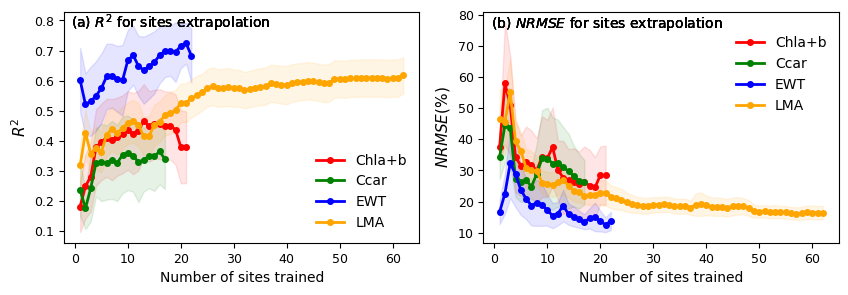

In [31]:
"""
3. sites extrapolation
"""
def site_extrapolation(ax1,ax2,df1,df2,color,tr):
    col1 = [col for col in df2.columns if any(df2[col] > 2)]                       #########
    df1.drop(columns=col1,inplace = True), df2.drop(columns=col1,inplace = True)   #########
    
    df2 = df2*100
    d1,d2,dp1,dp2 = df1.values.T,df2.values.T,len(df1),len(df2)
    m1,m2 = np.mean(d1, 0),np.mean(d2, 0)
    
    lc1,hc1 = st.t.interval(0.95, dp1-1,loc=np.mean(d1, 0),scale=st.sem(d1))
    lc2,hc2 = st.t.interval(0.95, dp2-1,loc=np.mean(d2, 0),scale=st.sem(d2))
    
    x1 = np.linspace(1, dp1, num=dp1)
    x2 = np.linspace(1, dp2, num=dp2)
    
    ax1.plot(x1,m1,marker = 'o',markersize=4,linewidth=2,c = color,label = tr)
    ax2.plot(x2,m2,marker = 'o',markersize=4,linewidth=2,c = color,label = tr)
    
    ax1.fill_between(x1, lc1,hc1, alpha=0.1,color = color)
    ax2.fill_between(x2, lc2,hc2, alpha=0.1,color = color)
    
    ax1.set_xlabel('Number of sites trained',fontsize = 10)
    ax2.set_xlabel('Number of sites trained',fontsize = 10)
    ax1.set_ylabel('$R^2$',fontsize = 11)
    ax2.set_ylabel('$NRMSE$(%)',fontsize = 11)
    ax1.legend(loc = 'lower right',facecolor= 'none',edgecolor = 'none',fontsize = 10)
    ax2.legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize = 10,bbox_to_anchor=(1, 0.95))
    ax1.tick_params(labelsize=9)
    ax2.tick_params(labelsize=9)

    ax1.text(0.02,0.93, '(a) $R^2$ for sites extrapolation', transform=ax1.transAxes, fontsize = 10)
    ax2.text(0.02,0.93, '(b) $NRMSE$ for sites extrapolation', transform=ax2.transAxes, fontsize = 10) 
    return

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,3))
plt.subplots_adjust(wspace =0.18)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

colors = {'Chla+b':'r','Ccar':'g','EWT':'b','LMA':'orange'}
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    df1 = pd.read_csv(f'../2_results/{tr}/{tr}_R2 site_extrapolation.csv')
    df2 = pd.read_csv(f'../2_results/{tr}/{tr}_nrmse site_extrapolation.csv')
    site_extrapolation(ax1,ax2,df1,df2,colors[tr],tr)
plt.savefig('../3_figures/Fig 6_sites extrapolation.png', dpi=1000, bbox_inches='tight')  

### 2.4 climate zones transferormation of PLSR

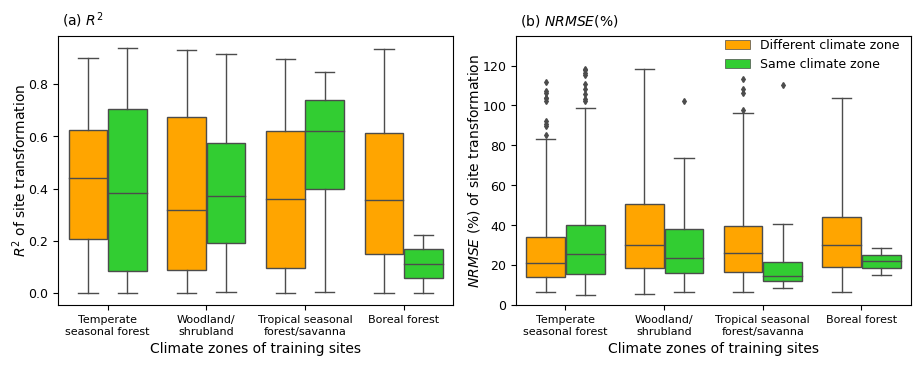

In [74]:
"""
climate zones transferormation of PLSR
"""
dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
cli_var = "../1_datasets/WorldClim_variables.csv"
Whittaker_biomes = "../1_datasets/Whittaker_biomes.rda"

traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]
climate = pd.read_csv(cli_var)
climate = climate[["bio01", "bio12"]]
traits = pd.concat([traits,climate],axis = 1)
traits = traits[['Site ID','bio01','bio12']]
traits.columns = ['Site ID','MAT','MAP']
climate_variables= pd.DataFrame(np.zeros(shape = (len(traits['Site ID'].unique()),3)),columns = ['Site ID','MAT','MAP'])
k = 0
for i in traits['Site ID'].unique():
    df = traits[traits['Site ID'] == i]
    df1 = df.loc[:,'MAT':]
    mat = df1.mean()['MAT']
    ma_p = df1.mean()['MAP']
    climate_variables.iloc[k] = np.array([i,mat,ma_p])
    k = k+1
climate_variables['MAT'] = climate_variables['MAT'].astype(float)
climate_variables['MAP'] = climate_variables['MAP'].astype(float)
climate_variables['MAP'] = climate_variables['MAP']/10

result = pyreadr.read_r(Whittaker_biomes)
ddf = result['Whittaker_biomes']
ddf['biome'].unique()
ddf.reset_index(drop = True, inplace  = True)
ddf.columns = ["Mean Annual Temperature (°C)",'Mean Annual Precipitation (cm)','biome_id','(a) Whittaker biomes']

inx = [9,5,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,5,5,5,5,9,9,5,9,1,1,5,9,9,9,1,7,3,9,9,5,5,9,5,9,1,1,1,1,4,1,1,9,5,9,9,9,9,9,9,9,9,
       7,7,5,6,7,5,5,9,9,1,9,5,9,9,5,1,2,9,9,9,9,5,5,8,5,9,9,9,9,9,9,9,3,3,3,3,1,1,4,5]
c_zones = []
for i in inx:
    temp = ddf[ddf["biome_id"]==i]['(a) Whittaker biomes'].unique()[0]
    c_zones.append(temp)
climate_variables['zones'] = c_zones

start_var = True
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    df = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_site_accuracy.csv')
    for i in df['training_site'].unique():
        temp = list(climate_variables[climate_variables['Site ID']==i]['zones'])[0]
        df.loc[df['training_site']==i,'train_zone'] = temp
        df.loc[df['testing_site']==i,'test_zone'] = temp
    if start_var:
        total_df = df
        start_var=False
    else:
        total_df=pd.concat([total_df,df],axis = 0)

total_df['NRMSE'] = total_df['NRMSE']*100
total_df = total_df[total_df['NRMSE']<120]
total_df.reset_index(drop = True, inplace=True)

total_df.loc[total_df['train_zone']==total_df['test_zone'],'Environmental conditions']='Same climate zone'
total_df.loc[total_df['train_zone']!=total_df['test_zone'],'Environmental conditions']='Different climate zone'


fig,(ax1,ax2) = plt.subplots(1,2,figsize = (11,3.5))
plt.subplots_adjust(wspace =0.16)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

sns.boxplot(x = total_df['train_zone'],y = total_df['R2'],hue = total_df['Environmental conditions'],palette = ['orange','limegreen'],ax =ax1,width=0.8,
            fliersize =3,linewidth =1,saturation=1)
sns.boxplot(x = total_df['train_zone'],y = total_df['NRMSE'],hue = total_df['Environmental conditions'],ax =ax2,whis = 2.5,palette = ['orange','limegreen'],
            width=0.8,fliersize =3,linewidth =1,saturation=1)
squad = ['Temperate\nseasonal forest', 'Woodland/\nshrubland','Tropical seasonal\nforest/savanna','Boreal forest']
ax1.set_xticklabels(squad)
ax2.set_xticklabels(squad)
ax1.tick_params(axis = 'x',labelsize=8)
ax2.tick_params(axis = 'x',labelsize=8)
ax1.tick_params(axis = 'y',labelsize=9)
ax2.tick_params(axis = 'y',labelsize=9)

ax1.set_xlabel("Climate zones of training sites",fontsize = 10)
ax2.set_xlabel("Climate zones of training sites",fontsize = 10)

ax1.set_ylabel("$R^2$ of site transformation",fontsize = 10,labelpad = 0)
ax2.set_ylabel("$NRMSE$ (%) of site transformation",fontsize = 10,labelpad = 0)

ax1.text(0.01,1.04, '(a) $R^2$', transform=ax1.transAxes, fontsize = 10)
ax2.text(0.01,1.04, '(b) $NRMSE$(%)', transform=ax2.transAxes, fontsize = 10)
ax2.set_ylim(0,135)

ax1.legend([],[], frameon=False)
ax2.legend(loc = 'upper right',fontsize = 9,facecolor= 'none',edgecolor = 'none',bbox_to_anchor=(1,1.03))
plt.savefig('../3_figures/Fig 13_site transformations_climate zones.png', dpi=1000, bbox_inches='tight')

### 2.5 spatial distance

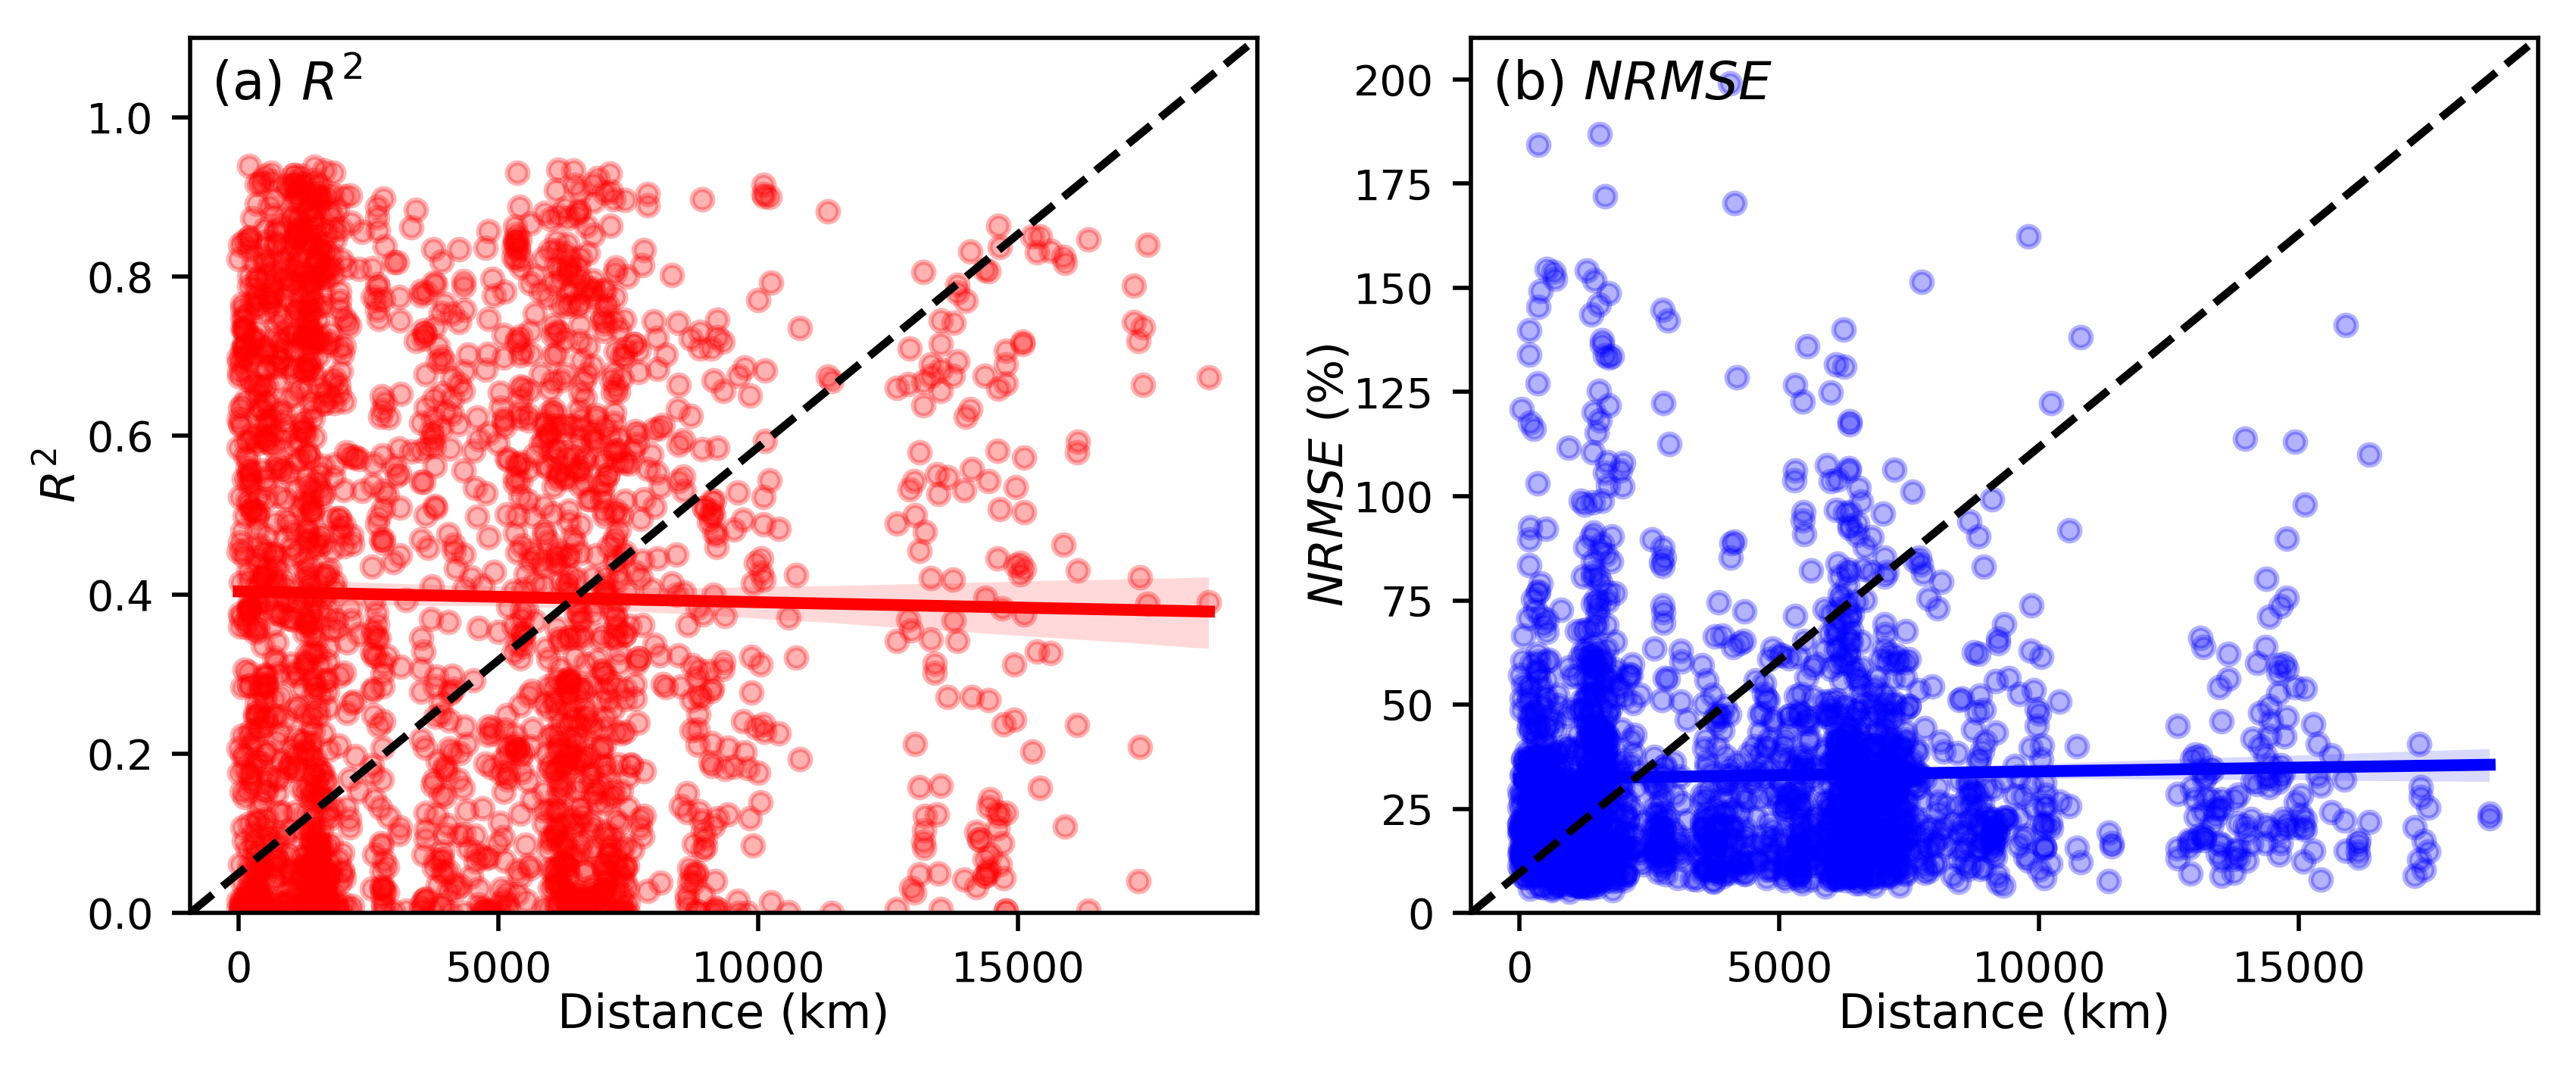

In [45]:
"""
spatial distance
"""
def distance_calculation(df,coordinates):
    distance = []
    for i in range(len(df)):
        temp = df.iloc[i]
        train_site = temp['training_site']
        test_site = temp['testing_site']

        train_lon = coordinates[coordinates['Site ID'] == train_site]['Longitude']
        train_lat = coordinates[coordinates['Site ID'] == train_site]['Latitude']
        test_lon = coordinates[coordinates['Site ID'] == test_site]['Longitude']
        test_lat = coordinates[coordinates['Site ID'] == test_site]['Latitude']

        dis = haversine(train_lon, train_lat, test_lon, test_lat)/1000
        distance.append(dis)
    df['distance'] = distance
    return df

dataset = "../1_datasets/Paired leaf traits and leaf spectra dataset.csv"
traits = pd.read_csv(dataset)
traits = traits.loc[:, "Dataset ID":]
traits = traits[['Site ID','Latitude','Longitude']]

coordinates = pd.DataFrame(np.zeros(shape = (0,3)),columns = ['Site ID','Longitude','Latitude'])
for i in traits['Site ID'].unique():
    temp = traits[traits['Site ID']==i]
    lon = temp['Longitude'].mean()
    lat = temp['Latitude'].mean()
    temp2 = pd.DataFrame(np.array([i, lon, lat]).reshape(1,3),columns = ['Site ID','Longitude','Latitude'])
    coordinates = pd.concat([coordinates,temp2])
coordinates['Longitude'] = coordinates['Longitude'].astype(float)
coordinates['Latitude'] = coordinates['Latitude'].astype(float)
coordinates.reset_index(drop = True, inplace = True)

trait_name = ['Chla+b','Ccar','EWT','LMA']
start_var = True
for tr in trait_name:
    df = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_site_accuracy.csv')
    a = distance_calculation(df,coordinates)
    if start_var:
        res = a
        start_var = False
    else:
        res = pd.concat([res,a])
res = res[res['NRMSE']<2]
res.sort_values(by="distance",inplace = True,ascending= True)
res.reset_index(drop = True, inplace = True)
res['NRMSE'] = res['NRMSE']*100

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (8,3),dpi = 500)
plt.subplots_adjust(wspace =0.2)

ax1.scatter(res['distance'],res['R2'],color = 'r', alpha = 0.3, s = 15)
ax2.scatter(res['distance'],res['NRMSE'],color = 'b', alpha = 0.3, s = 15)

sns.regplot('distance','R2', data = res, ax = ax1,fit_reg=True, ci = 95,scatter=False,color='b',scatter_kws = {'alpha':0.3}, line_kws = {'color':'r'})
sns.regplot('distance','NRMSE', data = res, ax = ax2,fit_reg=True, ci = 95,scatter=False,color='b',scatter_kws = {'alpha':0.3}, line_kws = {'color':'b'})

ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', lw = 1.5,label = '1:1 line')
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', lw = 1.5,label = '1:1 line')

ax1.set_ylabel('$R^2$', fontsize=9, labelpad = 0.2)
ax2.set_ylabel('$NRMSE$ (%)',fontsize = 9,labelpad = 0.2)

ax1.set_xlabel('Distance (km)', fontsize=9, labelpad = 0.2)
ax2.set_xlabel('Distance (km)', fontsize=9, labelpad = 0.2)

ax1.set_ylim(0,1.1)
ax2.set_ylim(0,210)

ax1.text(0.02,0.93, '(a) $R^2$', transform=ax1.transAxes, fontsize = 10)
ax2.text(0.02,0.93, '(b) $NRMSE$ ', transform=ax2.transAxes, fontsize = 10)
plt.savefig('../3_figures/Fig S12_the relationship between distance and performance.png', dpi=1000, bbox_inches='tight') 

## 3. PFTs analysis

### 3.1 Cross PFTs validation

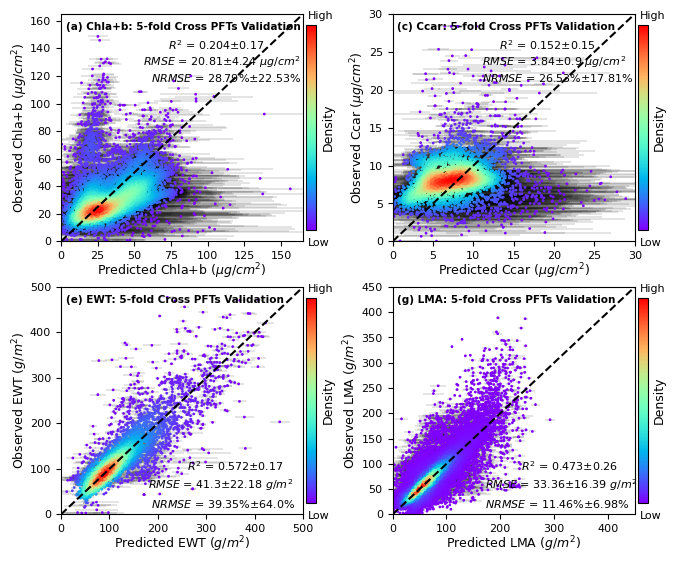

In [46]:
"""
Cross PFTs validation
"""
def cross_PFTs(ax,df,lim,tr,unit,title,text_loc):
    dff = df[(df['final_model_result']>0)&(df[tr]>0)]
    x,y = dff['final_model_result'], dff[tr]
    
    iteration_df = dff.loc[:,'iteration_1':'iteration_100']
    mean_all,std_all = np.mean(iteration_df,1), np.std(iteration_df,1)
    lc_all,hc_all = mean_all-1.96*std_all,mean_all+1.96*std_all
    x_right, x_left = hc_all - x, x - lc_all

    scatter = ax.scatter(x, y,  c= d(x,y), s=1,cmap='rainbow',zorder = 2)
    ax.errorbar(x,y, xerr=(x_left, x_right),fmt='.',color = 'none',ecolor='k',elinewidth=0.15,zorder = 1)
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', lw = 1.5,label = '1:1 line')
    
    cbar = plt.colorbar(scatter, ax=ax,pad=0.01, shrink=0.9)
    ax.text(1.02,0.98,'High',transform=ax.transAxes,fontsize = 8)
    ax.text(1.02,-0.02,'Low',transform=ax.transAxes,fontsize = 8)
    cbar.set_ticks([])
    cbar.set_label('Density', fontsize=9,labelpad=0.1)
    
    ax.set_xlim(0,lim)
    ax.set_ylim(0,lim)
    ax.set_xlabel('Predicted '+ tr+unit, fontsize=9, labelpad = 0.2)
    ax.set_ylabel('Observed '+ tr+unit, fontsize=9, labelpad = 0.2)
    
    R2, RMSE, NRMSE = [],[],[]
    for i in df['fold'].unique():
        temp = df[df['fold']==i]
        a, b = temp['final_model_result'], temp[tr]
        r2, rmse, nrmse= rsquared(a, b), np.sqrt(mean_squared_error(a,b)), np.sqrt(mean_squared_error(a,b))/(b.max()-b.min())
        R2.append(r2),RMSE.append(rmse),NRMSE.append(nrmse)

    R2_ = f'$R^2$ = {round(np.mean(R2),3)}\u00B1{round(np.std(R2),2)}'
    RMSE_ = f'$RMSE$ = {round(np.mean(RMSE),2)}\u00B1{round(np.std(RMSE),2)} {unit[2:-1]}'
    NRMSE_ = f'$NRMSE$ = {round(np.mean(NRMSE)*100,2)}%\u00B1{round(np.std(NRMSE)*100,2)}%'
    
    ax.text(text_loc[0],text_loc[3],R2_, fontsize=8,transform=ax.transAxes)
    ax.text(text_loc[1],text_loc[4],RMSE_, fontsize=8,transform=ax.transAxes)
    ax.text(text_loc[2],text_loc[5],NRMSE_, fontsize=8,transform=ax.transAxes)
    ax.text(0.02,0.93, f'{title} {tr}: 5-fold Cross PFTs Validation', transform=ax.transAxes, fontsize = 7.5,fontweight='bold')
    return

lim = {'Chla+b':165,'Ccar':30,'EWT':500,'LMA':450}
idxs = {'Chla+b':[0,0],'Ccar':[0,1],'EWT':[1,0],'LMA':[1,1]}
units = {'Chla+b':' ($\mu g/cm^2$)','Ccar':' ($\mu g/cm^2$)','EWT':' ($g/m^2$)','LMA':' ($g/m^2$)'}
title = {'Chla+b':'(a)','Ccar':'(c)','EWT':'(e)','LMA':'(g)'}
text_loc = {'Chla+b':[0.44,0.34,0.37,0.84,0.77,0.7],'Ccar':[0.44,0.37,0.37,0.84,0.77,0.7],
            'EWT':[0.52,0.36,0.37,0.19,0.11,0.03],'LMA':[0.53,0.38,0.38,0.19,0.11,0.03]}

fig,ax = plt.subplots(2,2,figsize = (8,6.5))
plt.subplots_adjust(hspace = 0.2, wspace =0.15)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    df = pd.read_csv(f'../2_results/{tr}/{tr}_5fold PFTs CV_df.csv')
    cross_PFTs(ax[idxs[tr][0]][idxs[tr][1]],df,lim[tr],tr,units[tr],title[tr],text_loc[tr])
plt.savefig('../3_figures/Fig 7_Random vs PFTs CV-scatter plot.png', dpi=500, bbox_inches='tight') 

### 3.2 LOO-PFTs

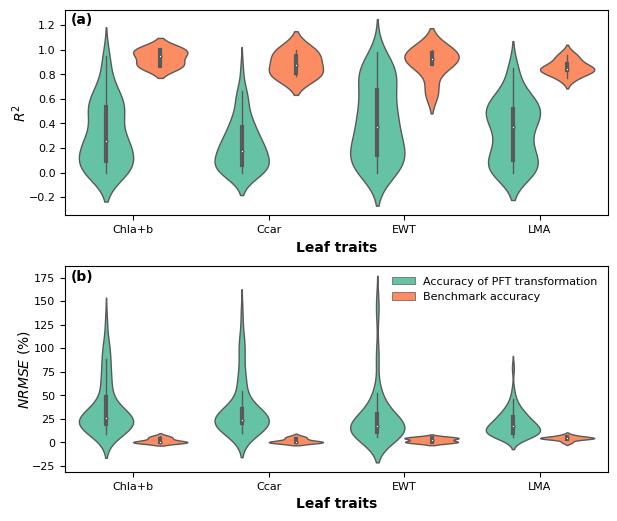

In [34]:
"""
2. LOO-PFTs
"""
trait_name = ['Chla+b','Ccar','EWT','LMA']
start_var=True
for tr in trait_name:
    df1 = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_PFT_accuracy.csv')
    df2 = pd.read_csv(f'../2_results/{tr}/{tr}_LOO_PFT_benchmark_accuracy.csv')
    df1['tr'] = tr
    df2['tr'] = tr
    if start_var:
        site_trans = df1
        benchmark = df2
        start_var=False
    else:
        site_trans=pd.concat([site_trans,df1],axis = 0)
        benchmark=pd.concat([benchmark,df2],axis = 0)
site_trans['description'] = 'Accuracy of PFT transformation'
benchmark['description'] = 'Benchmark accuracy'

df = pd.concat([site_trans,benchmark])
df1 = df[(df['R2']>0)&(df['R2']<1)]
df2 = df[df['NRMSE']<np.percentile(df['NRMSE'], 95)]
df2['NRMSE'] = df2['NRMSE']*100

fig,(ax1,ax2) = plt.subplots(2,1,figsize = (7,6))
plt.subplots_adjust(hspace =0.25)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

sns.violinplot(x='tr', y= 'R2',hue = 'description',ax = ax1,data=df1,palette='Set2',
               scale = 'width',inner='box', fliersize=3,saturation = 1,linewidth = 1)
sns.violinplot(x='tr', y= 'NRMSE',hue = 'description',ax = ax2,data=df2,palette='Set2',
               scale = 'width',inner='box', fliersize=3,saturation = 1,linewidth = 1)

ax1.set_xlabel('Leaf traits',fontsize = 10, fontweight = 'bold')
ax2.set_xlabel('Leaf traits',fontsize = 10, fontweight = 'bold')

ax1.set_ylabel('$R^2$',fontsize = 10, fontweight = 'bold',labelpad = 0.01)
ax2.set_ylabel('$NRMSE$ (%)',fontsize = 10,labelpad = 0.01)

ax1.text(0.01,0.93, '(a)', transform=ax1.transAxes, fontsize = 10,fontweight='bold')
ax2.text(0.01,0.93, '(b)', transform=ax2.transAxes, fontsize = 10,fontweight='bold')

ax1.legend([],[], frameon=False)
ax2.legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize = 8)
plt.savefig('../3_figures/Fig 8_LOO_PFT transformations.png', dpi=500, bbox_inches='tight') 

### 3.3 Cross sites for each PFT

R2 Grasslands 0.3061341362982463
R2 Deciduous broadleaf forests 0.4040455292534648
R2 Croplands 0.4127951393121506
R2 Shrublands 0.40745994537441194
R2 Evergreen needleleaf forests 0.26212000716000494
R2 Evergreen broadleaf forests 0.47483266197098284
NRMSE Grasslands 42.911893906952784
NRMSE Deciduous broadleaf forests 44.91449088209404
NRMSE Croplands 38.3150659131177
NRMSE Shrublands 50.938102601067186
NRMSE Evergreen needleleaf forests 47.59302111736758
NRMSE Evergreen broadleaf forests 37.99840656620894


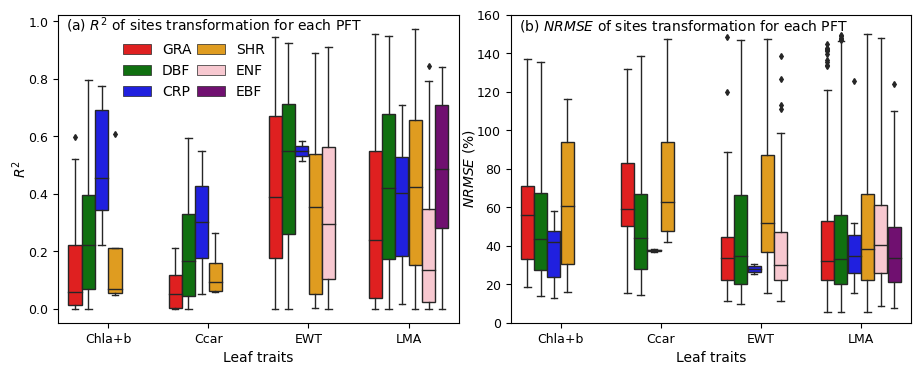

In [55]:
"""
Cross sites for each PFT
"""

trait_name = ['Chla+b','Ccar','EWT','LMA']
start_var=True
for tr in trait_name:
    df = pd.read_csv(f'../2_results/{tr}/{tr}_Cross sites for each PFT.csv')
    df['traits'] = tr
    if start_var:
        a = df
        start_var=False
    else:
        a=pd.concat([a,df],axis = 0)

a['NRMSE'] = a['NRMSE']*100
a = a[a['NRMSE']<150]

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (11,4))
plt.subplots_adjust(wspace =0.13)

config = {"font.family":'Calibri'}
plt.rcParams.update(config)

color = ['r','g','b','orange','pink','purple']

sns.boxplot(x = a['traits'],y = a['R2'],hue = a['PFTs'],ax =ax1,palette=color,width=0.8,
            fliersize =3,linewidth =1)
sns.boxplot(x = a['traits'],y = a['NRMSE'],hue = a['PFTs'],ax =ax2,palette=color,whis = 2.5,
            width=0.8,fliersize =3,linewidth =1)

ax1.set_xlabel('Leaf traits',fontsize = 10)
ax2.set_xlabel('Leaf traits',fontsize = 10)
ax1.set_ylabel('$R^2$',fontsize = 10,labelpad = 0.01)
ax2.set_ylabel('$NRMSE$ (%)',fontsize = 10,labelpad = 0.01)

ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)

ax1.text(0.02,0.95, '(a) $R^2$ of sites transformation for each PFT', transform=ax1.transAxes, fontsize = 10)
ax2.text(0.02,0.95, '(b) $NRMSE$ of sites transformation for each PFT', transform=ax2.transAxes, fontsize = 10)

handles, _ = ax1.get_legend_handles_labels()  
ax1.legend(handles, ['GRA','DBF','CRP','SHR','ENF','EBF'], loc="upper left",ncol =2, fontsize = 10,
           facecolor= 'none',edgecolor = 'none',columnspacing = 0.4,bbox_to_anchor=(0.13,0.95))

# handles, _ = ax2.get_legend_handles_labels()  
# ax2.legend(handles, ['GRA','DBF','CRP','SHR','ENF','EBF'], loc ="upper left",ncol =2, fontsize = 10,
#            facecolor= 'none',edgecolor = 'none',columnspacing = 0.4,bbox_to_anchor=(0.1,0.95))
ax2.set_ylim(0,160)
ax2.legend([],[],frameon=False)

plt.savefig('../3_figures/Fig 9_cross sites for each PFT.png', dpi=500, bbox_inches='tight') 

for i in a['PFTs'].unique():
    tem = a[a['PFTs']==i]
    r2 = tem['R2'].mean()
    print('R2',i,r2)
# R2: EBF,CRP,DBF,SHR,GRA,ENF
for i in a['PFTs'].unique():
    tem = a[a['PFTs']==i]
    nrmse = tem['NRMSE'].mean()
    print('NRMSE',i,nrmse)  
# NRMSE:EBF,CRP,GRA,DBF,SHR,ENF

### 3.4 PFT extrapolation

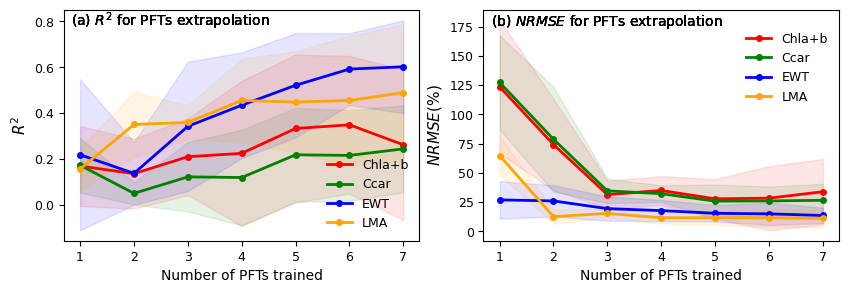

In [50]:
"""
PFT extrapolation
"""
def PFT_extrapolation(ax1,ax2,df1,df2,color,tr):
    col1 = [col for col in df2.columns if any(df2[col] > 2)]
    df1.drop(columns=col1,inplace = True), df2.drop(columns=col1,inplace = True)
    df2 = df2*100
    
    d1,d2,dp1,dp2 = df1.values.T,df2.values.T,len(df1),len(df2)
    m1,m2 = np.mean(d1, 0),np.mean(d2, 0)
    
    lc1,hc1 = st.t.interval(0.95, dp1-1,loc=np.mean(d1, 0),scale=st.sem(d1))
    lc2,hc2 = st.t.interval(0.95, dp2-1,loc=np.mean(d2, 0),scale=st.sem(d2))
    
    x1 = np.linspace(1, dp1, num=dp1)
    x2 = np.linspace(1, dp2, num=dp2)
    
    ax1.plot(x1,m1,marker = 'o',markersize=4,linewidth=2,c = color,label = tr)
    ax2.plot(x2,m2,marker = 'o',markersize=4,linewidth=2,c = color,label = tr)
    
    ax1.fill_between(x1, lc1,hc1, alpha=0.1,color = color)
    ax2.fill_between(x2, lc2,hc2, alpha=0.1,color = color)
    
    ax1.set_xlabel('Number of PFTs trained',fontsize = 10)
    ax2.set_xlabel('Number of PFTs trained',fontsize = 10)
    ax1.set_ylabel('$R^2$',fontsize = 11)
    ax2.set_ylabel('$NRMSE$(%)',fontsize = 11)
    ax1.legend(loc = 'lower right',facecolor= 'none',edgecolor = 'none',fontsize = 9)
    ax2.legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize = 9,bbox_to_anchor=(1, 0.95))
    ax1.tick_params(labelsize=9)
    ax2.tick_params(labelsize=9)

    ax1.text(0.02,0.93, '(a) $R^2$ for PFTs extrapolation', transform=ax1.transAxes, fontsize = 10)
    ax2.text(0.02,0.93, '(b) $NRMSE$ for PFTs extrapolation', transform=ax2.transAxes, fontsize = 10) 
    return

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,3))
plt.subplots_adjust(wspace =0.18)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

colors = {'Chla+b':'r','Ccar':'g','EWT':'b','LMA':'orange'}
trait_name = ['Chla+b','Ccar','EWT','LMA']
for tr in trait_name:
    df1 = pd.read_csv(f'../2_results/{tr}/{tr}_R2 PFT_extrapolation.csv')
    df2 = pd.read_csv(f'../2_results/{tr}/{tr}_nrmse PFT_extrapolation.csv')
    PFT_extrapolation(ax1,ax2,df1,df2,colors[tr],tr)
plt.savefig('../3_figures/Fig 10_PFTs extrapolation.png', dpi=500, bbox_inches='tight')  

## 4. Temporal analysis

### 4.1 Random CV v.s. temporal CV

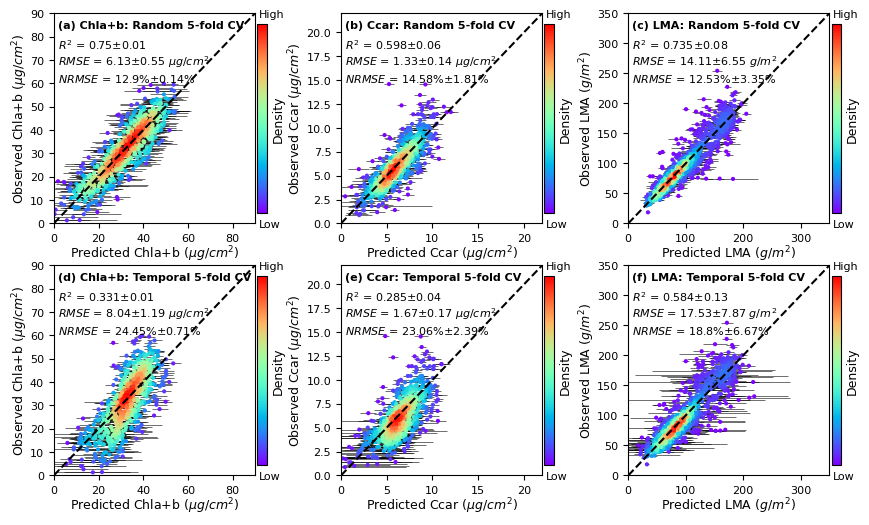

In [37]:
"""
random CV & temporal CV comparison
"""
def ramdom_temporal1(ax,df,lim,tr,unit,title1,title2,text_loc):
    dff = df[(df['final_model_result']>0)&(df[tr]>0)]
    x,y = dff['final_model_result'], dff[tr]
    
    iteration_df = dff.loc[:,'iteration_1':'iteration_100']
    mean_all,std_all = np.mean(iteration_df,1), np.std(iteration_df,1)
    lc_all,hc_all = mean_all-1.96*std_all,mean_all+1.96*std_all
    x_right, x_left = hc_all - x, x - lc_all
    scatter = ax.scatter(x, y,  c= d(x,y), s=4,cmap='rainbow',zorder = 2)
    ax.errorbar(x,y, xerr=(x_left, x_right),fmt='.',color = 'none',ecolor='k',elinewidth=0.4,zorder = 1)
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', lw = 1.5,label = '1:1 line')
    cbar = plt.colorbar(scatter, ax=ax,pad=0.01, shrink=0.9)
    ax.text(1.02,0.98,'High',transform=ax.transAxes,fontsize = 8)
    ax.text(1.02,-0.02,'Low',transform=ax.transAxes,fontsize = 8)
    cbar.set_ticks([])
    cbar.set_label('Density', fontsize=9,labelpad=0.1)

    ax.set_xlim(0,lim)
    ax.set_ylim(0,lim)
    ax.set_xlabel('Predicted '+ tr+unit, fontsize=9, labelpad = 0.2)
    ax.set_ylabel('Observed '+ tr+unit, fontsize=9, labelpad = 0.2)
    
    R2, RMSE, NRMSE = [],[],[]
    for dataset in df['Dataset ID'].unique():
        temp = df[df['Dataset ID']==dataset]
        R2_temp, RMSE_temp, NRMSE_temp = [],[],[]
        for i in temp['fold'].unique():
            temp2 = temp[temp['fold']==i]
            a, b = temp2['final_model_result'], temp2[tr]
            r2, rmse, nrmse= rsquared(a, b), np.sqrt(mean_squared_error(a,b)), np.sqrt(mean_squared_error(a,b))/(b.max()-b.min())
            R2_temp.append(r2),RMSE_temp.append(rmse),NRMSE_temp.append(nrmse)
        aa, bb, cc = np.mean(R2_temp),np.mean(RMSE_temp),np.mean(NRMSE_temp)
        R2.append(aa), RMSE.append(bb),NRMSE.append(cc)

    R2_ = f'$R^2$ = {round(np.mean(R2),3)}\u00B1{round(np.std(R2),2)}'
    RMSE_ = f'$RMSE$ = {round(np.mean(RMSE),2)}\u00B1{round(np.std(RMSE),2)} {unit[2:-1]}'
    NRMSE_ = f'$NRMSE$ = {round(np.mean(NRMSE)*100,2)}%\u00B1{round(np.std(NRMSE)*100,2)}%'
    
    ax.text(text_loc[0],text_loc[3],R2_, fontsize=8,transform=ax.transAxes)
    ax.text(text_loc[1],text_loc[4],RMSE_, fontsize=8,transform=ax.transAxes)
    ax.text(text_loc[2],text_loc[5],NRMSE_, fontsize=8,transform=ax.transAxes)
    ax.text(0.02,0.93, f'{title1} {tr}: {title2} 5-fold CV', transform=ax.transAxes, fontsize = 8,fontweight='bold') 
    return

lim = {'Chla+b':90,'Ccar':22,'LMA':350}
idxs = {'Chla+b':[(0,0),(1,0)],'Ccar':[(0,1),(1,1)],'LMA':[(0,2),(1,2)]}
units = {'Chla+b':' ($\mu g/cm^2$)','Ccar':' ($\mu g/cm^2$)','LMA':' ($g/m^2$)'}
title1 = {'Chla+b':['(a)','(d)'],'Ccar':['(b)','(e)'],'LMA':['(c)','(f)']}
title2 = {'Chla+b':['Random','Temporal'],'Ccar':['Random','Temporal'],'LMA':['Random','Temporal']}
text_loc = {'Chla+b':[[0.02,0.02,0.02,0.83,0.75,0.67],[0.02,0.02,0.02,0.83,0.75,0.67]],
            'Ccar':[[0.02,0.02,0.02,0.83,0.75,0.67],[0.02,0.02,0.02,0.83,0.75,0.67]],
            'LMA':[[0.02,0.02,0.02,0.83,0.75,0.67],[0.02,0.02,0.02,0.83,0.75,0.67]]}

"""
train temporal model for each season dataset
"""
fig,ax = plt.subplots(2,3,figsize = (10.5,6))
config = {"font.family":'Calibri'}
plt.subplots_adjust(wspace =0.2)
plt.rcParams.update(config)

trait_name = ['Chla+b','Ccar','LMA']
for tr in trait_name:
    df1 = pd.read_csv(f'../2_results/{tr}/Dataset#3_{tr}_5fold temporal_random CV_df.csv')
    df2 = pd.read_csv(f'../2_results/{tr}/Dataset#3_{tr}_5fold temporal CV_df.csv')
    df3 = pd.read_csv(f'../2_results/{tr}/Dataset#4_{tr}_5fold temporal_random CV_df.csv')
    df4 = pd.read_csv(f'../2_results/{tr}/Dataset#4_{tr}_5fold temporal CV_df.csv')
    
    if tr =='LMA':
        df5 = pd.read_csv(f'../2_results/{tr}/Dataset#8_{tr}_5fold temporal_random CV_df.csv')
        df6 = pd.read_csv(f'../2_results/{tr}/Dataset#8_{tr}_5fold temporal CV_df.csv')
        
        random_df = pd.concat([df1,df3,df5],axis = 0)
        temporal_df = pd.concat([df2,df4,df6],axis = 0)
       
    else:
        random_df = pd.concat([df1,df3],axis = 0)
        temporal_df = pd.concat([df2,df4],axis = 0)
    
    idx1 = idxs[tr][0]
    idx2 = idxs[tr][1]
    ramdom_temporal1(ax[idx1[0]][idx1[1]],random_df,lim[tr],tr,units[tr],title1[tr][0],title2[tr][0],text_loc[tr][0])
    ramdom_temporal1(ax[idx2[0]][idx2[1]],temporal_df,lim[tr],tr,units[tr],title1[tr][1],title2[tr][1],text_loc[tr][1])
plt.savefig('../3_figures/Fig 11_Random vs temporal CV-scatter plot_datasets separate_train.png', dpi=500, bbox_inches='tight') 

### 4.2 LOO-seasons

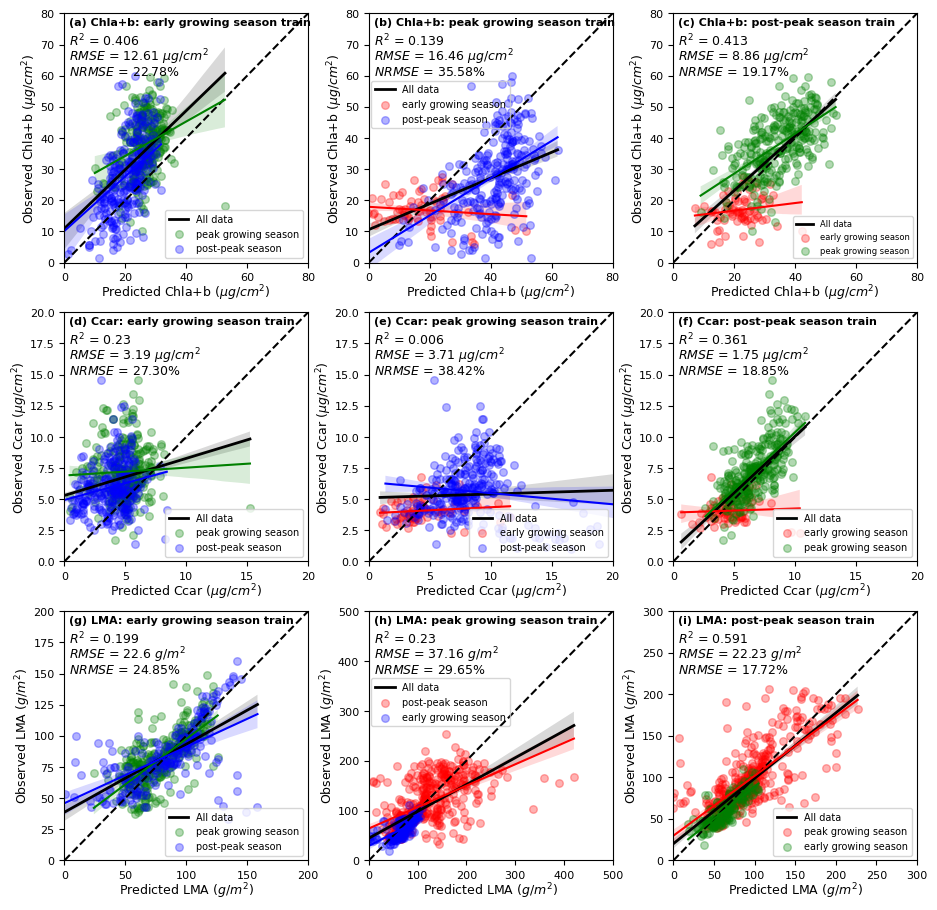

In [47]:
"""
Leave one season out scatter plot
"""
def LOO_season(ax,df,df2,df3,color,tr,lim,unit,title1,title2,text_loc):
    sns.regplot('pred',tr, data = df, fit_reg=True,ax = ax,ci = 95,scatter=False,label = 'All data',line_kws = {'color':'k','lw':2})
    ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', lw = 1.5)
    
    R1 = '$R^2$ = '+str(round(df2.loc[title2]['R2'],3))
    rmse1 = '$RMSE$ = '+str(round(df2.loc[title2]['RMSE'],2))+' '+unit[2:-1]
    nrmse1 = '$NRMSE$ = '+'{:.2%}'.format(df2.loc[title2]['NRMSE'])       
    ax.text(text_loc[0],text_loc[3],R1, fontsize=9,transform=ax.transAxes)
    ax.text(text_loc[1],text_loc[4],rmse1, fontsize=9,transform=ax.transAxes)
    ax.text(text_loc[2],text_loc[5],nrmse1, fontsize=9,transform=ax.transAxes)
    ax.text(0.02,0.95, f'{title1} {tr}: {title2} train', transform=ax.transAxes, fontsize = 8,fontweight='bold')

    test_seaason = df['season'].unique()
    k = 0
    for i in test_seaason:
        loc = text_loc[k+1]
        sns.regplot(df[df['season'] == i]['pred'],df[df['season'] == i][tr],fit_reg=True,ax = ax,ci = 95,scatter=True,
                    label = i,color = color[k],scatter_kws = {'alpha':0.3,'s':30},line_kws = {'lw':1.5})
        k=k+1
    
    ax.set_xlim(0,lim)
    ax.set_ylim(0,lim)
    ax.set_ylabel('Observed '+ tr+unit, fontsize=9, labelpad = 0.2)
    ax.set_xlabel('Predicted '+ tr+unit, fontsize=9, labelpad = 0.2)
    ax.legend(loc ='lower right',fontsize=7)
    return

def data_analysis(tr,datasets):
    var = True
    for dataset in datasets:
        df = pd.read_csv(f'../2_results/{tr}/{tr}_{dataset}_LOO_season_df.csv')
        df2 = pd.read_csv(f'../2_results/{tr}/{tr}_{dataset}_LOO_season_overall_accuracy.csv',index_col = 0)
        df3 = pd.read_csv(f'../2_results/{tr}/{tr}_{dataset}_LOO_season_accuracy.csv')
        if var:
            data = df
            all_accu = df2
            accu = df3
            var = False
        else:
            data = pd.concat([data,df],axis = 0)
            all_accu = all_accu+df2
            accu = pd.concat([accu,df3],axis = 0)

    all_accu = all_accu/len(datasets)
    accu['ID'] = accu['training_season']+' to '+accu['testing_season']
    start_var=True
    for i in ['R2', 'RMSE', 'NRMSE','NSE']:
        a1 = pd.DataFrame(accu.groupby('ID').mean()[i])
        if start_var:
            separate_accu = a1
            start_var=False
        else:
            separate_accu=pd.concat([separate_accu,a1],axis = 1)

    train_growing_season = data[data['train_season'] == 'early growing season']
    train_peak_season =  data[data['train_season'] == 'peak growing season']
    train_post_season =  data[data['train_season'] == 'post-peak season']
    return train_growing_season,train_peak_season, train_post_season,all_accu,separate_accu

"""
train temporal model for each season dataset
"""
lim = {'Chla+b':[80,80,80],'Ccar':[20,20,20],'LMA':[200,500,300]}
units = {'Chla+b':' ($\mu g/cm^2$)','Ccar':' ($\mu g/cm^2$)','LMA':' ($g/m^2$)'}
title1 = {'Chla+b':['(a)','(b)','(c)'],'Ccar':['(d)','(e)','(f)'],'LMA':['(g)','(h)','(i)']}
title2 = {'Chla+b':['early growing season','peak growing season','post-peak season'],
          'Ccar':['early growing season','peak growing season','post-peak season'],
          'LMA':['early growing season','peak growing season','post-peak season']}
text_loc = {'Chla+b':[0.02,0.02,0.02,0.87,0.81,0.75],'Ccar':[0.02,0.02,0.02,0.87,0.81,0.75],'LMA':[0.02,0.02,0.02,0.87,0.81,0.75],}
colors = {'Chla+b':[['g','b'],['r','b'],['r','g']],'Ccar':[['g','b'],['r','b'],['r','g']],'LMA':[['g','b'],['r','b'],['r','g']]}

fig,ax = plt.subplots(3,3,figsize = (11,11))
config = {"font.family":'Calibri'}
plt.subplots_adjust(wspace =0.25)
plt.rcParams.update(config)
j= 0
trait_name =['Chla+b','Ccar','LMA']
for tr in trait_name:
    if (tr == 'Chla+b')|(tr == 'Ccar'):
        datasets = ['Dataset#3','Dataset#4']
        train_growing_season,train_peak_season, train_post_season,all_accu,separate_accu = data_analysis(tr,datasets)
    else:
        datasets = ['Dataset#3','Dataset#4', 'Dataset#8']
        train_growing_season,train_peak_season, train_post_season,all_accu,separate_accu = data_analysis(tr,datasets)
        df1 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_overall_accuracy.csv',index_col = 0)
        df2 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#8_LOO_season_overall_accuracy.csv',index_col = 0)
        all_accu.loc['early growing season'] = (df1.loc['early growing season']+df2.loc['early growing season'])/2
            
    LOO_season(ax[j][0],train_growing_season,all_accu,separate_accu,colors[tr][0],tr,lim[tr][0],units[tr],title1[tr][0],title2[tr][0],text_loc[tr])
    LOO_season(ax[j][1],train_peak_season,all_accu,separate_accu,colors[tr][1],tr,lim[tr][1],units[tr],title1[tr][1],title2[tr][1],text_loc[tr])
    LOO_season(ax[j][2],train_post_season,all_accu,separate_accu,colors[tr][2],tr,lim[tr][2],units[tr],title1[tr][2],title2[tr][2],text_loc[tr])
    j = j+1

ax[0][1].legend(loc ='lower right',fontsize=7,facecolor= 'none',bbox_to_anchor=(0.6,0.52))
ax[0][2].legend(loc ='lower right',fontsize=6)
ax[2][1].legend(loc ='lower right',fontsize=7,facecolor= 'none',bbox_to_anchor=(0.6,0.52))
plt.savefig('../3_figures/Fig 12_LOO season-scatter plot_datasets separate_train.png', dpi=1000, bbox_inches='tight')

### 4.3 Density plots of LOO-seasons

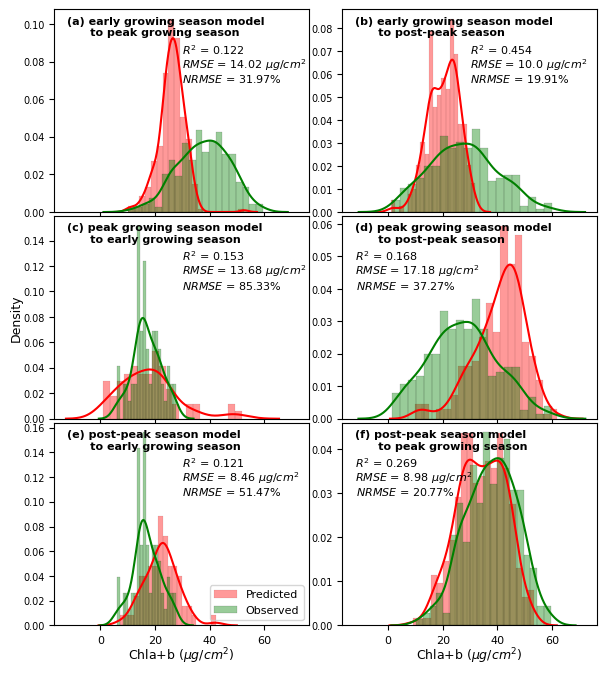

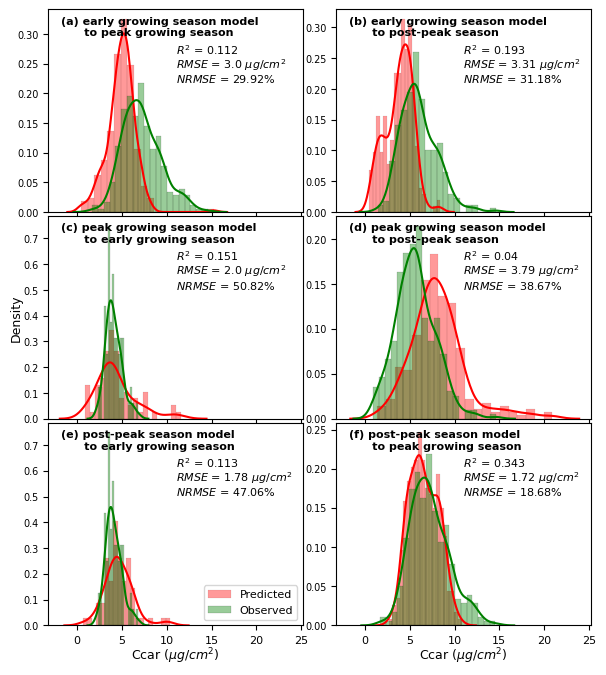

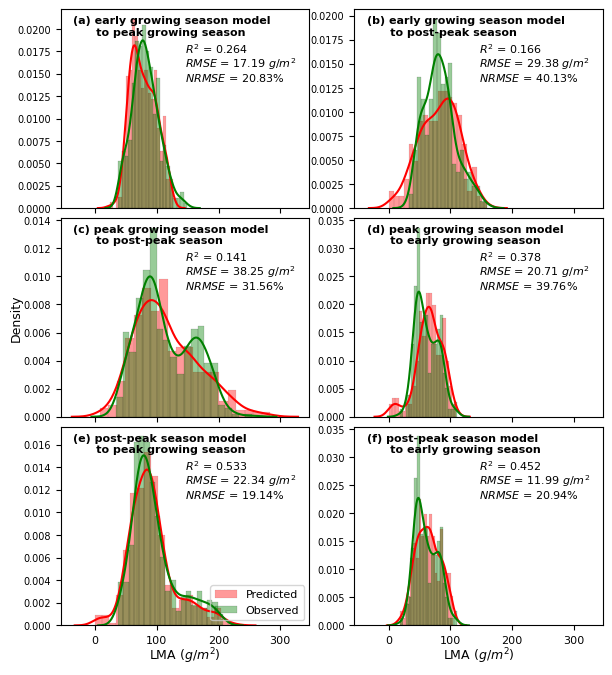

In [39]:
lim = {'Chla+b':100,'Ccar':30,'LMA':300}
units = {'Chla+b':' ($\mu g/cm^2$)','Ccar':' ($\mu g/cm^2$)','LMA':' ($g/m^2$)'}
jj = 13
trait_name =['Chla+b','Ccar','LMA']
for tr in trait_name:
    if (tr == 'Chla+b')|(tr == 'Ccar'):
        wspace = 0.13
        hspace = 0.02
        
        df1 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#3_LOO_season_df.csv')
        df2 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#3_LOO_season_overall_accuracy.csv',index_col = 0)
        df3 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#3_LOO_season_accuracy.csv')
        df4 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_df.csv')
        df5 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_overall_accuracy.csv',index_col = 0)
        df6 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_accuracy.csv')
        
        data = pd.concat([df1,df4],axis = 0)
        train_growing_season = data[data['train_season'] == 'early growing season']
        train_peak_season =  data[data['train_season'] == 'peak growing season']
        train_post_season =  data[data['train_season'] == 'post-peak season']
        all_accu = (df2+df5)/2
        
        temp = pd.concat([df3,df6])
        temp['ID'] = temp['training_season']+' to '+temp['testing_season']
        start_var=True
        for i in ['R2', 'RMSE', 'NRMSE','NSE']:
            a1 = pd.DataFrame(temp.groupby('ID').mean()[i])
            if start_var:
                separate_accu = a1
                start_var=False
            else:
                separate_accu=pd.concat([separate_accu,a1],axis = 1)
        
    else:
        wspace = 0.18
        hspace = 0.05
        df1 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#3_LOO_season_df.csv')
        df2 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#3_LOO_season_overall_accuracy.csv',index_col = 0)
        df3 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#3_LOO_season_accuracy.csv')
        df4 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_df.csv')
        df5 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_overall_accuracy.csv',index_col = 0)
        df6 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#4_LOO_season_accuracy.csv')
        df7 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#8_LOO_season_df.csv')
        df8 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#8_LOO_season_overall_accuracy.csv',index_col = 0)
        df9 = pd.read_csv(f'../2_results/{tr}/{tr}_Dataset#8_LOO_season_accuracy.csv')
        
        data = pd.concat([df1,df4,df7],axis = 0)
        train_growing_season = data[data['train_season'] == 'early growing season']
        train_peak_season =  data[data['train_season'] == 'peak growing season']
        train_post_season =  data[data['train_season'] == 'post-peak season']
        all_accu = (df2+df5+df8)/3
        all_accu.loc['early growing season'] = (df5.loc['early growing season']+df8.loc['early growing season'])/2
        temp = pd.concat([df3,df6,df9])
        temp['ID'] = temp['training_season']+' to '+temp['testing_season']

        start_var=True
        for i in ['R2', 'RMSE', 'NRMSE','NSE']:
            a1 = pd.DataFrame(temp.groupby('ID').mean()[i])
            if start_var:
                separate_accu = a1
                start_var=False
            else:
                separate_accu=pd.concat([separate_accu,a1],axis = 1)
    
    test = pd.concat([train_growing_season,train_peak_season,train_post_season])
    test = test[['train_season', 'season','pred',tr]]
    test.columns = ['train season', 'test season', 'Predicted', 'Observed']

    test = test[test['Predicted']>0]
    test = test[test['Predicted']<lim[tr]]
    
    fig,ax = plt.subplots(3,2,figsize = (7,8),sharex = True)
    plt.subplots_adjust(wspace =wspace,hspace =hspace)
    plt.rcParams.update(config)
    indxs = [['(a)','(b)'],['(c)','(d)'],['(e)','(f)']]
    k = 0
    for i in test['train season'].unique():
        temp = test[test['train season']==i]
        kk = 0
        for j in temp['test season'].unique():
            temp2 = temp[temp['test season']==j]

            sns.distplot(temp2['Predicted'],hist = True,bins=20,ax = ax[k][kk],
                         hist_kws={"label":'Predicted','facecolor':'r','edgecolor':'k',"lw":0.1},
                         kde_kws={"lw": 1.5,'color':'r'})

            sns.distplot(temp2['Observed'],hist = True,bins=20,ax = ax[k][kk],
                         hist_kws={"label":'Observed','facecolor':'g','edgecolor':'k',"lw":0.2},
                         kde_kws={"lw": 1.5,'color':'g'})
            
            R1 = '$R^2$ = '+str(round(separate_accu.loc[f'{i} to {j}']['R2'],3))
            rmse1 = '$RMSE$ = '+str(round(separate_accu.loc[f'{i} to {j}']['RMSE'],2))+' '+units[tr][2:-1]
            nrmse1 = '$NRMSE$ = '+'{:.2%}'.format(separate_accu.loc[f'{i} to {j}']['NRMSE'])       
            
            if ((tr=='Chla+b')&(k==1)&(kk==1))|(tr=='Chla+b')&(k==2)&(kk==1):
                ax[k][kk].text(0.05,0.78,R1, fontsize=8,transform=ax[k][kk].transAxes)
                ax[k][kk].text(0.05,0.71,rmse1, fontsize=8,transform=ax[k][kk].transAxes)
                ax[k][kk].text(0.055,0.64,nrmse1, fontsize=8,transform=ax[k][kk].transAxes)
            
            else:
                ax[k][kk].text(0.5,0.78,R1, fontsize=8,transform=ax[k][kk].transAxes)
                ax[k][kk].text(0.5,0.71,rmse1, fontsize=8,transform=ax[k][kk].transAxes)
                ax[k][kk].text(0.5,0.64,nrmse1, fontsize=8,transform=ax[k][kk].transAxes)

            ax[k][kk].set_ylabel('', fontsize=9, labelpad = 0.2)
            ax[k][kk].tick_params(axis='y',labelsize=7)
            ax[k][kk].text(0.05,0.87, f'{indxs[k][kk]} {i} model\n      to {j}', transform=ax[k][kk].transAxes, fontsize = 8,fontweight='bold')    
            kk = kk+1
        k = k+1

    ax[2][0].legend(loc ='lower right',fontsize=8,facecolor= 'none') 
    ax[1][0].set_ylabel('Density', fontsize=9, labelpad = 0.2)
    ax[2][0].set_xlabel(tr+units[tr], fontsize=9, labelpad = 0.2)
    ax[2][1].set_xlabel(tr+units[tr], fontsize=9, labelpad = 0.2)
    plt.savefig(f'../3_figures/Fig S{jj}_{tr}_LOO season-density_plot_datasets separate_train.png', dpi=500, bbox_inches='tight')
    jj = jj+1

## 5. VIP metrics

### 5.1 VIP metrics based on different validation strategies

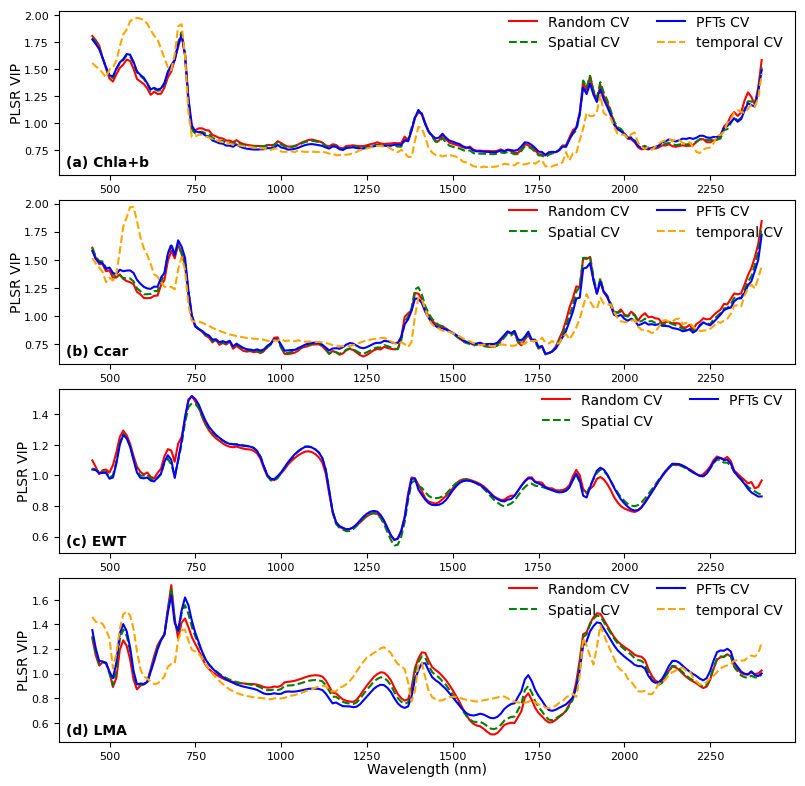

In [40]:
fig,ax = plt.subplots(4,1,figsize = (9.5,9.5))
plt.subplots_adjust(hspace =0.15)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

trait_name = ['Chla+b','Ccar','EWT','LMA']
wl = np.arange(450,2401,10)
txt = ['(a) Chla+b', '(b) Ccar', '(c) EWT', '(d) LMA']
k = 0
for tr in trait_name:
    if tr == 'EWT':
        labels = ['Random CV','Spatial CV', 'PFTs CV']
        colors = ['red','green','blue']
        linestyles = ['-','--','-']
        data = [f'{tr}_10fold random CV_VIP.csv', f'{tr}_10fold spatial CV_VIP.csv',f'{tr}_5fold PFTs CV_VIP.csv']
    else:
        labels = ['Random CV','Spatial CV', 'PFTs CV', 'temporal CV']
        colors = ['red','green','blue','orange']
        linestyles = ['-','--','-','--']
        data = [f'{tr}_10fold random CV_VIP.csv', f'{tr}_10fold spatial CV_VIP.csv',
                 f'{tr}_5fold PFTs CV_VIP.csv', f'All_datasets_{tr}_5fold temporal CV_VIP.csv']
        
    for i in range(len(data)):
        df = pd.read_csv((f'../2_results/{tr}/{data[i]}'))
        df= df.loc[:,'450':]

        df_mean = df.mean(axis = 0)
#         ax[k].plot(wl,savgol_filter(df_mean,31,9),lw = 1.5, color = colors[i],label = labels[i],ls = linestyles[i])
        ax[k].plot(wl,df_mean,lw = 1.5, color = colors[i],label = labels[i],ls = linestyles[i])
        ax[k].legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize=10,ncol = 2,bbox_to_anchor=(1, 1.05))       
        ax[k].set_ylabel('PLSR VIP', fontsize=10, labelpad = 0.2)
        ax[k].set_xlabel('Wavelength (nm)', fontsize=10, labelpad = 0.2)
        if k != 3:
            ax[k].set_xlabel('')
    
    ax[k].text(0.01,0.05,txt[k],transform=ax[k].transAxes, fontsize = 10,fontweight="bold")
    k = k+1
plt.savefig(f'../3_figures/Fig S16_VIP metrics based on different validation strategies.png', dpi=500, bbox_inches='tight')

### 5.2 VIP metrics based on different PFTs

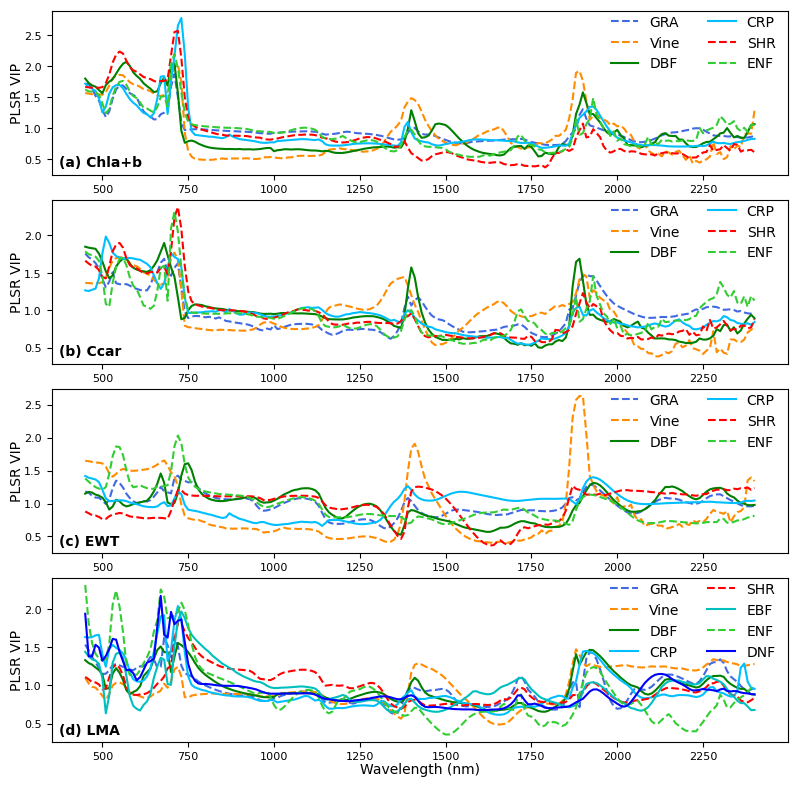

In [41]:
fig,ax = plt.subplots(4,1,figsize = (9.5,9.5))
plt.subplots_adjust(hspace =0.15)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

txt = ['(a) Chla+b', '(b) Ccar', '(c) EWT', '(d) LMA']
labels = {'Croplands':'CRP','Deciduous broadleaf forests':'DBF','Deciduous needleleaf forests':'DNF',
         'Evergreen broadleaf forests':'EBF','Evergreen needleleaf forests':'ENF','Grasslands':'GRA',
         'Shrublands':'SHR','Vine':'Vine'}

linestyles = {'Croplands':'-','Deciduous broadleaf forests':'-','Deciduous needleleaf forests':'-',
         'Evergreen broadleaf forests':'-','Evergreen needleleaf forests':'--','Grasslands':'--',
         'Shrublands':'--','Vine':'--'}

colors = {'Croplands':'deepskyblue','Deciduous broadleaf forests':'g','Deciduous needleleaf forests':'b',
         'Evergreen broadleaf forests':'c','Evergreen needleleaf forests':'limegreen','Grasslands':'royalblue',
         'Shrublands':'r','Vine':'darkorange'}

trait_name = ['Chla+b','Ccar','EWT','LMA']
wl = np.arange(450,2401,10)
k = 0
for tr in trait_name:
    data = f'{tr}_LOO_PFT_vip_score.csv'
    df = pd.read_csv((f'../2_results/{tr}/{data}'),index_col = 0)
    df.dropna(inplace = True)
    
    for PFT in df.index:
        ax[k].plot(wl,df.loc[PFT],lw = 1.5, color = colors[PFT],label = labels[PFT],ls = linestyles[PFT])
        ax[k].legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize=10,ncol = 2,bbox_to_anchor=(1, 1.05))       
        ax[k].set_ylabel('PLSR VIP', fontsize=10, labelpad = 0.2)
        ax[k].set_xlabel('Wavelength (nm)', fontsize=10, labelpad = 0.2)
        if k != 3:
            ax[k].set_xlabel('')
    
    ax[k].text(0.01,0.05,txt[k],transform=ax[k].transAxes, fontsize = 10,fontweight="bold")
    k = k+1
    
plt.savefig(f'../3_figures/Fig S17_VIP metrics based on different PFTs.png', dpi=500, bbox_inches='tight')

### 5.3 VIP metrics based on different seasons

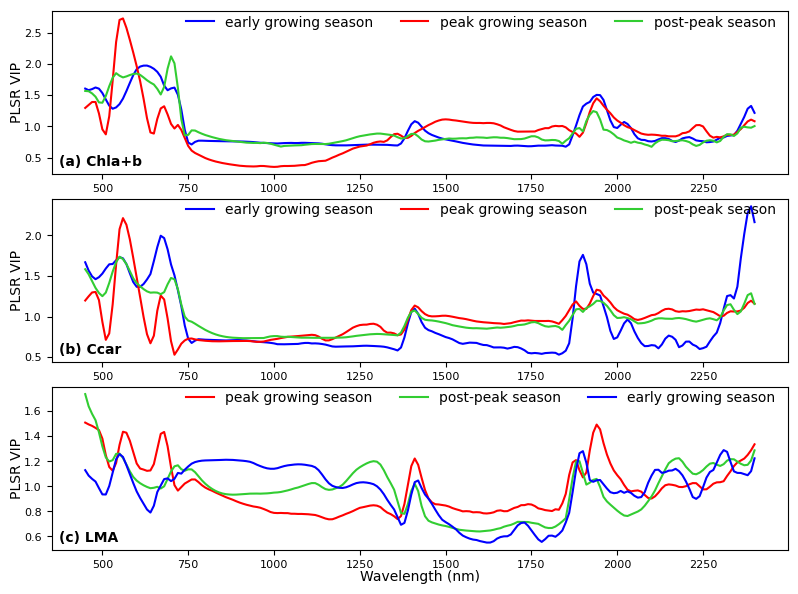

In [42]:
fig,ax = plt.subplots(3,1,figsize = (9.5,7))
plt.subplots_adjust(hspace =0.15)
config = {"font.family":'Calibri'}
plt.rcParams.update(config)

txt = ['(a) Chla+b', '(b) Ccar', '(c) LMA']

colors = {'peak growing season':'r','post-peak season':'limegreen','early growing season':'b'}

trait_name = ['Chla+b','Ccar','LMA']
wl = np.arange(450,2401,10)
k = 0
for tr in trait_name:
    data = f'{tr}_All_datasets_LOO_season_vip_score.csv'
    df = pd.read_csv((f'../2_results/{tr}/{data}'),index_col = 0)
    df.dropna(inplace = True)
    
    for time in df.index:
        ax[k].plot(wl,savgol_filter(df.loc[time],7,3),lw = 1.5, color = colors[time],label = time,ls = '-')
        ax[k].legend(loc = 'upper right',facecolor= 'none',edgecolor = 'none',fontsize=10,ncol = 3,bbox_to_anchor=(1, 1.05))       
        ax[k].set_ylabel('PLSR VIP', fontsize=10, labelpad = 0.2)
        ax[k].set_xlabel('Wavelength (nm)', fontsize=10, labelpad = 0.2)
        if k != 2:
            ax[k].set_xlabel('')
    
    ax[k].text(0.01,0.05,txt[k],transform=ax[k].transAxes, fontsize = 10,fontweight="bold")
    k = k+1
    
plt.savefig(f'../3_figures/Fig S18_VIP metrics based on different seasons.png', dpi=500, bbox_inches='tight')

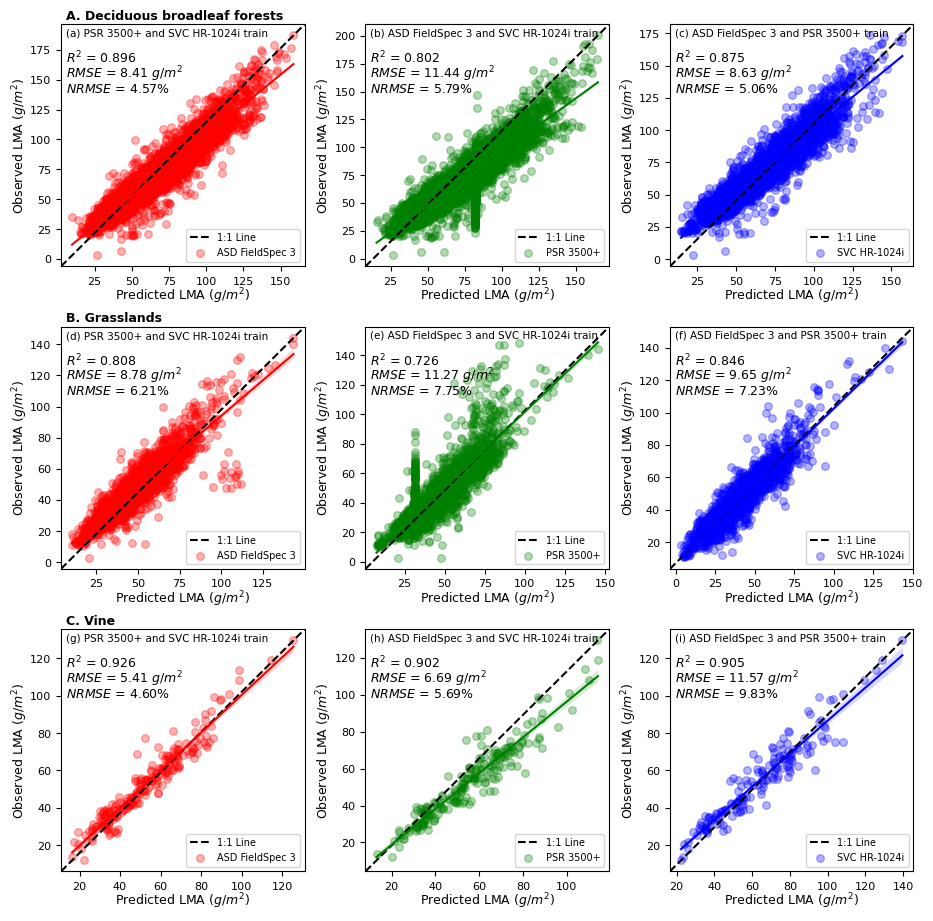

In [48]:
"""
Cross sensors testing.
-----
- Same location, PFTs, time but different sensors for data collecting. 
- Dataset#23 in the compiled dataset for LMA measurements.
"""

PFTs = ["Deciduous broadleaf forests","Grasslands","Vine"]
colors = ["r","g","b"]
sensors = ["ASD FieldSpec 3", "PSR 3500+", "SVC HR-1024i"]
title1 =[["(a)","(b)","(c)"],["(d)","(e)","(f)"],["(g)","(h)","(i)"]]
title2 = ["A.","B.","C."]

fig,ax = plt.subplots(3,3,figsize = (11,11))
config = {"font.family":'Calibri'}
plt.subplots_adjust(wspace =0.25,hspace =0.25)
plt.rcParams.update(config)

k = 0
for pft in PFTs:
    df1 = pd.read_csv(f'../2_results/LMA/LMA_{pft}_LOO_sensor_df.csv')
    df2 = pd.read_csv(f'../2_results/LMA/LMA_{pft}_LOO_sensor_overall_accuracy.csv')
    df2.columns = ["test_sensors", "R2", "RMSE", "NRMSE", "NSE"]
    j = 0
    ax[k][j].text(0.02,1.02, f'{title2[k]} {pft}', transform=ax[k][j].transAxes, fontsize = 9,fontweight='bold')
    for test_sensor in df1["test_sensors"].unique():
        data = df1[df1["test_sensors"]== test_sensor]
        ax[k][j].plot((0, 1), (0, 1), transform=ax[k][j].transAxes, label = "1:1 Line", ls='--',c='k', lw = 1.5)
        sns.regplot(data['pred'],data["LMA"],fit_reg=True,ax = ax[k][j],ci = 95,scatter=True,label = test_sensor,color = colors[j],scatter_kws = {'alpha':0.3,'s':30},line_kws = {'lw':1.5})

        R1 = '$R^2$ = '+str(round(df2[df2["test_sensors"]==test_sensor]["R2"].values[0],3))
        rmse1 = '$RMSE$ = '+str(round(df2[df2["test_sensors"]==test_sensor]["RMSE"].values[0],2))+' '+'$g/m^2$'
        nrmse1 = '$NRMSE$ = '+'{:.2%}'.format(df2[df2["test_sensors"]==test_sensor]["NRMSE"].values[0])
        
        train_sensor = [sensor for sensor in sensors if sensor != test_sensor]
        
        ax[k][j].text(0.02,0.84,R1, fontsize=9,transform=ax[k][j].transAxes)
        ax[k][j].text(0.02,0.78,rmse1, fontsize=9,transform=ax[k][j].transAxes)
        ax[k][j].text(0.02,0.72,nrmse1, fontsize=9,transform=ax[k][j].transAxes)
        ax[k][j].text(0.02,0.95, f'{title1[k][j]} {train_sensor[0]} and {train_sensor[1]} train', transform=ax[k][j].transAxes, fontsize = 7.5)
        
        ax[k][j].set_ylabel('Observed LMA ($g/m^2$)', fontsize=9, labelpad = 0.2)
        ax[k][j].set_xlabel('Predicted LMA ($g/m^2$)', fontsize=9, labelpad = 0.2)
        ax[k][j].legend(loc ='lower right',fontsize=7)
        j = j+1
    k = k+1
plt.savefig(f'../3_figures/Fig S19_cross sensors testing.png', dpi=500, bbox_inches='tight')

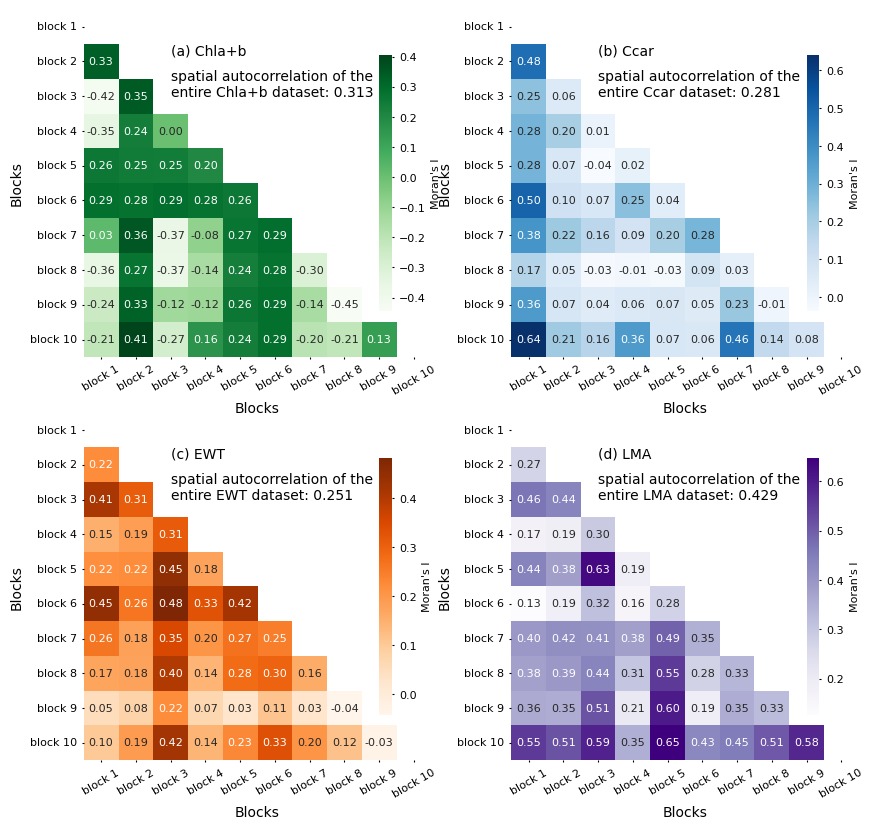

In [22]:
final_results = pd.read_csv("../1_datasets/Morans I.csv",index_col=0)
tr_name = ["Chla+b", "Ccar", "EWT","LMA"]
cmaps = ["Greens","Blues","Oranges","Purples"]
text = ("(a)","(b)","(c)","(d)")
fig = plt.figure(figsize = (10,10))
config = {"font.family":'Calibri'}
plt.subplots_adjust(wspace =0.23,hspace =0.1)
plt.rcParams.update(config)

k = 1
for tr in tr_name:
    data = final_results[final_results["trait"]==tr]
    spatial_auto_whole = data["spatial_auto_whole"].unique()[0]
    data = data.loc[:,:"block 10"].T
    ax = fig.add_subplot(2,2,k)
    
    sns.heatmap(data,annot=True,ax = ax,cmap=cmaps[k-1], square = True,annot_kws={"size": 8},fmt='.2f',
                       cbar_kws={'label': "Moran's I","shrink": 0.7, 'pad': -0.15})

    ax.figure.axes[-1].yaxis.label.set_size(8)
    ax.figure.axes[-1].tick_params(axis='y', direction='out', size=1.5,labelsize=8)
    ax.text(0.25,0.87, f"{text[k-1]} {tr}", transform=ax.transAxes, fontsize = 10)
    ax.text(0.25,0.75, f"spatial autocorrelation of the\nentire {tr} dataset: {round(spatial_auto_whole,3)}", transform=ax.transAxes, fontsize = 10)
    
    ax.set_xlabel('Blocks',fontsize = 10)
    ax.set_ylabel('Blocks',fontsize = 10)
    ax.tick_params(axis='both', direction='out', size=1.5, which='major', labelsize=8)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    k = k+1
plt.savefig(f'../3_figures/Fig S21_Morans I.png', dpi=500, bbox_inches='tight')